In [2]:
%%capture
%load_ext autoreload
%autoreload 2

import sys
import warnings
warnings.filterwarnings(action = 'once')
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score
sys.path.append("used_functions")
import custom_functions



plt.style.use('ggplot')
## Change title size of a plot
mpl.rcParams['axes.titlesize'] = 22
# Figure size
mpl.rc("figure", figsize = (15,7))
## Change label size(x and y) of a plot
mpl.rcParams['axes.labelsize'] = 18
## Change xticks size of a plot
mpl.rcParams['xtick.labelsize'] = 16
## Change yticks size of a plot
mpl.rcParams['ytick.labelsize'] = 16

In [3]:
crime2010To2019_df = pd.read_csv("crime2010To2019_cleaned.csv")

## ARIMA  Models on Daily data 

### What is ARIMA?

In statistics and econometrics, and in particular in time series analysis, an autoregressive integrated moving average (ARIMA) model is a generalization of an autoregressive moving average (ARMA) model. Both of these models are fitted to time series data either to better understand the data or to predict future points in the series (forecasting). ARIMA models are applied in some cases where data show evidence of non-stationarity, where an initial differencing step (corresponding to the "integrated" part of the model) can be applied one or more times to eliminate the non-stationarity.

The AR part of ARIMA indicates that the evolving variable of interest is regressed on its own lagged (i.e., prior) values. The MA part indicates that the regression error is actually a linear combination of error terms whose values occurred contemporaneously and at various times in the past. The I (for "integrated") indicates that the data values have been replaced with the difference between their values and the previous values (and this differencing process may have been performed more than once). The purpose of each of these features is to make the model fit the data as well as possible.

Non-seasonal ARIMA models are generally denoted ARIMA(p,d,q) where parameters p, d, and q are non-negative integers, p is the order (number of time lags) of the autoregressive model, d is the degree of differencing (the number of times the data have had past values subtracted), and q is the order of the moving-average model. Seasonal ARIMA models are usually denoted ARIMA(p,d,q)(P,D,Q)m, where m refers to the number of periods in each season, and the uppercase P,D,Q refer to the autoregressive, differencing, and moving average terms for the seasonal part of the ARIMA model.

When two out of the three terms are zeros, the model may be referred to based on the non-zero parameter, dropping "AR", "I" or "MA" from the acronym describing the model. For example, ARIMA (1,0,0) is AR(1), ARIMA(0,1,0) is I(1), and ARIMA(0,0,1) is MA(1).


Source - https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average 

### Generating data

In [4]:
# Converting Date column to datatime object
crime2010To2019_df["Date"] = pd.to_datetime(crime2010To2019_df["Date"])
crime2010To2019_df.index = crime2010To2019_df["Date"]

# Creating data for time series modeling
day_col = []
total_crimes_day = []
temp_crime_type_day = {}
crime_type_dict_day = {}
unique_crimes = crime2010To2019_df["Primary Type"].unique()


# Creating a dictionary with all the crime types and initializing their count to zero.
for crime in unique_crimes:
    temp_crime_type_day[crime] = 0

# Grouping data by day
grouped_by_day = crime2010To2019_df.groupby(crime2010To2019_df["Date"].dt.date)

# Extracting data for days from grouped by object
for key, item in grouped_by_day:
    
    # Creating a copy of a dictionary
    crime_type = temp_crime_type_day.copy()
    
    # Appending a key to day_col [key = date]
    day_col.append(key)
    
    # Appending total number of crimes by taking number of rows from the dataframe item
    total_crimes_day.append(item.shape[0])
    
    # Looping through primary type of crime in item dataframe
    for crime in item["Primary Type"]:
        
        # Increamenting the crime count
        crime_type[crime] += 1
    
    # Storing the count of the crime by using key to a dictionary
    crime_type_dict_day[key] = crime_type

# Initializing an empty dataframe
arima_df_day = pd.DataFrame()

# Creating a columns of the dataframe
arima_df_day["Date"] = day_col
arima_df_day["Crimes"] = total_crimes_day

# Creating a new dataframe by using dictionary crime_type_dict_day
temp_df_day = pd.DataFrame.from_dict(crime_type_dict_day, orient="index")

# Dropping the index of the dataframe
temp_df_day.reset_index(drop = True, inplace = True)

# Joining the two dataframe.
arima_df_day = arima_df_day.join(temp_df_day)

# Columns which are not important
## Reason - These types of crimes are rarely occuring and have low total count. Model won't be able to learn/traing much 
## and in turn won't able to predict values of these columns accurately.
delete_cols = ['INTERFERENCE WITH PUBLIC OFFICER', 'LIQUOR LAW VIOLATION', 'PROSTITUTION', 'CRIM SEXUAL ASSAULT',
               'INTIMIDATION','SEX OFFENSE', 'CONCEALED CARRY LICENSE VIOLATION', 'HOMICIDE', 'KIDNAPPING', 'ARSON',
               'GAMBLING', 'OFFENSE INVOLVING CHILDREN', 'STALKING', 'OBSCENITY', 'HUMAN TRAFFICKING', 'PUBLIC INDECENCY',
               'OTHER NARCOTIC VIOLATION', 'NON-CRIMINAL', 'NON - CRIMINAL', 'NON-CRIMINAL (SUBJECT SPECIFIED)']

# Dropping the columns
arima_df_day.drop(delete_cols, axis = 1, inplace = True);

## Crimes
Crimes column contains total number of crimes happened on a particulare day.

### Plotting graph(Sequence plot)

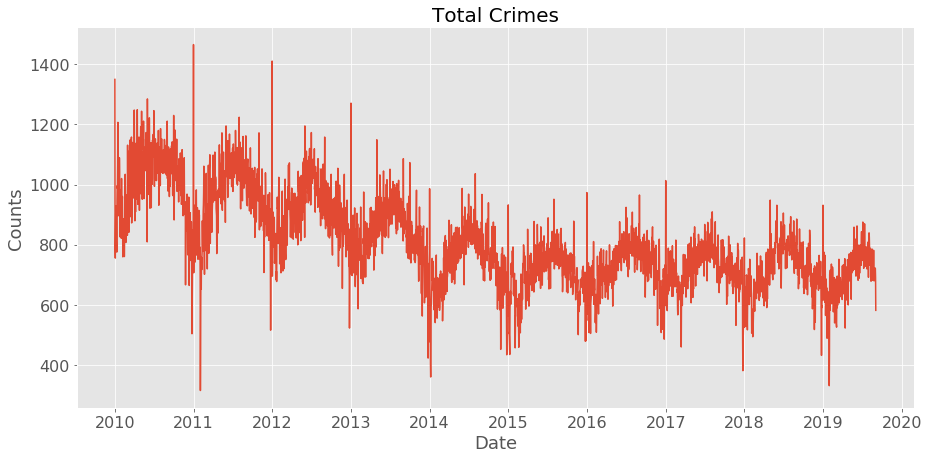

In [9]:
# Plotting a sequence plot
custom_functions.sequence_plot(arima_df_day["Crimes"], arima_df_day["Date"], "Total Crimes")

Before applying Time series model ARIMA we need to check stationarity of the data which can be assessed by assessing following two things.

1. Data should fluctuate around the constant mean/value.
2. Variation of the data must be within a constant band.

If both conditions are true that means data comes from a **stationary process**(that means we can use it to predict and forecast) then only we can fit the ARIMA model to it. For the above graph condition 1 is not true(We can see decreasing trend in the data) but for to start we will fit ARIMA model anyway.

### Plotting ACF and PACF plots to decide the model parameters

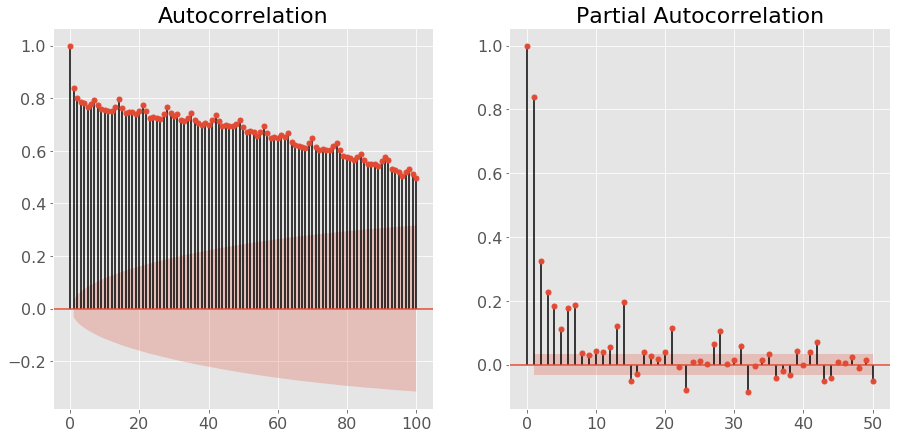

In [10]:
# Plot ACF and PACF plot
custom_functions.plot_ACF_PACF(arima_df_day["Crimes"])

To decide model parameters, We need to look at ACF and PACF plots. 
There are three classic cases.

1. CASE1 - Gradual decrease in ACF and Definite cut off in PACF plot. That suggests AR(Auto Regressive) terms. To decide how many AR(Auto Regressive) terms we need to look at PACF plot and see how many bars are significantly out of confindence interval(red zone).

2. CASE2 - Gradual decrease in PACF and Definite cut off in ACF plot. That suggests MA(Moving Average) terms. To decide how many MA(Moving Average) terms we need to look at ACF plot and see how many bars are significantly out of confindence interval(red zone).

3. CASE3 - Definite cut off in both ACF and PACF plots. That suggests both AR(Auto Regressive) and MA(Moving Average) terms. To decide how many AR(Auto Regressive) terms we need to look at PACF plot and to decide how many MA(Moving Average) terms we need to look at ACF plot and see how many bars are significantly out of confindence interval(red zone).


**Here we can see CASE1 in the above plots.** And 15 lags are outside of the confidence interval in PACF plot.

## Choosing model ARIMA(15, 0, 0)

In [11]:
# Creating training data for the model
series = pd.Series(arima_df_day["Crimes"][:-10])
series.index = arima_df_day["Date"][:-10]

# Fitting an ARIMA model
custom_functions.fit_ARIMA(series, series.index, title = "Crimes", order=(15, 0, 0), print_summary=True);

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi


                              ARMA Model Results                              
Dep. Variable:                 Crimes   No. Observations:                 3523
Model:                    ARMA(15, 0)   Log Likelihood              -19819.322
Method:                       css-mle   S.D. of innovations             67.109
Date:                Sun, 03 Nov 2019   AIC                          39672.645
Time:                        21:01:36   BIC                          39777.485
Sample:                    01-01-2010   HQIC                         39710.048
                         - 08-24-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           810.1817     42.917     18.878      0.000     726.067     894.297
ar.L1.Crimes      0.3545      0.017     20.942      0.000       0.321       0.388
ar.L2.Crimes      0.1011      0.018     

We can see that all the AR terms are highly significant as AR15 is highly significant. (P-value < 0.05)

## Fitting model without constant as standard error of the model is high

                              ARMA Model Results                              
Dep. Variable:                 Crimes   No. Observations:                 3523
Model:                    ARMA(15, 0)   Log Likelihood              -19825.295
Method:                       css-mle   S.D. of innovations             67.187
Date:                Sun, 03 Nov 2019   AIC                          39682.589
Time:                        21:02:25   BIC                          39781.263
Sample:                    01-01-2010   HQIC                         39717.793
                         - 08-24-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1.Crimes      0.3568      0.017     21.170      0.000       0.324       0.390
ar.L2.Crimes      0.1031      0.018      5.850      0.000       0.069       0.138
ar.L3.Crimes      0.0615      0.018     

<Figure size 1080x504 with 0 Axes>

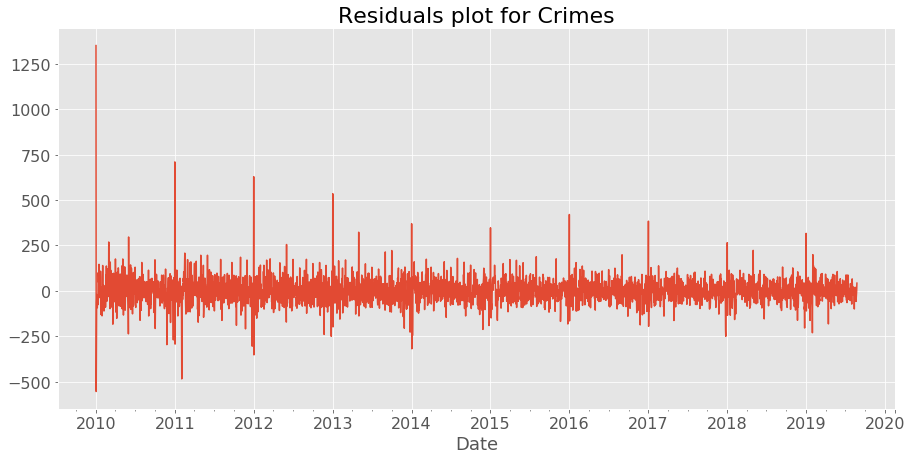

In [12]:
# Storing forecast in a variable
forecast = custom_functions.fit_ARIMA(series, series.index, order=(15, 0, 0), trend = "nc", title = "Crimes",
                                      print_summary = True, residual_plot = True)

AS we can see residual sequence plot looks like it comes from a stationary process except for some spikes.

## Forecasting using the model

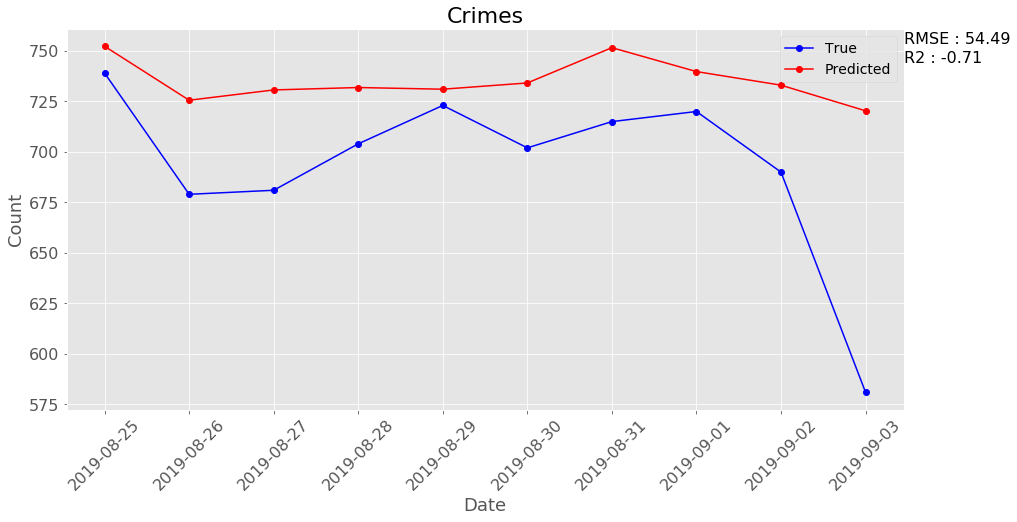

In [13]:
# Testing data
true_values = arima_df_day.tail(10)["Crimes"]
dates = arima_df_day.tail(10)["Date"]

# Plotting the true vs predicted values
custom_functions.plot_true_vs_predicted(true_values, forecast, dates, title = "Crimes")

Looks like model is getting pattern of the original values. But still model is not performing well so now we will take first order difference of the data.

## Model with First order Difference

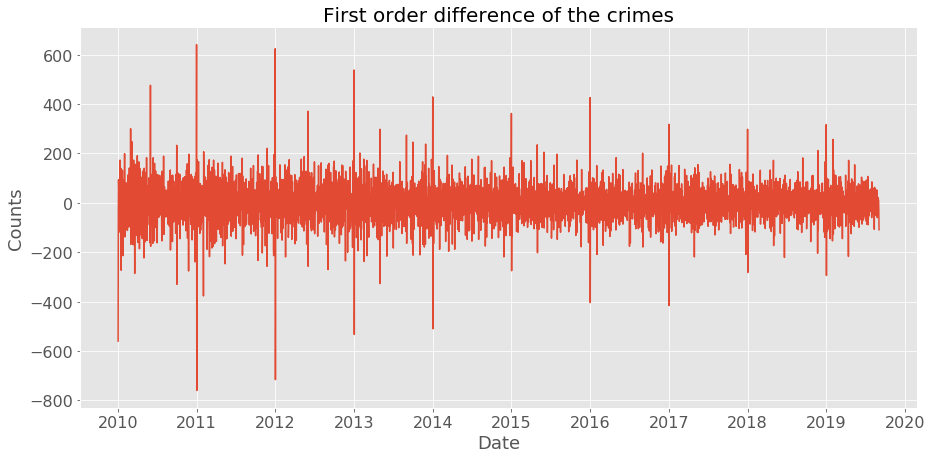

In [14]:
# Calculating first order difference of the data
differenced = custom_functions.difference(arima_df_day["Crimes"], interval = 1)

# Sequence plot
custom_functions.sequence_plot(differenced, arima_df_day["Date"][1:], 
                               "First order difference of the crimes")

First order difference looks like it comes from a stationary process so now we will fit an ARIMA model on it.

### Plotting ACF and PACF plot to decide the model

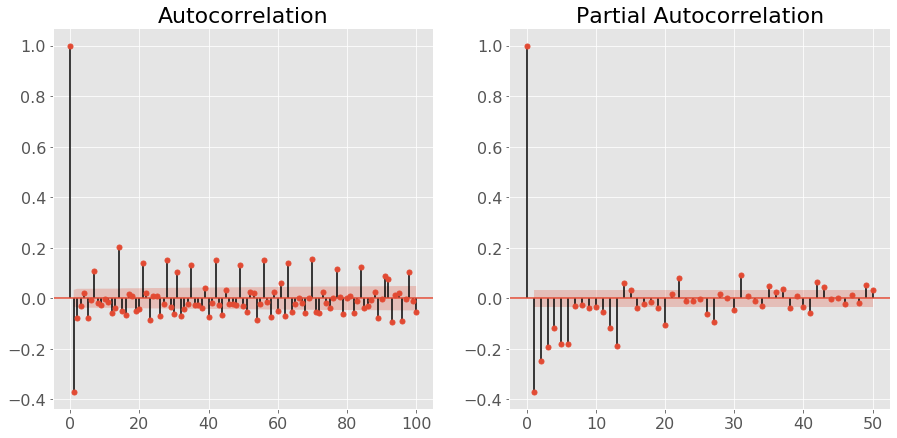

In [15]:
# Plotting ACF and PACF
custom_functions.plot_ACF_PACF(differenced)

Choosing ARIMA(15, 1, 0) Model as 15 lags are popping out in PACF plot and there is a gradual decrease in the ACF plot which suggests taking AR terms. But AR15 term was insignificant so removing that erm.

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi


                             ARIMA Model Results                              
Dep. Variable:               D.Crimes   No. Observations:                 3522
Model:                ARIMA(14, 1, 0)   Log Likelihood              -19817.194
Method:                       css-mle   S.D. of innovations             67.188
Date:                Sun, 03 Nov 2019   AIC                          39666.387
Time:                        21:03:23   BIC                          39765.056
Sample:                    01-02-2010   HQIC                         39701.589
                         - 08-24-2019                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0623      0.214     -0.291      0.771      -0.483       0.358
ar.L1.D.Crimes     -0.6432      0.017    -37.989      0.000      -0.676      -0.610
ar.L2.D.Crimes     -0.5401      

<Figure size 1080x504 with 0 Axes>

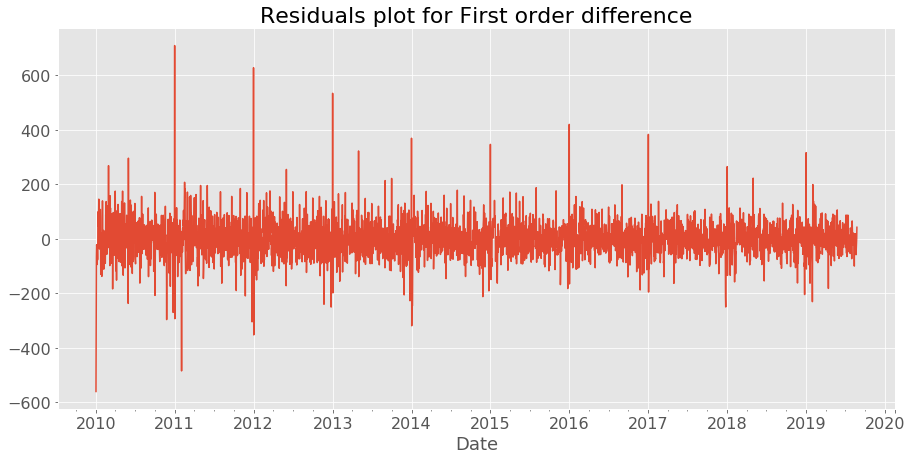

In [16]:
forecast_diff = custom_functions.fit_ARIMA(series, series.index, order = (14, 1, 0), title = "First order difference", 
                           print_summary = True, residual_plot = True)

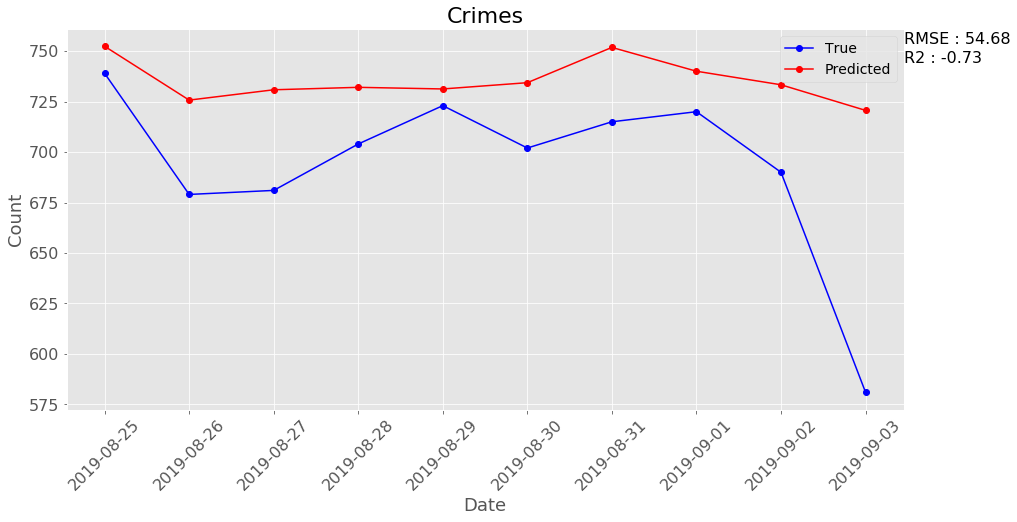

In [17]:
# Plotting true vs predicted values
custom_functions.plot_true_vs_predicted(true_values, forecast_diff, dates, title = "Crimes")

AR15 term was insignificant so I had to drop it. RMSE For Model ARIMA(14, 1, 0) : 54.68  which is little more than the RMSE of the Model ARIMA(15, 0 ,0) which was 54.49. And also we can see the graph model is just not getting the pattern which is in the original data. R2 value has also gone up by 0.02 that is an improvement. As these both models have negative R2 this models are worse than fitting the mean to the data. Now we will try ARIMA model on other variables.

## BATTERY

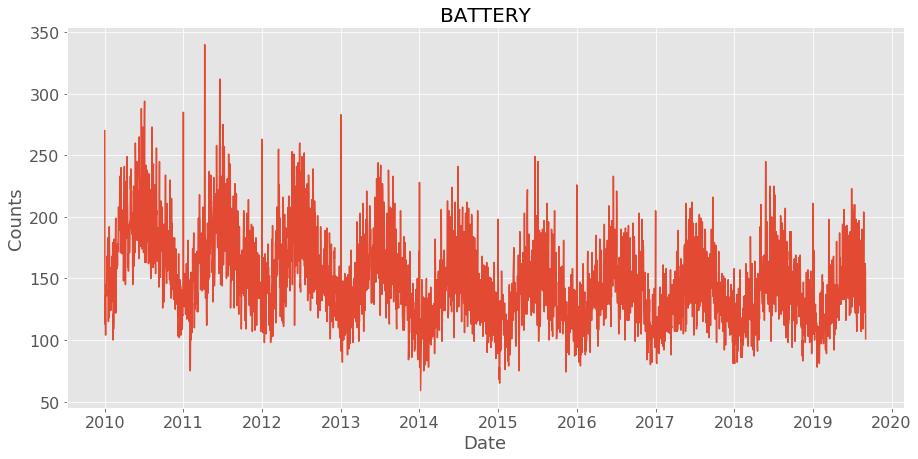

In [18]:
# Data looks like it comes from a stationary process
custom_functions.sequence_plot(arima_df_day["BATTERY"], arima_df_day["Date"], "BATTERY")

### Plotting ACF and PACF to decide the model

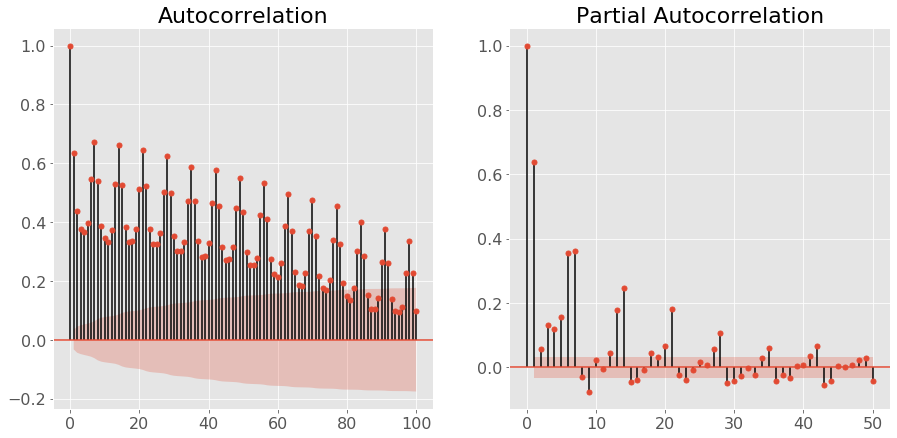

In [19]:
# Plotting ACF and PACF plot
custom_functions.plot_ACF_PACF(arima_df_day["BATTERY"])

Choosing ARIMA(15, 0, 0) Model as 15 lags are popping out in PACF plot and there is a gradual decrease in the ACF plot which suggests taking AR terms.

### Fitting ARIMA(15, 0, 0) to BATTERY

In [20]:
# Creating data for model
series = arima_df_day["BATTERY"][:-10]
series.index = arima_df_day.index[:-10]

# Fitting an ARIMA model
forecast_bat = custom_functions.fit_ARIMA(series, series.index, order = (15, 0, 0), title = "BATTERY", print_summary = True)

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi


                              ARMA Model Results                              
Dep. Variable:                BATTERY   No. Observations:                 3523
Model:                    ARMA(15, 0)   Log Likelihood              -15804.802
Method:                       css-mle   S.D. of innovations             21.471
Date:                Sun, 03 Nov 2019   AIC                          31643.605
Time:                        21:04:24   BIC                          31748.445
Sample:                    01-01-1970   HQIC                         31681.009
                         - 01-01-1970                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            146.8664      5.542     26.500      0.000     136.004     157.729
ar.L1.BATTERY      0.3521      0.017     20.818      0.000       0.319       0.385
ar.L2.BATTERY      0.0209      0.017

### Evaluating the model

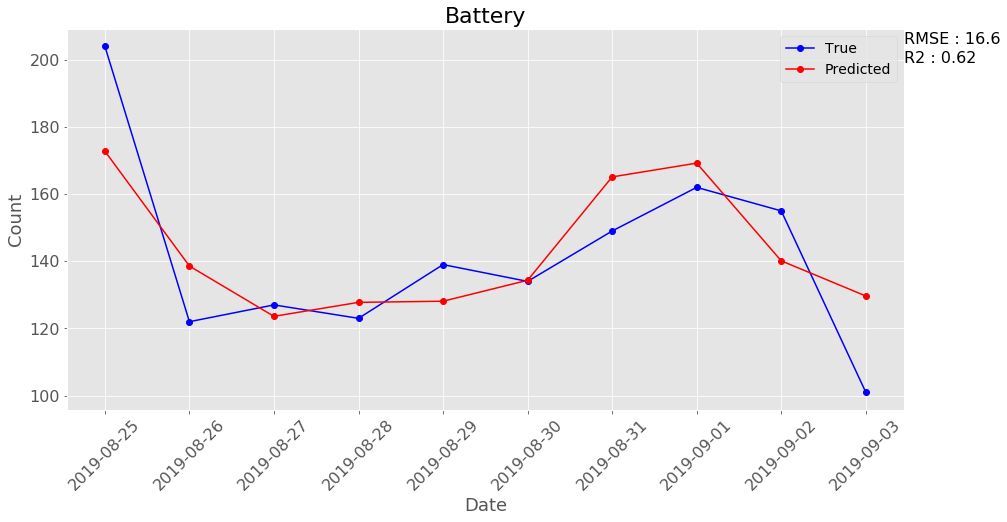

In [21]:
true_values = arima_df_day["BATTERY"][-10:]
dates = arima_df_day["Date"][-10:]
custom_functions.plot_true_vs_predicted(true_values, forecast_bat, dates, title = "Battery")

ARIMA(15,0,0) can predict BATTERY crime more accurately then predicting Total crimes as we can see that the R2 value is 0.62 which means model can explain 62% variation in the data. RMSE is 16.6 which is quite low compare to previous models. Let's try fitting the first order difference to the BATTERY.

### First order difference of the BATTERY<a id='battery_ARIMA'></a>

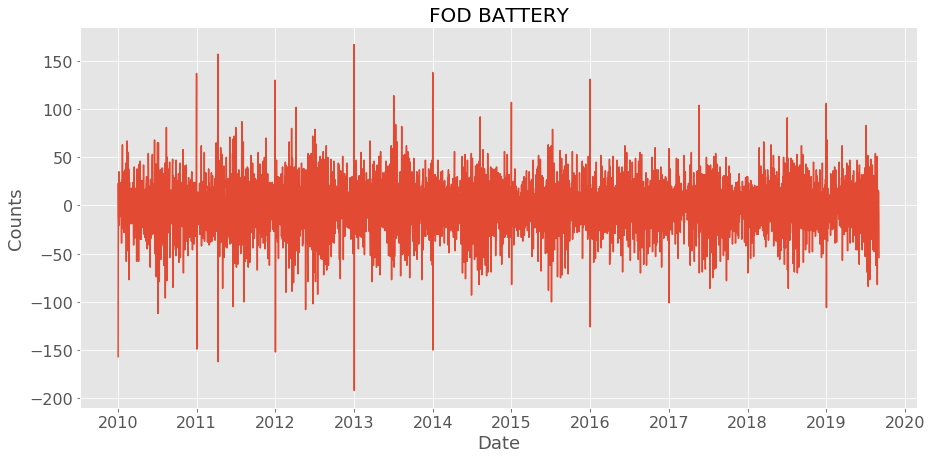

In [22]:
# Creating FOD
differenced_bat = custom_functions.difference(arima_df_day["BATTERY"], interval = 1)

# Plotting sequence plot
custom_functions.sequence_plot(differenced_bat, arima_df_day["Date"][1:], title = "FOD BATTERY")

# FOD of BATTERy comes from a stationary proecess

In [23]:
forecast_bat1 = custom_functions.fit_ARIMA(series, series.index, order = (15, 1, 0), trend = "nc", title = "FOD BATTERY", 
                                           print_summary = True)

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi


                             ARIMA Model Results                              
Dep. Variable:              D.BATTERY   No. Observations:                 3522
Model:                ARIMA(15, 1, 0)   Log Likelihood              -15807.709
Method:                       css-mle   S.D. of innovations             21.517
Date:                Sun, 03 Nov 2019   AIC                          31647.418
Time:                        21:05:33   BIC                          31746.086
Sample:                    01-01-1970   HQIC                         31682.620
                         - 01-01-1970                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
ar.L1.D.BATTERY     -0.6443      0.017    -38.057      0.000      -0.677      -0.611
ar.L2.D.BATTERY     -0.6101      0.020    -30.367      0.000      -0.650      -0.571
ar.L3.D.BATTERY     -0.5677 

AR15 term is a borderline as P-value = 0.053, but we will still consider this term.

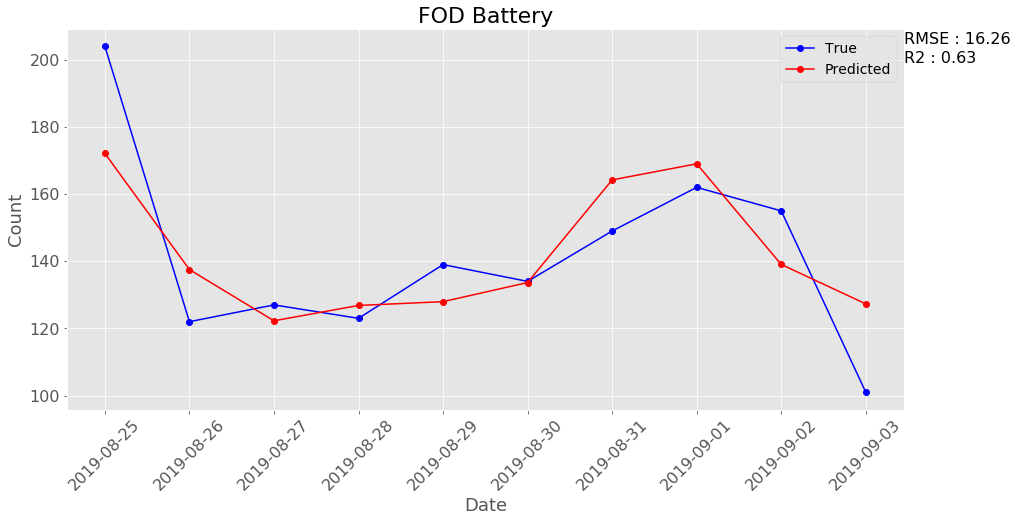

In [24]:
custom_functions.plot_true_vs_predicted(true_values, forecast_bat1, dates, title = "FOD Battery")

ARIMA model on FOD is performing better than the previous model as we have 1% increase in R2.

## MOTOR VEHICLE THEFT

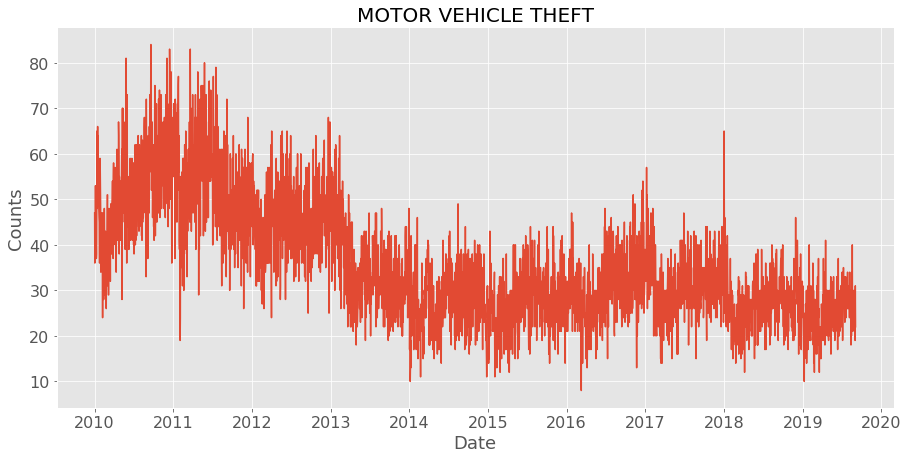

In [25]:
# MOTOR VEHICLE THEFT does not come from a stationary process, fitting ARIMA anyway.
custom_functions.sequence_plot(arima_df_day["MOTOR VEHICLE THEFT"], arima_df_day["Date"], "MOTOR VEHICLE THEFT")

### Plotting ACF and PACF to decide the model

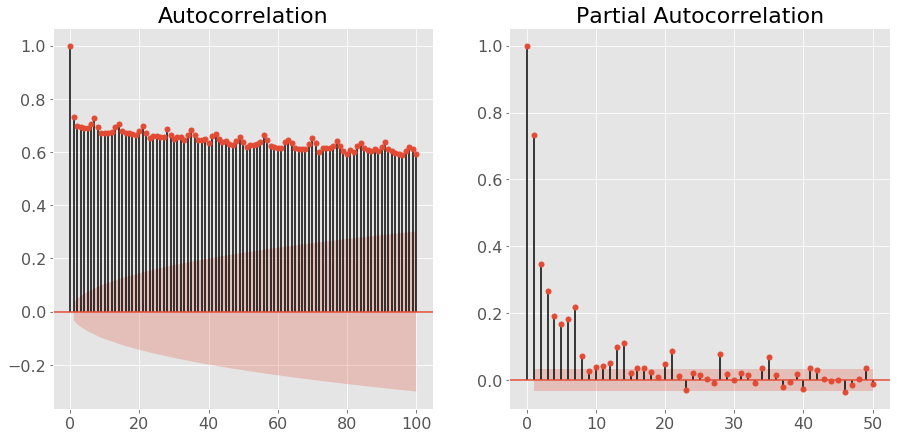

In [26]:
# ACF and PACF plot
custom_functions.plot_ACF_PACF(arima_df_day["MOTOR VEHICLE THEFT"])

Choosing ARIMA(15, 0, 0) Model as 15 lags are popping out in PACF plot and there is a gradual decrease in the ACF plot which suggests taking AR terms. I have fitted ARIMA(15,0,0) but AR15 term is insignificant so We will fit ARIMA(14,0,0).

### Fitting ARIMA(14, 0, 0) to MOTOR VEHICLE THEFT

In [27]:
# Creating data for model
series = arima_df_day["MOTOR VEHICLE THEFT"][:-10]
series.index = arima_df_day.index[:-10]

# Fitting an ARIMA model
forecast_mot = custom_functions.fit_ARIMA(series, series.index, order = (14, 0, 0), title = "MOTOR VEHICLE THEFT", 
                                          print_summary = True)

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi


                               ARMA Model Results                              
Dep. Variable:     MOTOR VEHICLE THEFT   No. Observations:                 3523
Model:                     ARMA(14, 0)   Log Likelihood              -11979.636
Method:                        css-mle   S.D. of innovations              7.251
Date:                 Sun, 03 Nov 2019   AIC                          23991.271
Time:                         21:06:19   BIC                          24089.944
Sample:                     01-01-1970   HQIC                         24026.475
                          - 01-01-1970                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         35.5209      3.293     10.786      0.000      29.066      41.976
ar.L1.MOTOR VEHICLE THEFT      0.1932      0.017     11.545      0.000     

### Evaluating the model

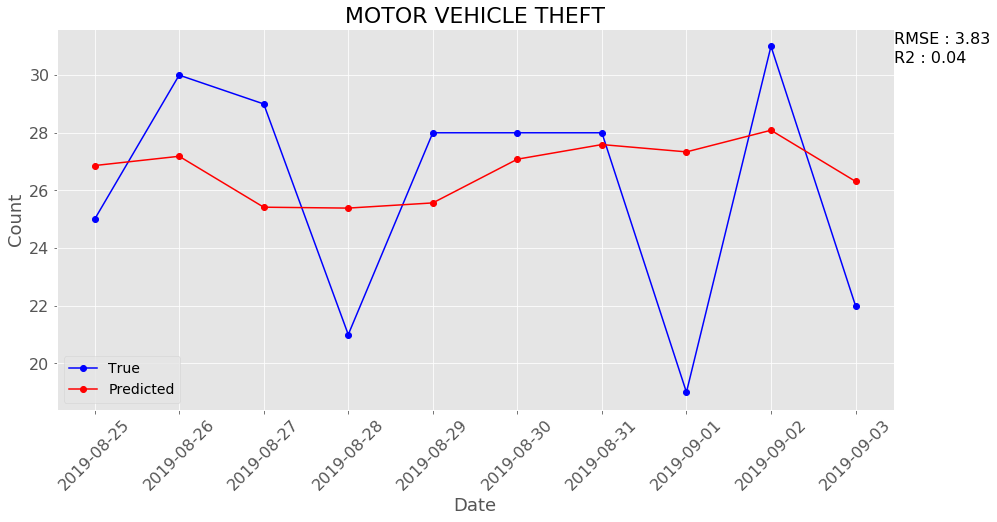

In [28]:
true_values = arima_df_day["MOTOR VEHICLE THEFT"][-10:]
dates = arima_df_day["Date"][-10:]
custom_functions.plot_true_vs_predicted(true_values, forecast_mot, dates, title = "MOTOR VEHICLE THEFT")

ARIMA(14,0,0) can predict MOTOR VEHICLE THEFT with the R2 value of 0.04 which means model can explain 4% variation in the data. RMSE is 3.83 which is quite low compare to previous models(Explained by low value of variable). I have fitted FOD(First order difference) to MOTOR VEHICLE THEFT and SOD(Second order difference) to MOTOR VEHICLE THEFT. SOD(R2 = 0.09) is much better than FOD(R2 = 0.04).

### Second order difference of the BATTERY

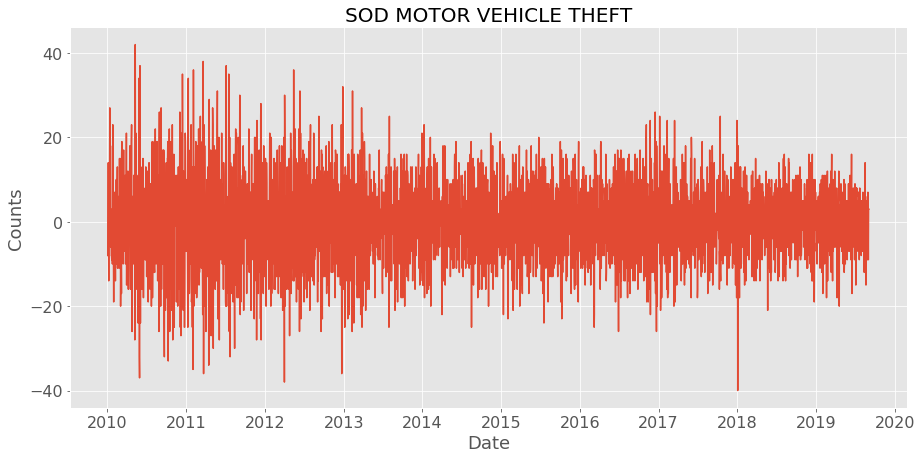

In [29]:
# Creating SOD of the data
differenced_mot = custom_functions.difference(arima_df_day["MOTOR VEHICLE THEFT"], interval = 2)

# Sequence plot - data is from stationary process
custom_functions.sequence_plot(differenced_mot, arima_df_day["Date"][2:], title = "SOD MOTOR VEHICLE THEFT")

In [30]:
# Fitting an ARIMA model
forecast_mot2 = custom_functions.fit_ARIMA(series, series.index, order = (15, 2, 0), trend = "nc", 
                                           title = "DIFF MOTOR VEHICLE THEFT", print_summary = True)

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi


                               ARIMA Model Results                                
Dep. Variable:     D2.MOTOR VEHICLE THEFT   No. Observations:                 3521
Model:                    ARIMA(15, 2, 0)   Log Likelihood              -12235.262
Method:                           css-mle   S.D. of innovations              7.809
Date:                    Sun, 03 Nov 2019   AIC                          24502.523
Time:                            21:07:18   BIC                          24601.187
Sample:                        01-01-1970   HQIC                         24537.725
                             - 01-01-1970                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
ar.L1.D2.MOTOR VEHICLE THEFT     -1.6550      0.017    -98.831      0.000      -1.688      -1.622
ar.L2.D2.MOTOR VEHICLE THEFT     -2.1265  

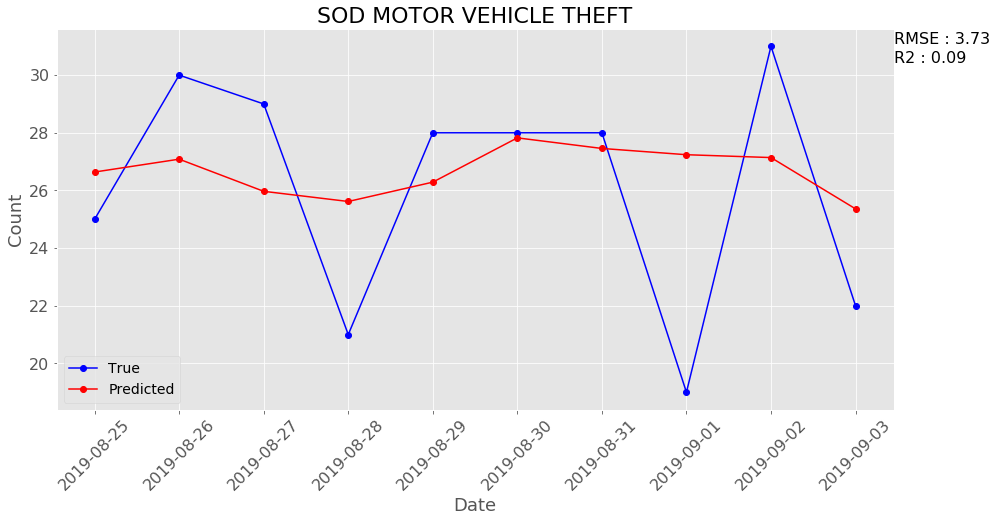

In [31]:
custom_functions.plot_true_vs_predicted(true_values, forecast_mot2, dates, title = "SOD MOTOR VEHICLE THEFT")

## CRIMINAL DAMAGE

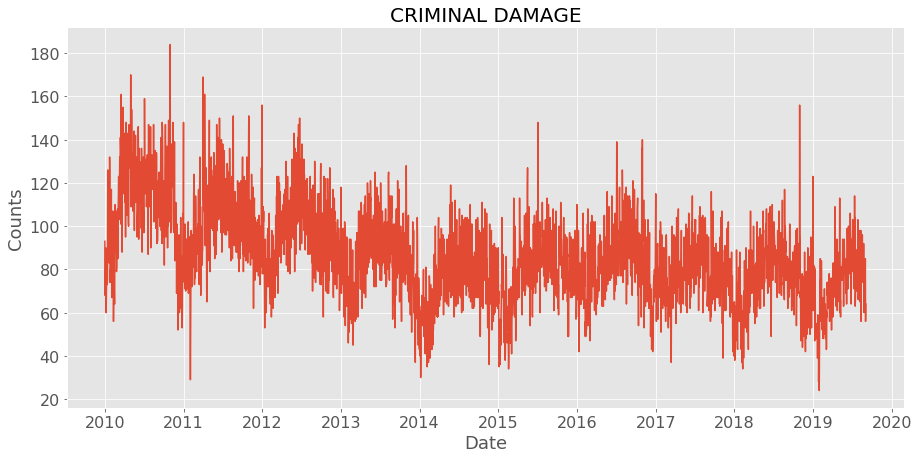

In [32]:
# Sequence plot - data looks like it comes from a stationary process
custom_functions.sequence_plot(arima_df_day["CRIMINAL DAMAGE"], arima_df_day["Date"], "CRIMINAL DAMAGE")

### Plotting ACF and PACF to decide the model

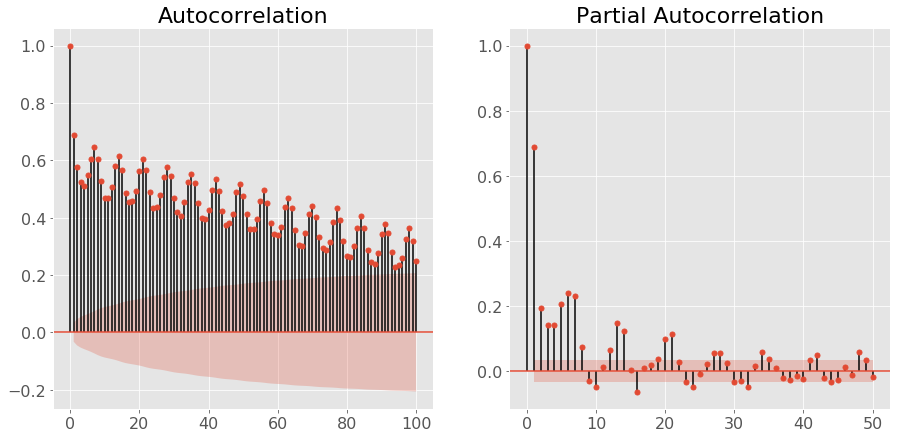

In [33]:
# ACF and PACF plot
custom_functions.plot_ACF_PACF(arima_df_day["CRIMINAL DAMAGE"])

Choosing ARIMA(15, 0, 0) Model as 15 lags are popping out in PACF plot and there is a gradual decrease in the ACF plot which suggests taking AR terms. I have fitted ARIMA(15,0,0) but AR15 term is insignificant so We will fit ARIMA(14,0,0).

### Fitting ARIMA(14, 0, 0) to CRIMINAL DAMAGE

In [34]:
# Creating data for the model
series = arima_df_day["CRIMINAL DAMAGE"][:-10]
series.index = arima_df_day.index[:-10]

# Fitting an ARIMA model
forecast_cri = custom_functions.fit_ARIMA(series, series.index, order = (14, 0, 0), title = "CRIMINAL DAMAGE", 
                                          print_summary = True)

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi


                              ARMA Model Results                              
Dep. Variable:        CRIMINAL DAMAGE   No. Observations:                 3523
Model:                    ARMA(14, 0)   Log Likelihood              -14105.399
Method:                       css-mle   S.D. of innovations             13.257
Date:                Sun, 03 Nov 2019   AIC                          28242.798
Time:                        21:08:03   BIC                          28341.471
Sample:                    01-01-1970   HQIC                         28278.001
                         - 01-01-1970                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     86.3068      3.588     24.054      0.000      79.274      93.339
ar.L1.CRIMINAL DAMAGE      0.3302      0.017     19.742      0.000       0.297       0.363
ar.L

### Evaluating the model

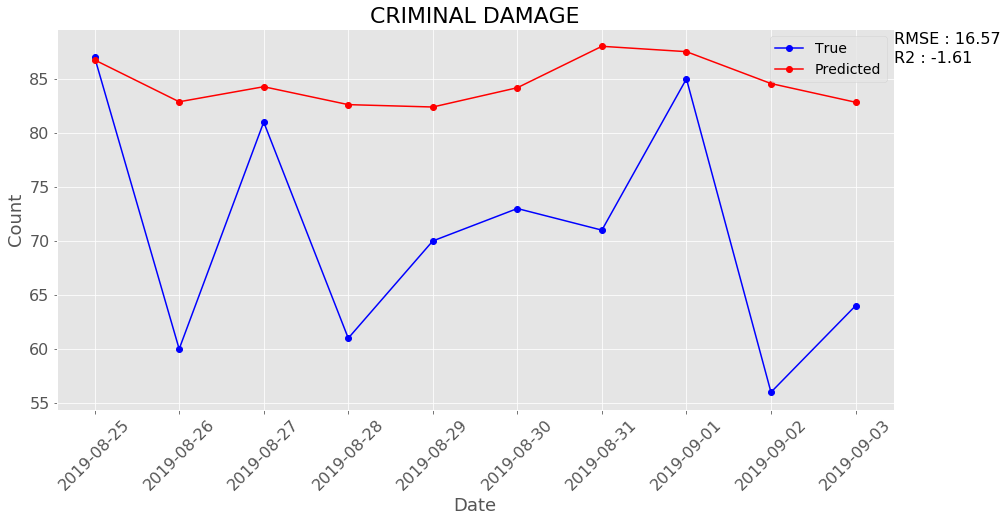

In [35]:
true_values = arima_df_day["CRIMINAL DAMAGE"][-10:]
dates = arima_df_day["Date"][-10:]
custom_functions.plot_true_vs_predicted(true_values, forecast_cri, dates, title = "CRIMINAL DAMAGE")

ARIMA(14,0,0) can predict CRIMINAL DAMAGE with the R2 value of -1.61 which means model is worse than fitting mean to the data. RMSE is 16.57.

### First order difference of the CRIMINAL DAMAGE

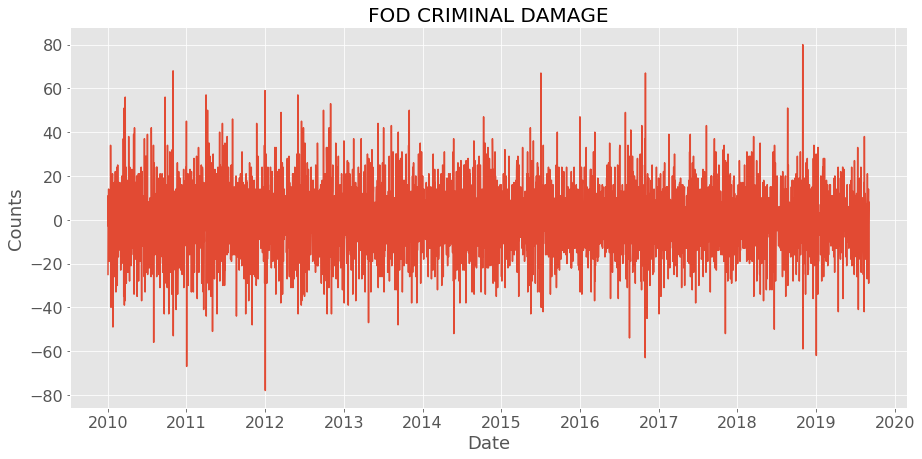

In [36]:
# Creating FOD of the data
differenced_cri = custom_functions.difference(arima_df_day["CRIMINAL DAMAGE"], interval = 1)

# Sequence plot
custom_functions.sequence_plot(differenced_cri, arima_df_day["Date"][1:], title = "FOD CRIMINAL DAMAGE")

In [37]:
# Fitting an ARIMA model
forecast_cri1 = custom_functions.fit_ARIMA(series, series.index, order = (15, 1, 0), trend = "nc", 
                                           title = "FOD CRIMINAL DAMAGE", print_summary = True)

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi


                             ARIMA Model Results                              
Dep. Variable:      D.CRIMINAL DAMAGE   No. Observations:                 3522
Model:                ARIMA(15, 1, 0)   Log Likelihood              -14104.868
Method:                       css-mle   S.D. of innovations             13.271
Date:                Sun, 03 Nov 2019   AIC                          28241.735
Time:                        21:08:54   BIC                          28340.404
Sample:                    01-01-1970   HQIC                         28276.938
                         - 01-01-1970                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
ar.L1.D.CRIMINAL DAMAGE     -0.6640      0.017    -39.472      0.000      -0.697      -0.631
ar.L2.D.CRIMINAL DAMAGE     -0.5940      0.020    -29.403      0.000      -0.634      -0.

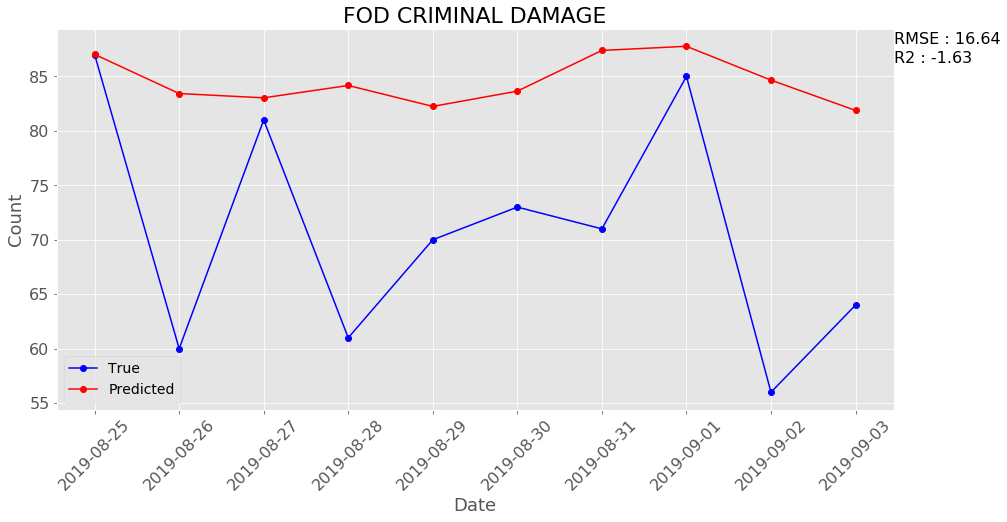

In [38]:
custom_functions.plot_true_vs_predicted(true_values, forecast_cri1, dates, title = "FOD CRIMINAL DAMAGE")

Latter model is worse than the previous model R2 score has gone down and there is an increase in RMSE compare to former model.

## ASSAULT

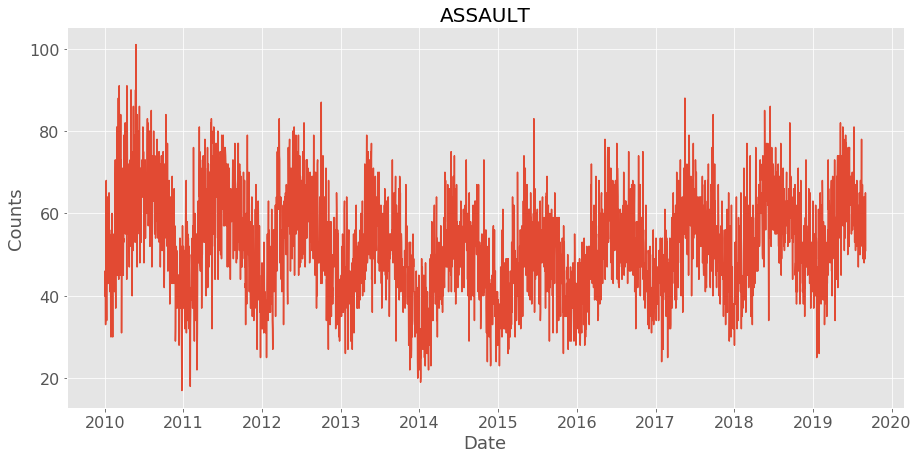

In [39]:
# Data comes from a stationary process
custom_functions.sequence_plot(arima_df_day["ASSAULT"], arima_df_day["Date"], "ASSAULT")

### Plotting ACF and PACF to decide the model

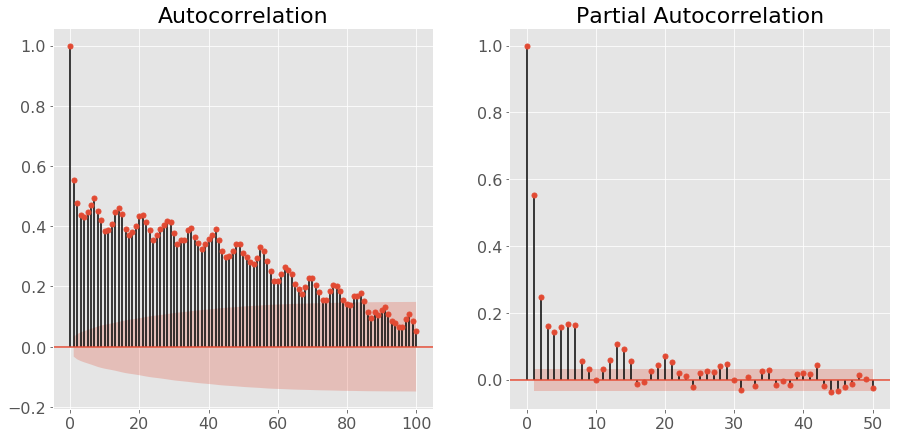

In [40]:
# ACF and PACF plot
custom_functions.plot_ACF_PACF(arima_df_day["ASSAULT"])

Choosing ARIMA(15, 0, 0) Model as 15 lags are popping out in PACF plot and there is a gradual decrease in the ACF plot which suggests taking AR terms.

### Fitting ARIMA(15, 0, 0) to ASSAULT

In [41]:
# Creating data
series = arima_df_day["ASSAULT"][:-10]
series.index = arima_df_day.index[:-10]

# Fitting ARIMA(15, 0, 0)
forecast_ass = custom_functions.fit_ARIMA(series, series.index, order = (15, 0, 0), title = "ASSAULT", 
                                          print_summary = True)

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi


                              ARMA Model Results                              
Dep. Variable:                ASSAULT   No. Observations:                 3523
Model:                    ARMA(15, 0)   Log Likelihood              -12706.419
Method:                       css-mle   S.D. of innovations              8.913
Date:                Sun, 03 Nov 2019   AIC                          25446.838
Time:                        21:09:47   BIC                          25551.678
Sample:                    01-01-1970   HQIC                         25484.242
                         - 01-01-1970                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             52.4318      1.588     33.015      0.000      49.319      55.544
ar.L1.ASSAULT      0.2463      0.017     14.638      0.000       0.213       0.279
ar.L2.ASSAULT      0.0869      0.017

### Evaluating the model

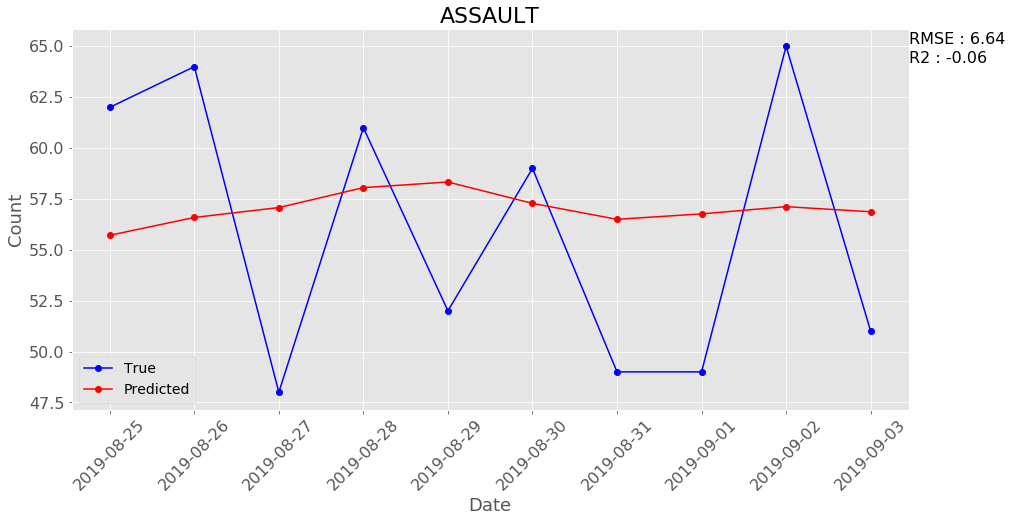

In [42]:
true_values = arima_df_day["ASSAULT"][-10:]
dates = arima_df_day["Date"][-10:]

# True values vs predicted
custom_functions.plot_true_vs_predicted(true_values, forecast_ass, dates, title = "ASSAULT")

ARIMA(15,0,0) can predict ASSAULT with the R2 value of -0.06 which means model is worse than fitting mean to the data. RMSE is 16.57.

### First order difference of the ASSAULT

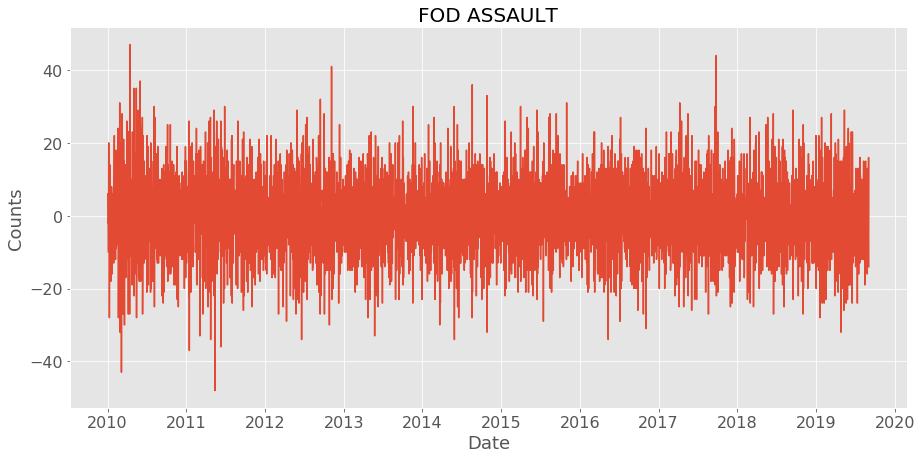

In [43]:
differenced_ass = custom_functions.difference(arima_df_day["ASSAULT"], interval = 1)
custom_functions.sequence_plot(differenced_ass, arima_df_day["Date"][1:], title = "FOD ASSAULT")

In [44]:
forecast_ass1 = custom_functions.fit_ARIMA(series, series.index, order = (14, 1, 0), trend = "nc", 
                                           title = "FOD ASSAULT", print_summary = True)

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi


                             ARIMA Model Results                              
Dep. Variable:              D.ASSAULT   No. Observations:                 3522
Model:                ARIMA(14, 1, 0)   Log Likelihood              -12716.344
Method:                       css-mle   S.D. of innovations              8.948
Date:                Sun, 03 Nov 2019   AIC                          25462.689
Time:                        21:10:41   BIC                          25555.190
Sample:                    01-01-1970   HQIC                         25495.691
                         - 01-01-1970                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
ar.L1.D.ASSAULT     -0.7456      0.017    -44.324      0.000      -0.779      -0.713
ar.L2.D.ASSAULT     -0.6520      0.021    -31.258      0.000      -0.693      -0.611
ar.L3.D.ASSAULT     -0.5985 

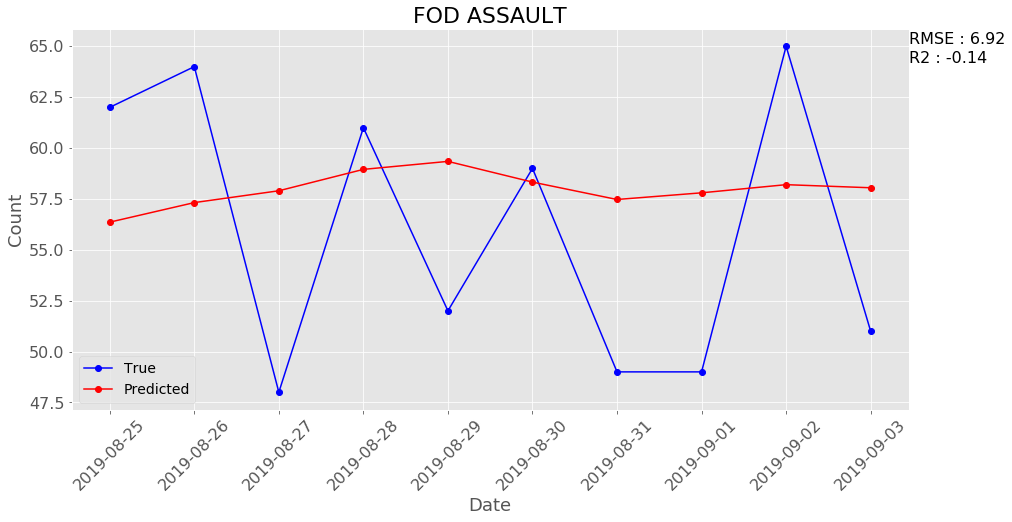

In [45]:
custom_functions.plot_true_vs_predicted(true_values, forecast_ass1, dates, title = "FOD ASSAULT")

FOD of the data produces worse model than the Model fitted on the original data

## ROBBERY

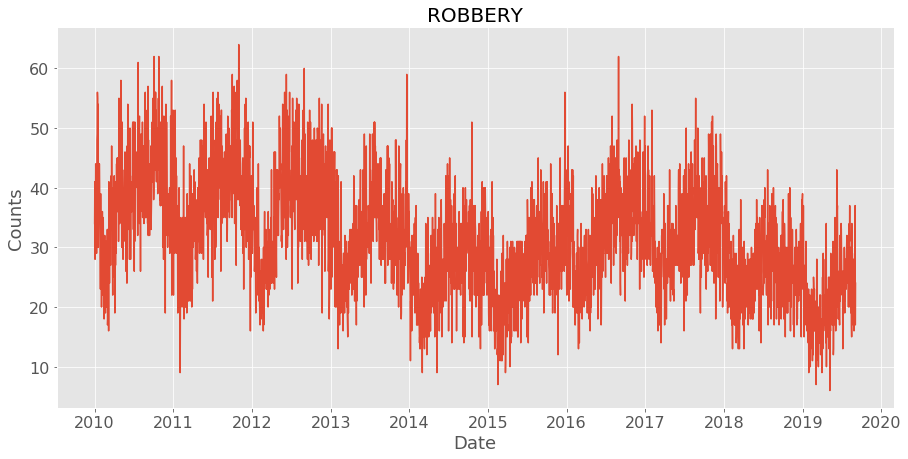

In [46]:
custom_functions.sequence_plot(arima_df_day["ROBBERY"], arima_df_day["Date"], "ROBBERY")

### Plotting ACF and PACF to decide the model

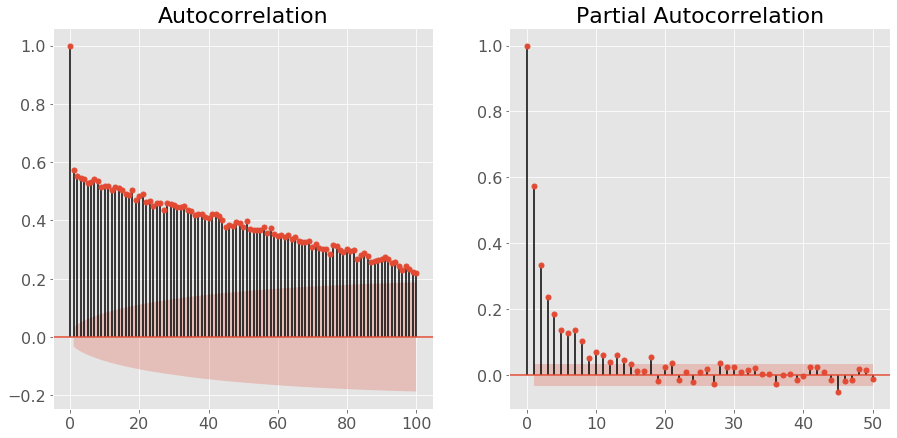

In [47]:
custom_functions.plot_ACF_PACF(arima_df_day["ROBBERY"])

Choosing ARIMA(15, 0, 0) Model as 15 lags are popping out in PACF plot and there is a gradual decrease in the ACF plot which suggests taking AR terms.

### Fitting ARIMA(15, 0, 0) to ROBBERY

In [48]:
series = arima_df_day["ROBBERY"][:-10]
series.index = arima_df_day.index[:-10]
forecast_rob = custom_functions.fit_ARIMA(series, series.index, order = (15, 0, 0), title = "ROBBERY", 
                                          print_summary = True)

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi


                              ARMA Model Results                              
Dep. Variable:                ROBBERY   No. Observations:                 3523
Model:                    ARMA(15, 0)   Log Likelihood              -11666.747
Method:                       css-mle   S.D. of innovations              6.635
Date:                Sun, 03 Nov 2019   AIC                          23367.494
Time:                        21:11:28   BIC                          23472.335
Sample:                    01-01-1970   HQIC                         23404.898
                         - 01-01-1970                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             31.4771      1.556     20.234      0.000      28.428      34.526
ar.L1.ROBBERY      0.1621      0.017      9.628      0.000       0.129       0.195
ar.L2.ROBBERY      0.1040      0.017

### Evaluating the model

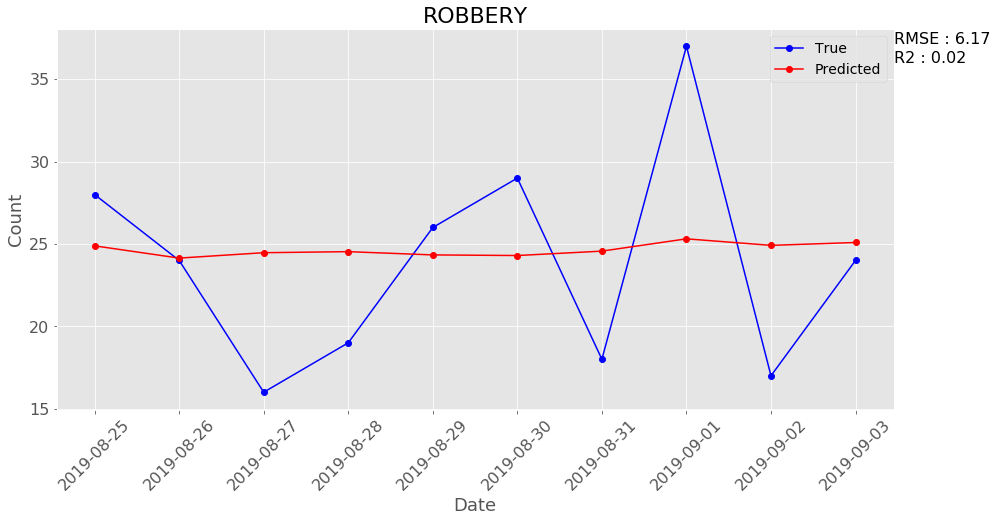

In [49]:
true_values = arima_df_day["ROBBERY"][-10:]
dates = arima_df_day["Date"][-10:]
custom_functions.plot_true_vs_predicted(true_values, forecast_rob, dates, title = "ROBBERY")

ARIMA(15,0,0) can predict CRIMINAL DAMAGE with the R2 value of 0.02 which means model explains 2% of the variation in the model. RMSE is 6.17.

### First order difference of the ROBBERY

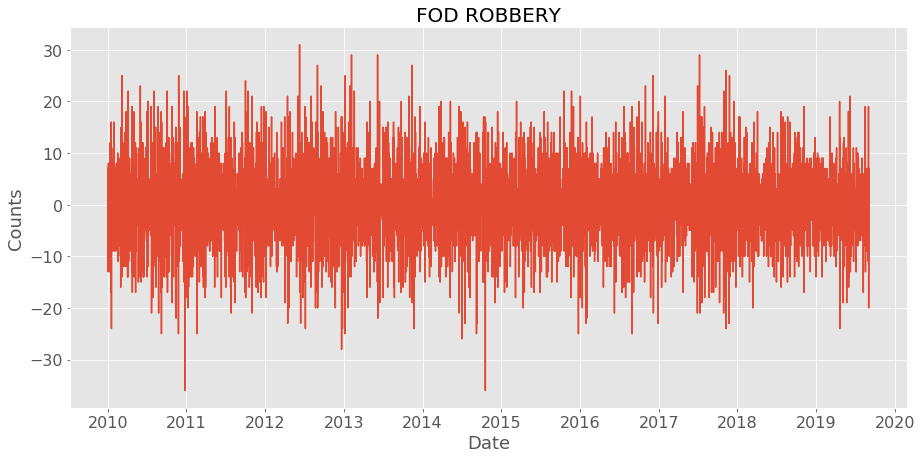

In [50]:
differenced_rob = custom_functions.difference(arima_df_day["ROBBERY"], interval = 1)
custom_functions.sequence_plot(differenced_rob, arima_df_day["Date"][1:], title = "FOD ROBBERY")

In [51]:
forecast_rob1 = custom_functions.fit_ARIMA(series, series.index, order = (14, 1, 0), trend = "nc", 
                                           title = "FOD ROBBERY", print_summary = True)

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi


                             ARIMA Model Results                              
Dep. Variable:              D.ROBBERY   No. Observations:                 3522
Model:                ARIMA(14, 1, 0)   Log Likelihood              -11673.261
Method:                       css-mle   S.D. of innovations              6.654
Date:                Sun, 03 Nov 2019   AIC                          23376.522
Time:                        21:12:28   BIC                          23469.024
Sample:                    01-01-1970   HQIC                         23409.524
                         - 01-01-1970                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
ar.L1.D.ROBBERY     -0.8321      0.017    -49.415      0.000      -0.865      -0.799
ar.L2.D.ROBBERY     -0.7229      0.022    -33.063      0.000      -0.766      -0.680
ar.L3.D.ROBBERY     -0.6353 

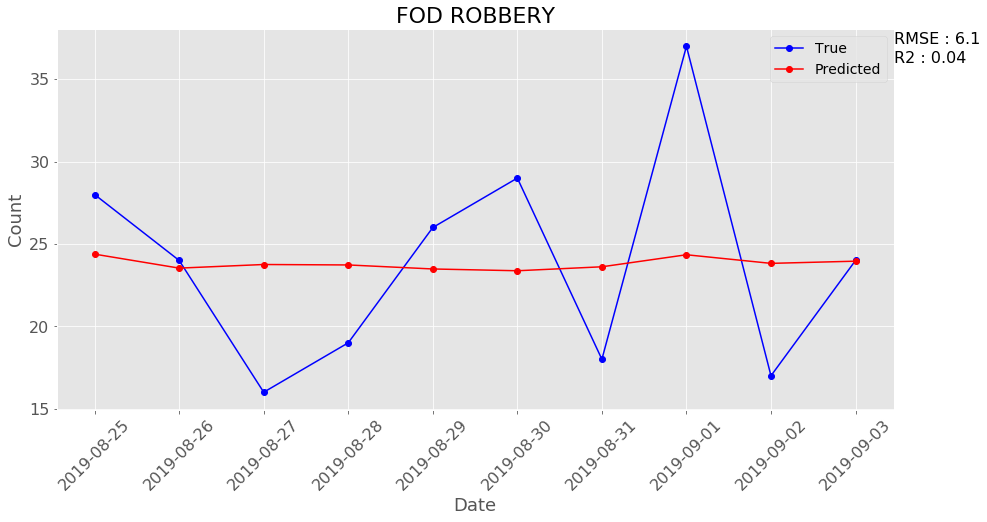

In [52]:
custom_functions.plot_true_vs_predicted(true_values, forecast_rob1, dates, title = "FOD ROBBERY")

FOD of the data with ARIMA model created better model than the original data. There is 2% increase in R2 value.

## WEAPONS VIOLATION

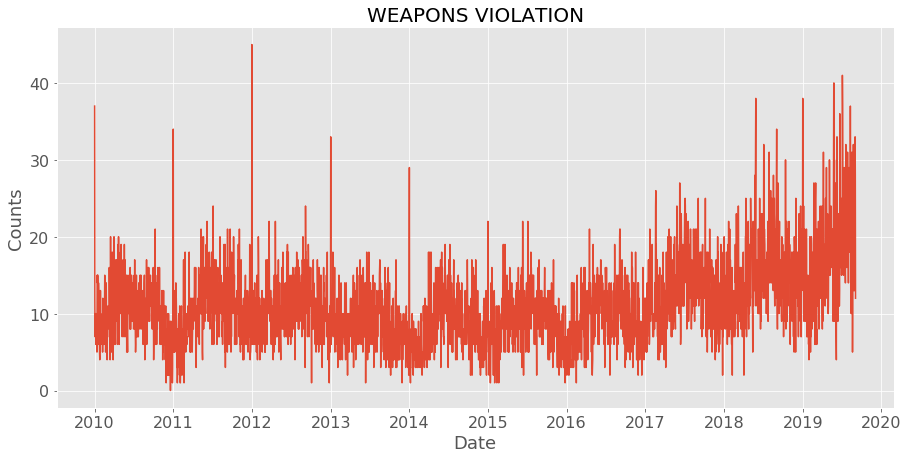

In [53]:
custom_functions.sequence_plot(arima_df_day["WEAPONS VIOLATION"], arima_df_day["Date"], "WEAPONS VIOLATION")

### Plotting ACF and PACF to decide the model

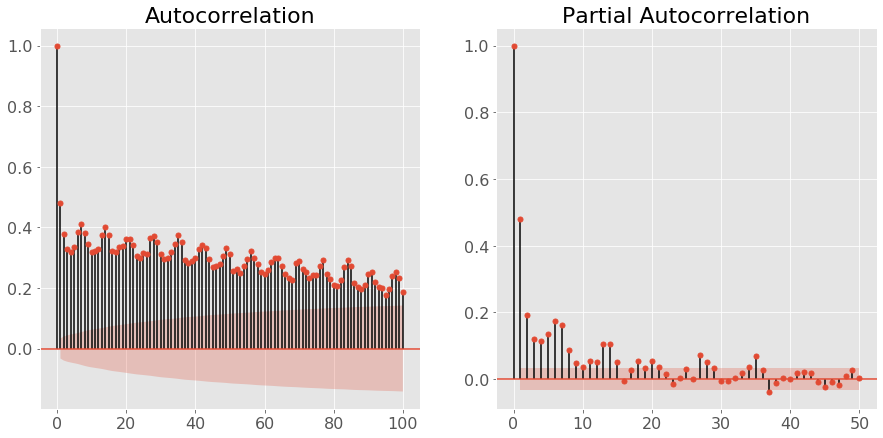

In [54]:
custom_functions.plot_ACF_PACF(arima_df_day["WEAPONS VIOLATION"])

Choosing ARIMA(15, 0, 0) Model as 15 lags are popping out in PACF plot and there is a gradual decrease in the ACF plot which suggests taking AR terms.

### Fitting ARIMA(15, 0, 0) to WEAPONS VIOLATION

In [55]:
series = arima_df_day["WEAPONS VIOLATION"][:-10]
series.index = arima_df_day.index[:-10]
forecast_wea = custom_functions.fit_ARIMA(series, series.index, order = (15, 0, 0), title = "WEAPONS VIOLATION", 
                                          print_summary = True)

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi


                              ARMA Model Results                              
Dep. Variable:      WEAPONS VIOLATION   No. Observations:                 3523
Model:                    ARMA(15, 0)   Log Likelihood              -10004.686
Method:                       css-mle   S.D. of innovations              4.140
Date:                Sun, 03 Nov 2019   AIC                          20043.372
Time:                        21:13:11   BIC                          20148.212
Sample:                    01-01-1970   HQIC                         20080.776
                         - 01-01-1970                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       11.2256      0.653     17.190      0.000       9.946      12.506
ar.L1.WEAPONS VIOLATION      0.2339      0.017     13.813      0.000       0.201       0.

### Evaluating the model

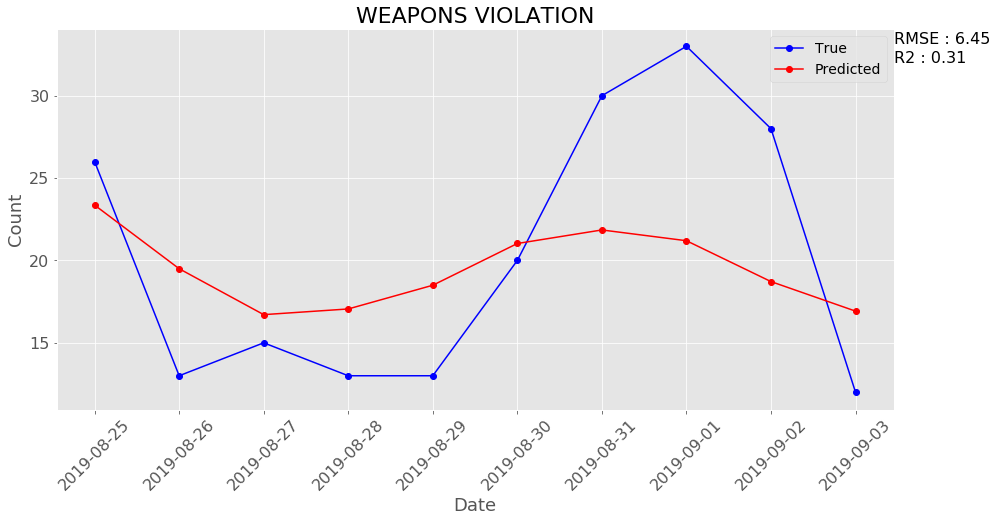

In [56]:
true_values = arima_df_day["WEAPONS VIOLATION"][-10:]
dates = arima_df_day["Date"][-10:]
custom_functions.plot_true_vs_predicted(true_values, forecast_wea, dates, title = "WEAPONS VIOLATION")

ARIMA(15,0,0) can predict WEAPONS VIOLATION with the R2 value of 0.31 which means model explains 31% of the variation in the model. RMSE is 6.45.

### First order difference of the WEAPONS VIOLATION <a id = 'wp_ARIMA'></a> 

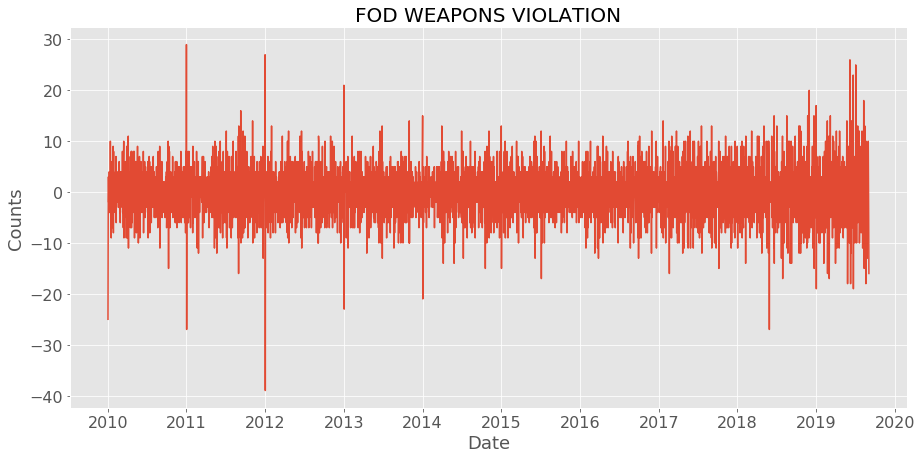

In [57]:
differenced_wea = custom_functions.difference(arima_df_day["WEAPONS VIOLATION"], interval = 1)
custom_functions.sequence_plot(differenced_wea, arima_df_day["Date"][1:], title = "FOD WEAPONS VIOLATION")

In [58]:
forecast_wea1 = custom_functions.fit_ARIMA(series, series.index, order = (14, 1, 0), trend = "nc", 
                                           title = "FOD WEAPONS VIOLATION", print_summary = True)

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi


                              ARIMA Model Results                              
Dep. Variable:     D.WEAPONS VIOLATION   No. Observations:                 3522
Model:                 ARIMA(14, 1, 0)   Log Likelihood              -10014.334
Method:                        css-mle   S.D. of innovations              4.154
Date:                 Sun, 03 Nov 2019   AIC                          20058.668
Time:                         21:14:05   BIC                          20151.170
Sample:                     01-01-1970   HQIC                         20091.670
                          - 01-01-1970                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
ar.L1.D.WEAPONS VIOLATION     -0.7585      0.017    -44.808      0.000      -0.792      -0.725
ar.L2.D.WEAPONS VIOLATION     -0.6930      0.021    -32.818      0.000     

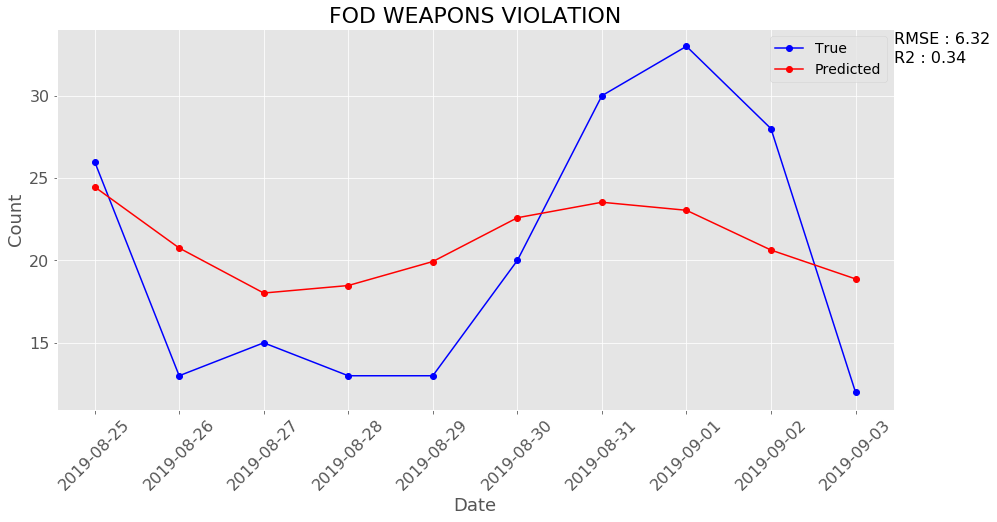

In [59]:
custom_functions.plot_true_vs_predicted(true_values, forecast_wea1, dates, title = "FOD WEAPONS VIOLATION")

## OTHER OFFENSE

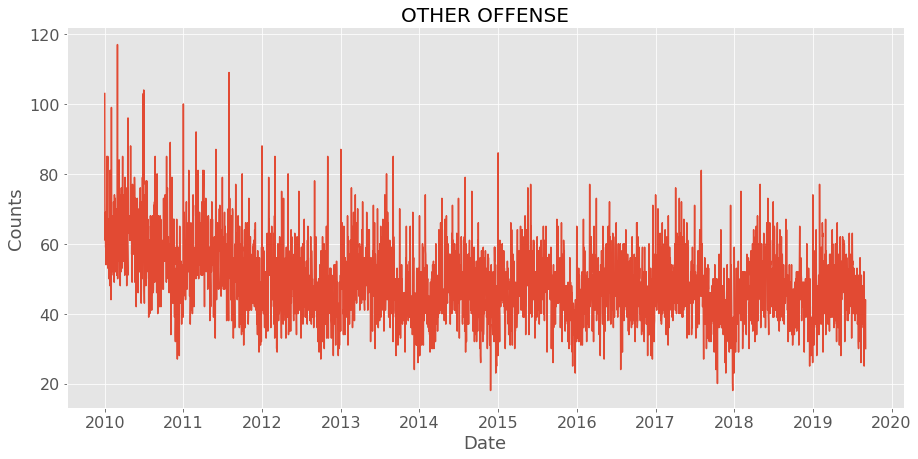

In [60]:
custom_functions.sequence_plot(arima_df_day["OTHER OFFENSE"], arima_df_day["Date"], "OTHER OFFENSE")

### Plotting ACF and PACF to decide the model

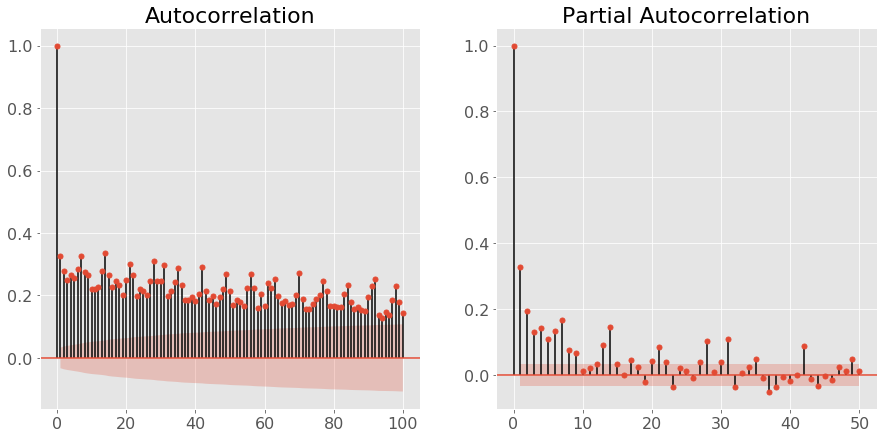

In [61]:
custom_functions.plot_ACF_PACF(arima_df_day["OTHER OFFENSE"])

Choosing ARIMA(15, 0, 0) Model as 15 lags are popping out in PACF plot and there is a gradual decrease in the ACF plot which suggests taking AR terms.

### Fitting ARIMA(15, 0, 0) to OTHER OFFENSE

In [62]:
series = arima_df_day["OTHER OFFENSE"][:-10]
series.index = arima_df_day.index[:-10]
forecast_oo = custom_functions.fit_ARIMA(series, series.index, order = (15, 0, 0), title = "OTHER OFFENSE", 
                                          print_summary = True)

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi


                              ARMA Model Results                              
Dep. Variable:          OTHER OFFENSE   No. Observations:                 3523
Model:                    ARMA(15, 0)   Log Likelihood              -12865.757
Method:                       css-mle   S.D. of innovations              9.326
Date:                Sun, 03 Nov 2019   AIC                          25765.514
Time:                        21:14:52   BIC                          25870.355
Sample:                    01-01-1970   HQIC                         25802.918
                         - 01-01-1970                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   49.3366      1.064     46.374      0.000      47.251      51.422
ar.L1.OTHER OFFENSE      0.1276      0.017      7.564      0.000       0.095       0.161
ar.L2.OTHER 

### Evaluating the model

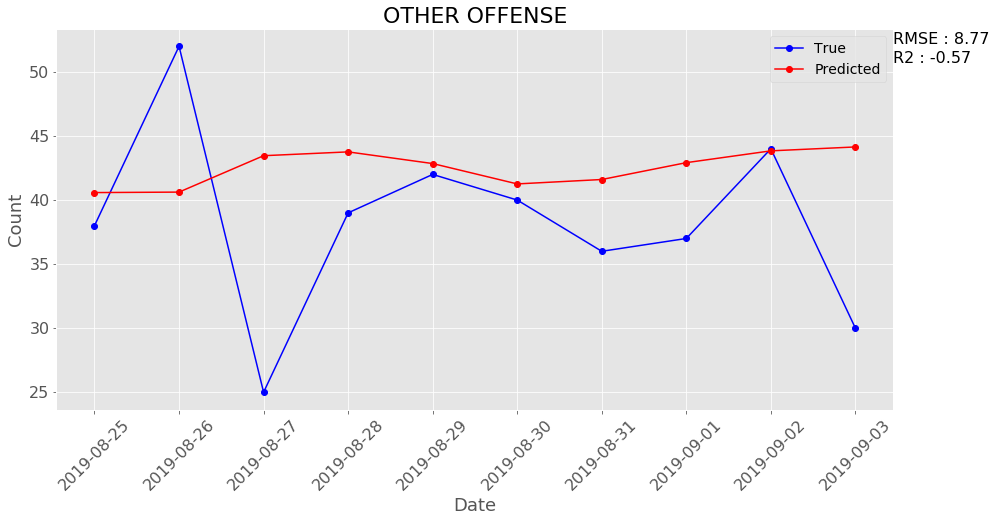

In [63]:
true_values = arima_df_day["OTHER OFFENSE"][-10:]
dates = arima_df_day["Date"][-10:]
custom_functions.plot_true_vs_predicted(true_values, forecast_oo, dates, title = "OTHER OFFENSE")

ARIMA(15,0,0) can predict OTHER OFFENSE with the R2 value of -0.57 which means model is worse than fitting the mean to the data. RMSE is 8.77.

### First order difference of the OTHER OFFENSE

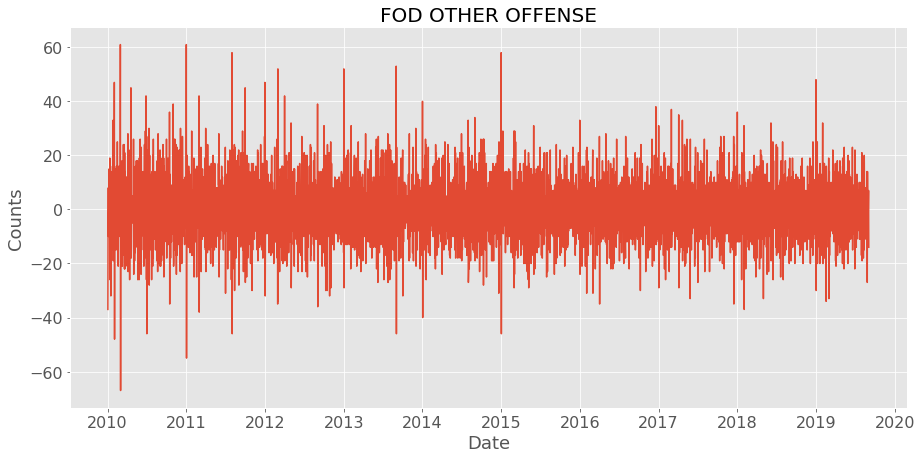

In [64]:
differenced_oo = custom_functions.difference(arima_df_day["OTHER OFFENSE"], interval = 1)
custom_functions.sequence_plot(differenced_oo, arima_df_day["Date"][1:], title = "FOD OTHER OFFENSE")

In [65]:
forecast_oo1 = custom_functions.fit_ARIMA(series, series.index, order = (14, 1, 0), trend = "nc", 
                                           title = "FOD OTHER OFFENSE", print_summary = True)

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi


                             ARIMA Model Results                              
Dep. Variable:        D.OTHER OFFENSE   No. Observations:                 3522
Model:                ARIMA(14, 1, 0)   Log Likelihood              -12878.374
Method:                       css-mle   S.D. of innovations              9.368
Date:                Sun, 03 Nov 2019   AIC                          25786.748
Time:                        21:15:47   BIC                          25879.250
Sample:                    01-01-1970   HQIC                         25819.750
                         - 01-01-1970                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
ar.L1.D.OTHER OFFENSE     -0.8625      0.017    -51.147      0.000      -0.896      -0.829
ar.L2.D.OTHER OFFENSE     -0.7839      0.022    -35.608      0.000      -0.827      -0.741
ar.L

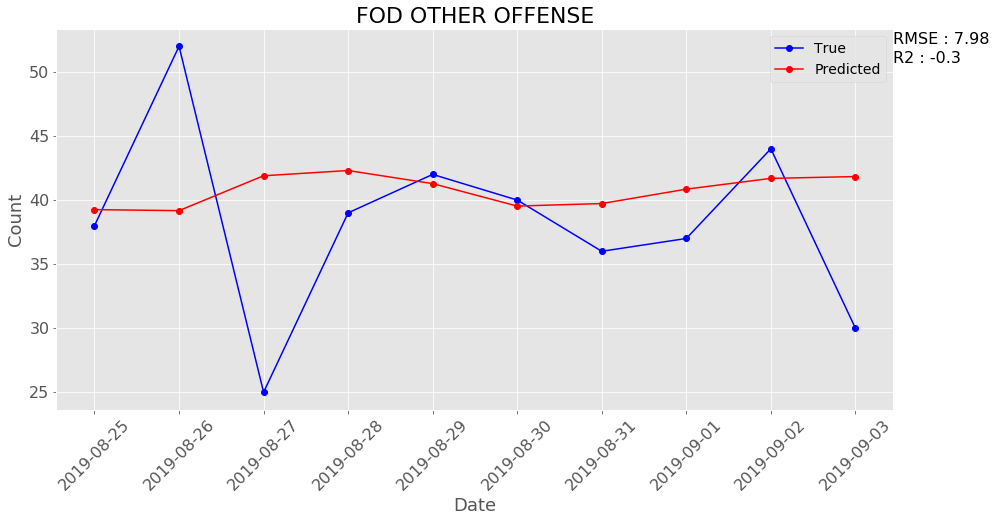

In [66]:
custom_functions.plot_true_vs_predicted(true_values, forecast_oo1, dates, title = "FOD OTHER OFFENSE")

Model with FOD data is performing better than the former model. But these two models are useless as they give negative R2 value.

## BURGLARY

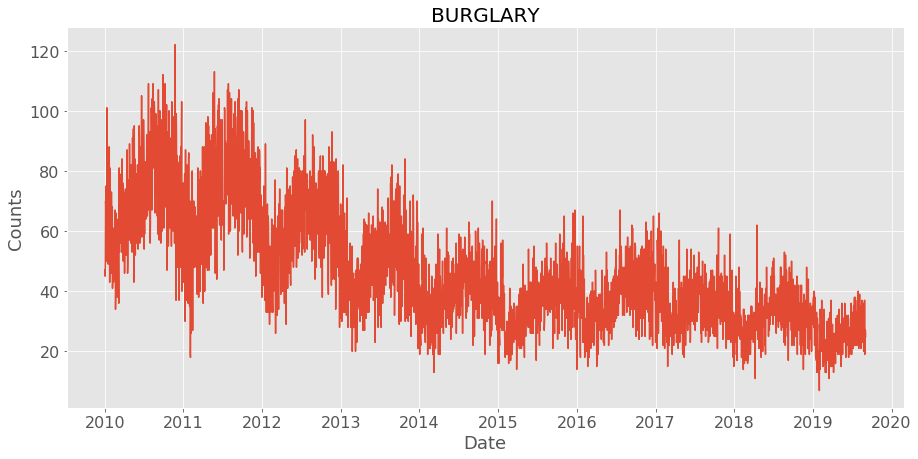

In [67]:
custom_functions.sequence_plot(arima_df_day["BURGLARY"], arima_df_day["Date"], "BURGLARY")

### Plotting ACF and PACF to decide the model

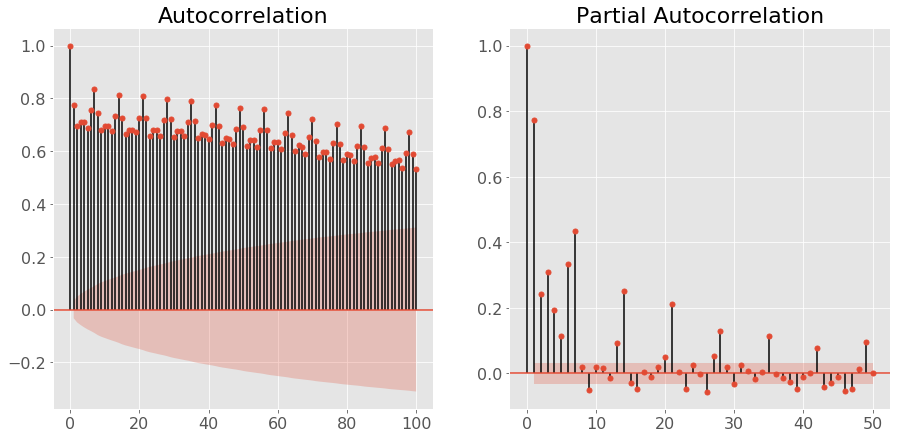

In [68]:
custom_functions.plot_ACF_PACF(arima_df_day["BURGLARY"])

Choosing ARIMA(15, 0, 0) Model as 15 lags are popping out in PACF plot and there is a gradual decrease in the ACF plot which suggests taking AR terms. BUt AR15 term was insignificant so taking AR14.

### Fitting ARIMA(14, 0, 0) to BURGLARY

In [69]:
series = arima_df_day["BURGLARY"][:-10]
series.index = arima_df_day.index[:-10]
forecast_bur = custom_functions.fit_ARIMA(series, series.index, order = (14, 0, 0), title = "BURGLARY", 
                                          print_summary = True)

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi


                              ARMA Model Results                              
Dep. Variable:               BURGLARY   No. Observations:                 3523
Model:                    ARMA(14, 0)   Log Likelihood              -12835.123
Method:                       css-mle   S.D. of innovations              9.241
Date:                Sun, 03 Nov 2019   AIC                          25702.247
Time:                        21:16:39   BIC                          25800.920
Sample:                    01-01-1970   HQIC                         25737.450
                         - 01-01-1970                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              46.6196      6.530      7.139      0.000      33.821      59.418
ar.L1.BURGLARY      0.2166      0.016     13.281      0.000       0.185       0.249
ar.L2.BURGLARY      0.0172      

### Evaluating the model

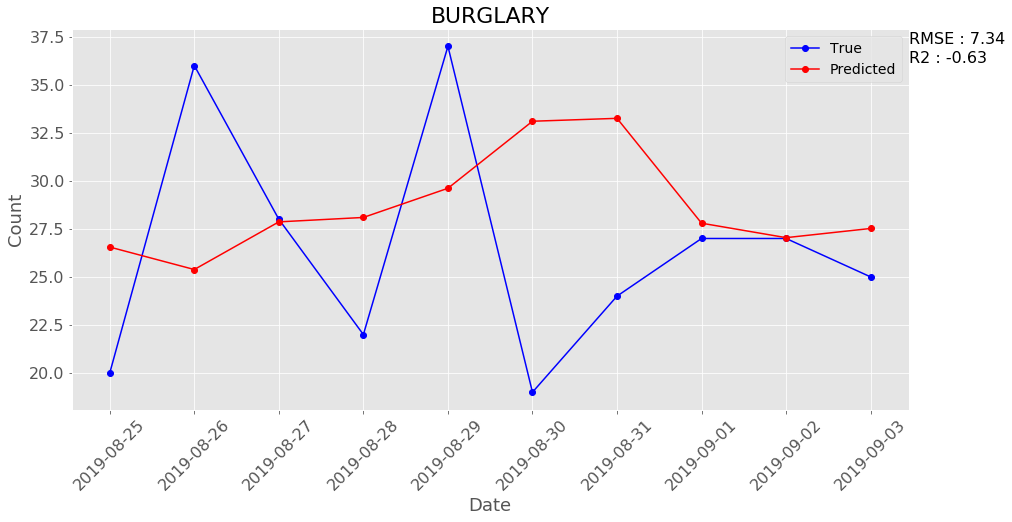

In [70]:
true_values = arima_df_day["BURGLARY"][-10:]
dates = arima_df_day["Date"][-10:]
custom_functions.plot_true_vs_predicted(true_values, forecast_bur, dates, title = "BURGLARY")

ARIMA(14,0,0) can predict BURGLARY with the R2 value of -0.63 which means model is worse than fitting the mean to the data. RMSE is 7.34.

### First order difference of the BURGLARY

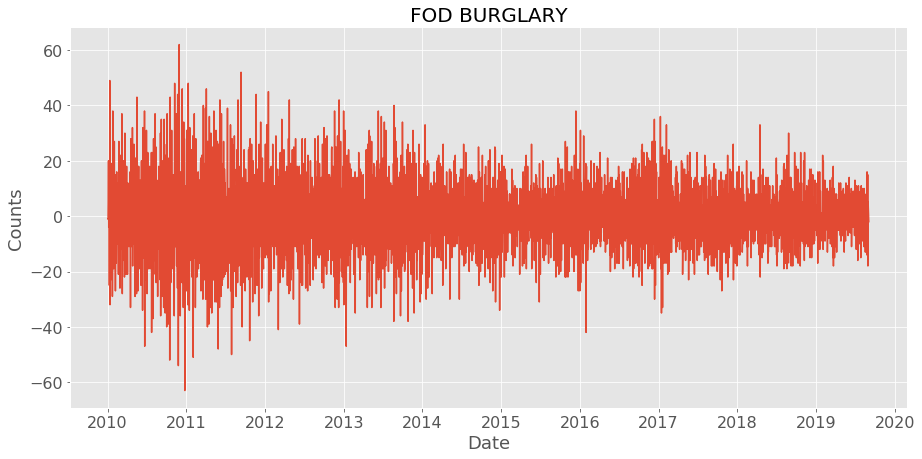

In [71]:
differenced_bur = custom_functions.difference(arima_df_day["BURGLARY"], interval = 1)
custom_functions.sequence_plot(differenced_bur, arima_df_day["Date"][1:], title = "FOD BURGLARY")

In [72]:
forecast_bur1 = custom_functions.fit_ARIMA(series, series.index, order = (15, 1, 0), trend = "nc", 
                                           title = "FOD BURGLARY", print_summary = True)

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi


                             ARIMA Model Results                              
Dep. Variable:             D.BURGLARY   No. Observations:                 3522
Model:                ARIMA(15, 1, 0)   Log Likelihood              -12828.985
Method:                       css-mle   S.D. of innovations              9.236
Date:                Sun, 03 Nov 2019   AIC                          25689.971
Time:                        21:17:42   BIC                          25788.640
Sample:                    01-01-1970   HQIC                         25725.173
                         - 01-01-1970                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ar.L1.D.BURGLARY     -0.7755      0.017    -46.037      0.000      -0.809      -0.743
ar.L2.D.BURGLARY     -0.7440      0.021    -34.917      0.000      -0.786      -0.702
ar.L3.D.BURGLARY     -0.

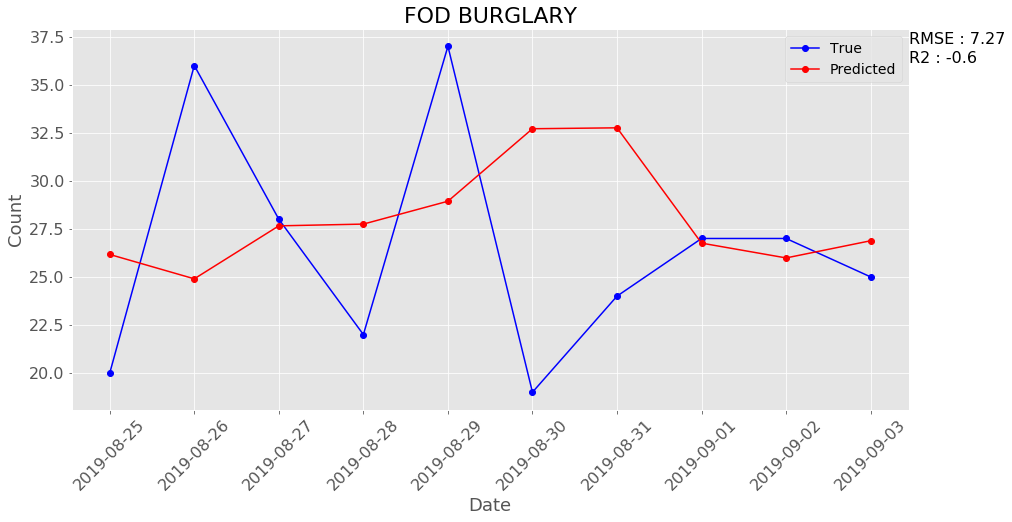

In [73]:
custom_functions.plot_true_vs_predicted(true_values, forecast_bur1, dates, title = "FOD BURGLARY")

Both models fitted above are useless.

## THEFT

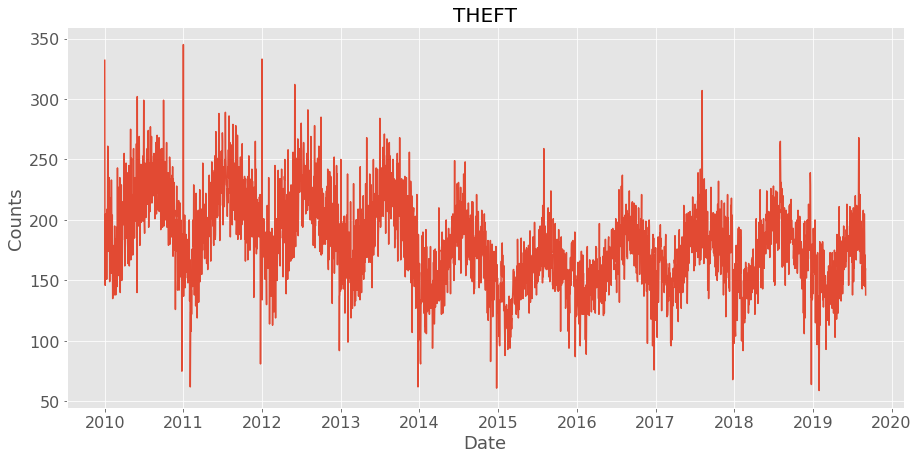

In [74]:
custom_functions.sequence_plot(arima_df_day["THEFT"], arima_df_day["Date"], "THEFT")

### Plotting ACF and PACF to decide the model

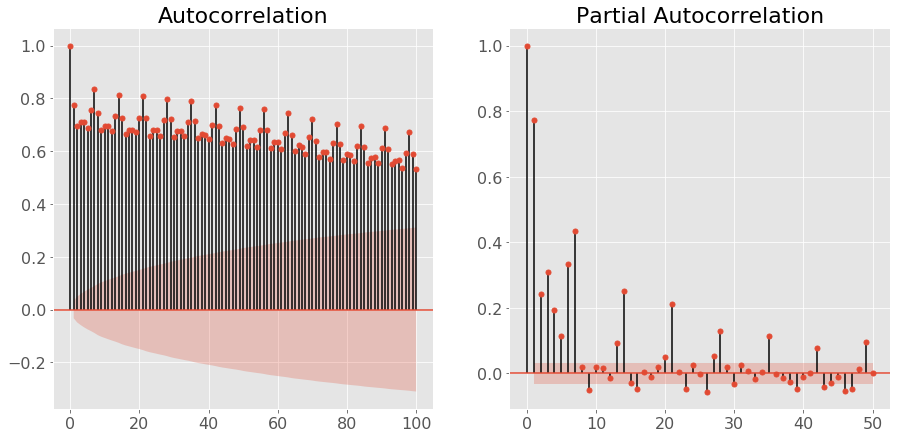

In [75]:
custom_functions.plot_ACF_PACF(arima_df_day["BURGLARY"])

Choosing ARIMA(15, 0, 0) Model as 15 lags are popping out in PACF plot and there is a gradual decrease in the ACF plot which suggests taking AR terms.

### Fitting ARIMA(15, 0, 0) to THEFT

In [76]:
series = arima_df_day["THEFT"][:-10]
series.index = arima_df_day.index[:-10]
forecast_the = custom_functions.fit_ARIMA(series, series.index, order = (15, 0, 0), title = "THEFT", 
                                          print_summary = True)

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi


                              ARMA Model Results                              
Dep. Variable:                  THEFT   No. Observations:                 3523
Model:                    ARMA(15, 0)   Log Likelihood              -15911.615
Method:                       css-mle   S.D. of innovations             22.135
Date:                Sun, 03 Nov 2019   AIC                          31857.230
Time:                        21:18:46   BIC                          31962.070
Sample:                    01-01-1970   HQIC                         31894.634
                         - 01-01-1970                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          182.3535      6.782     26.886      0.000     169.060     195.647
ar.L1.THEFT      0.2550      0.017     15.089      0.000       0.222       0.288
ar.L2.THEFT      0.0898      0.017      5.30

### Evaluating the model

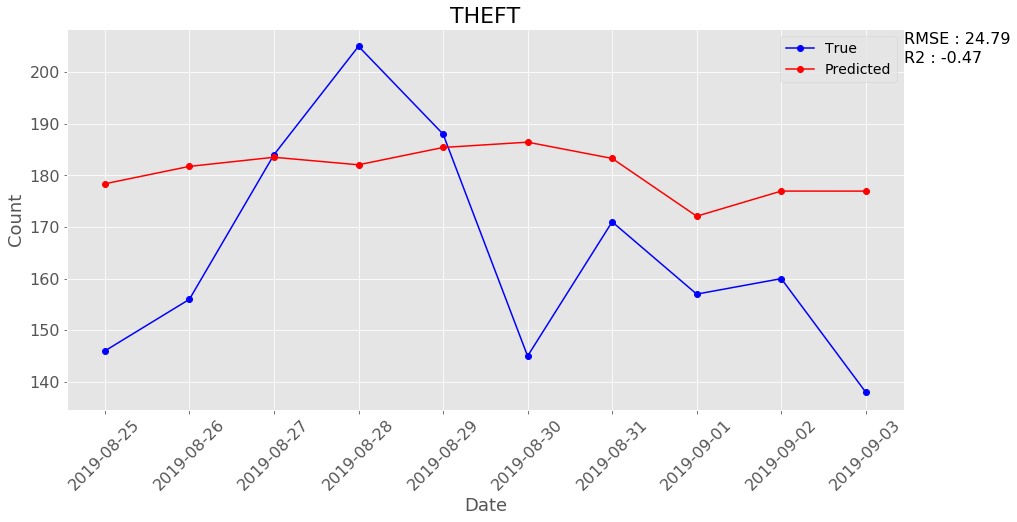

In [77]:
true_values = arima_df_day["THEFT"][-10:]
dates = arima_df_day["Date"][-10:]
custom_functions.plot_true_vs_predicted(true_values, forecast_the, dates, title = "THEFT")

ARIMA(15,0,0) can predict THEFT with the R2 value of -0.47 which means model is worse than fitting the mean to the data. RMSE is 24.79.

### First order difference of the THEFT

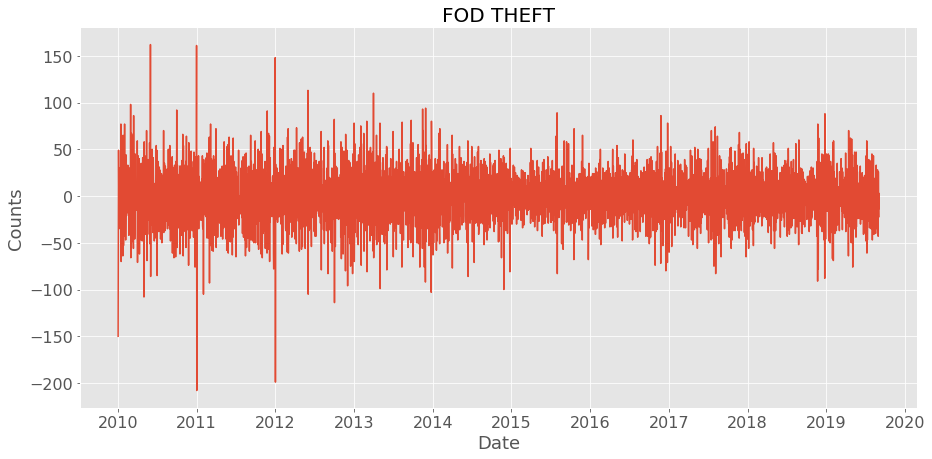

In [78]:
differenced_the = custom_functions.difference(arima_df_day["THEFT"], interval = 1)
custom_functions.sequence_plot(differenced_the, arima_df_day["Date"][1:], title = "FOD THEFT")

In [79]:
forecast_the1 = custom_functions.fit_ARIMA(series, series.index, order = (15, 1, 0), trend = "nc", 
                                           title = "FOD THEFT", print_summary = True)

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi


                             ARIMA Model Results                              
Dep. Variable:                D.THEFT   No. Observations:                 3522
Model:                ARIMA(15, 1, 0)   Log Likelihood              -15912.794
Method:                       css-mle   S.D. of innovations             22.172
Date:                Sun, 03 Nov 2019   AIC                          31857.587
Time:                        21:19:56   BIC                          31956.256
Sample:                    01-01-1970   HQIC                         31892.790
                         - 01-01-1970                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
ar.L1.D.THEFT     -0.7426      0.017    -43.888      0.000      -0.776      -0.709
ar.L2.D.THEFT     -0.6395      0.021    -30.395      0.000      -0.681      -0.598
ar.L3.D.THEFT     -0.5596      0.023

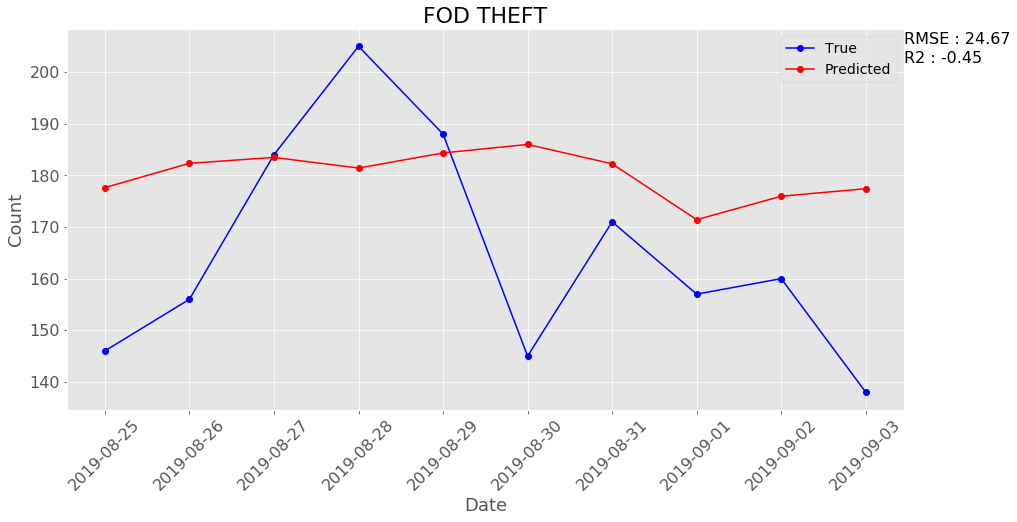

In [80]:
custom_functions.plot_true_vs_predicted(true_values, forecast_the1, dates, title = "FOD THEFT")

Both models fitted above are useless.

## CRIMINAL TRESPASS

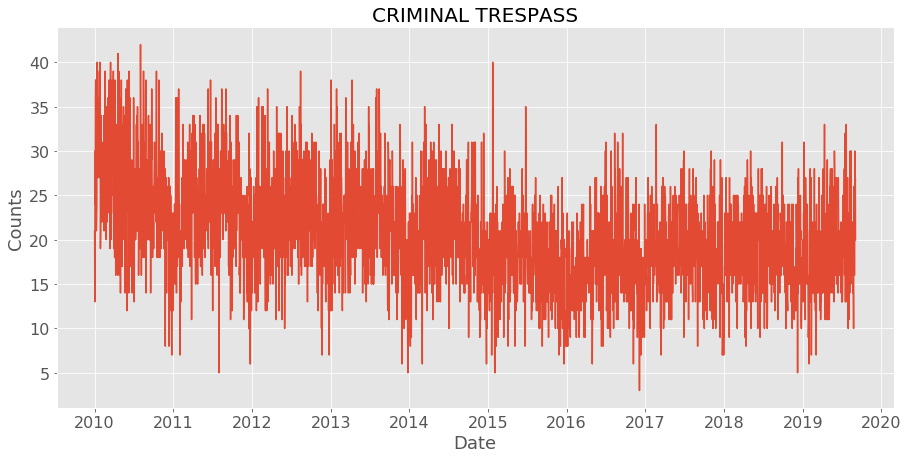

In [81]:
custom_functions.sequence_plot(arima_df_day["CRIMINAL TRESPASS"], arima_df_day["Date"], "CRIMINAL TRESPASS")

### Plotting ACF and PACF to decide the model

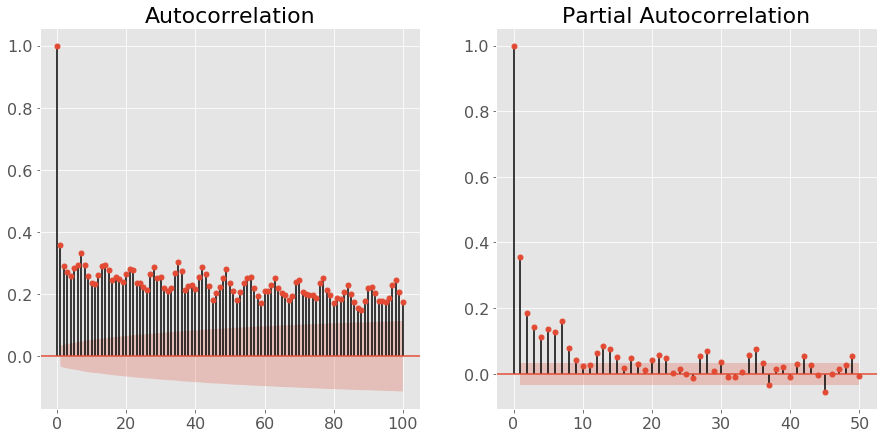

In [82]:
custom_functions.plot_ACF_PACF(arima_df_day["CRIMINAL TRESPASS"])

Choosing ARIMA(15, 0, 0) Model as 15 lags are popping out in PACF plot and there is a gradual decrease in the ACF plot which suggests taking AR terms.

### Fitting ARIMA(15, 0, 0) to CRIMINAL TRESPASS

In [83]:
series = arima_df_day["CRIMINAL TRESPASS"][:-10]
series.index = arima_df_day.index[:-10]
forecast_ct = custom_functions.fit_ARIMA(series, series.index, order = (15, 0, 0), title = "CRIMINAL TRESPASS", 
                                          print_summary = True)

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi


                              ARMA Model Results                              
Dep. Variable:      CRIMINAL TRESPASS   No. Observations:                 3523
Model:                    ARMA(15, 0)   Log Likelihood              -10750.783
Method:                       css-mle   S.D. of innovations              5.117
Date:                Sun, 03 Nov 2019   AIC                          21535.566
Time:                        21:20:59   BIC                          21640.406
Sample:                    01-01-1970   HQIC                         21572.970
                         - 01-01-1970                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       20.5914      0.550     37.405      0.000      19.512      21.670
ar.L1.CRIMINAL TRESPASS      0.1587      0.017      9.432      0.000       0.126       0.

### Evaluating the model

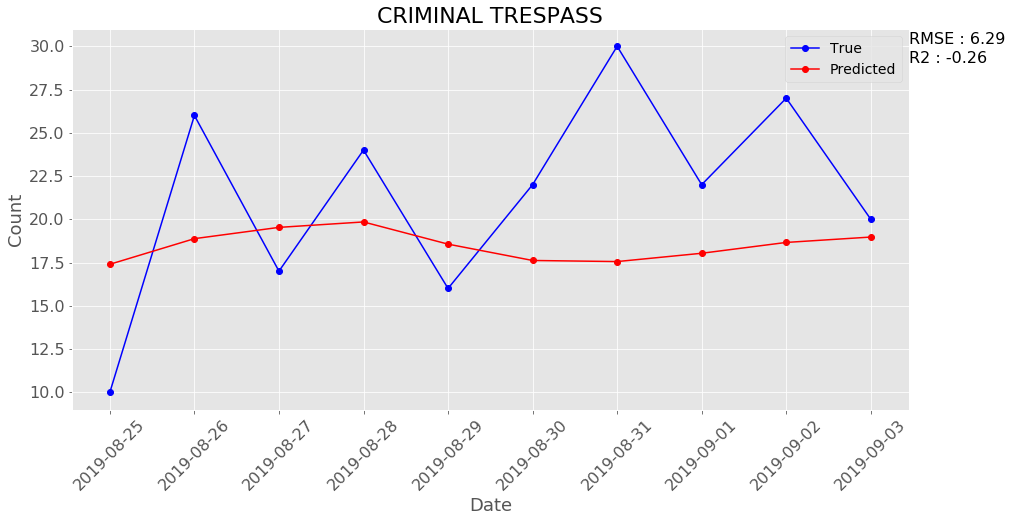

In [84]:
true_values = arima_df_day["CRIMINAL TRESPASS"][-10:]
dates = arima_df_day["Date"][-10:]
custom_functions.plot_true_vs_predicted(true_values, forecast_ct, dates, title = "CRIMINAL TRESPASS")

ARIMA(15,0,0) can predict CRIMINAL TRESPASS with the R2 value of -0.26 which means model is worse than fitting the mean to the data. RMSE is 6.29.

### First order difference of the CRIMINAL TRESPASS

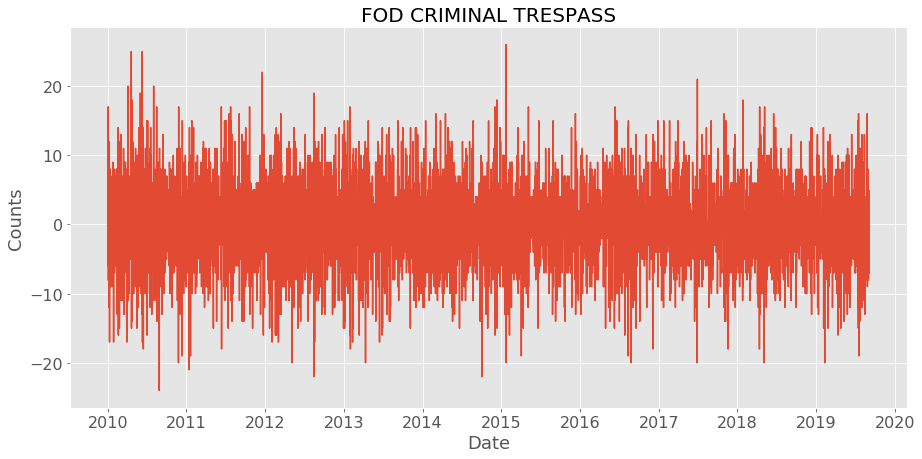

In [85]:
differenced_ct = custom_functions.difference(arima_df_day["CRIMINAL TRESPASS"], interval = 1)
custom_functions.sequence_plot(differenced_ct, arima_df_day["Date"][1:], title = "FOD CRIMINAL TRESPASS")

In [86]:
forecast_ct1 = custom_functions.fit_ARIMA(series, series.index, order = (15, 1, 0), trend = "nc", 
                                           title = "FOD CRIMINAL TRESPASS", print_summary = True)

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi


                              ARIMA Model Results                              
Dep. Variable:     D.CRIMINAL TRESPASS   No. Observations:                 3522
Model:                 ARIMA(15, 1, 0)   Log Likelihood              -10765.253
Method:                        css-mle   S.D. of innovations              5.142
Date:                 Sun, 03 Nov 2019   AIC                          21562.506
Time:                         21:21:59   BIC                          21661.174
Sample:                     01-01-1970   HQIC                         21597.708
                          - 01-01-1970                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
ar.L1.D.CRIMINAL TRESPASS     -0.8321      0.017    -49.386      0.000      -0.865      -0.799
ar.L2.D.CRIMINAL TRESPASS     -0.7677      0.022    -35.044      0.000     

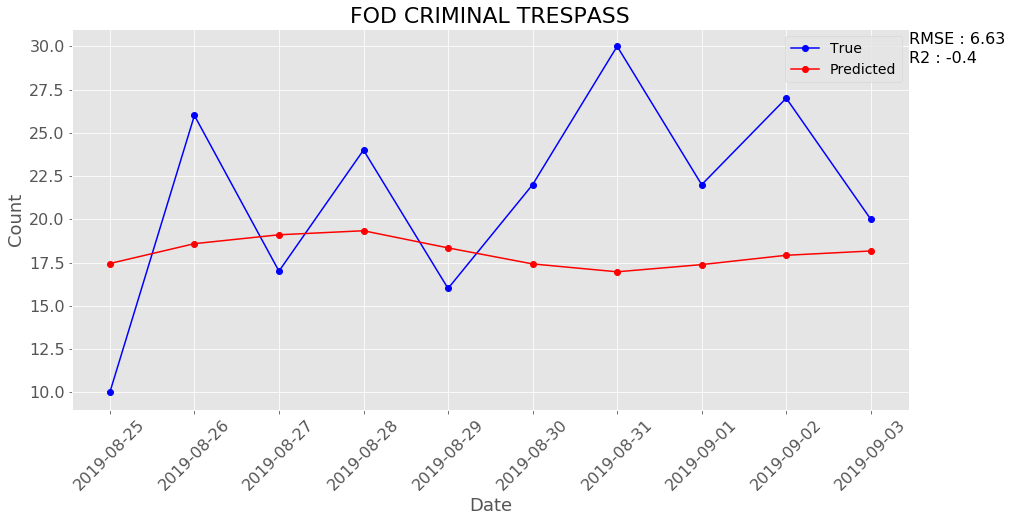

In [87]:
custom_functions.plot_true_vs_predicted(true_values, forecast_ct1, dates, title = "FOD CRIMINAL TRESPASS")

Both models fitted above are useless.

## DECEPTIVE PRACTICE

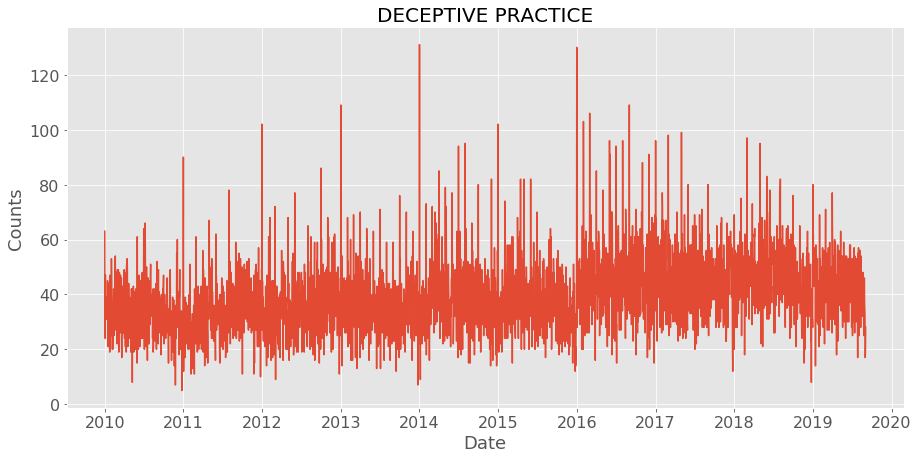

In [88]:
custom_functions.sequence_plot(arima_df_day["DECEPTIVE PRACTICE"], arima_df_day["Date"], "DECEPTIVE PRACTICE")

### Plotting ACF and PACF to decide the model

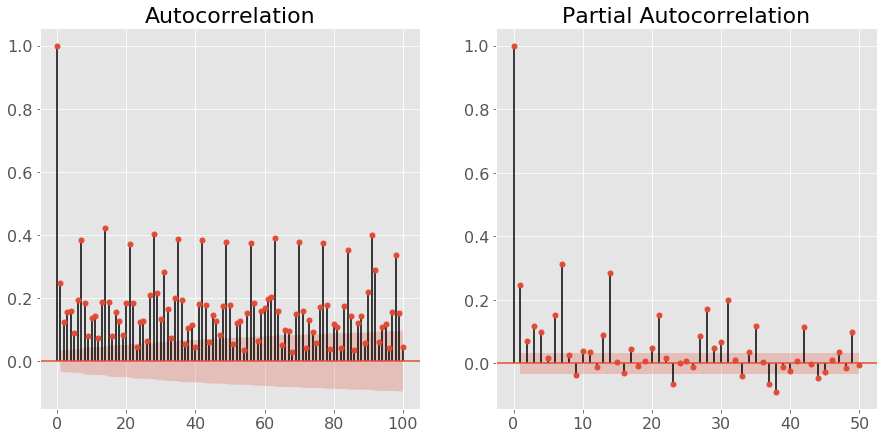

In [89]:
custom_functions.plot_ACF_PACF(arima_df_day["DECEPTIVE PRACTICE"])

Choosing ARIMA(15, 0, 0) Model as 15 lags are popping out in PACF plot and there is a gradual decrease in the ACF plot which suggests taking AR terms. AR15 was insignificant so trying AR14.

### Fitting ARIMA(14, 0, 0) to DECEPTIVE PRACTICE

In [90]:
series = arima_df_day["DECEPTIVE PRACTICE"][:-10]
series.index = arima_df_day.index[:-10]
forecast_dp = custom_functions.fit_ARIMA(series, series.index, order = (14, 0, 0), title = "DECEPTIVE PRACTICE", 
                                          print_summary = True)

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi


                              ARMA Model Results                              
Dep. Variable:     DECEPTIVE PRACTICE   No. Observations:                 3523
Model:                    ARMA(14, 0)   Log Likelihood              -13467.558
Method:                       css-mle   S.D. of innovations             11.062
Date:                Sun, 03 Nov 2019   AIC                          26967.116
Time:                        21:22:45   BIC                          27065.789
Sample:                    01-01-1970   HQIC                         27002.320
                         - 01-01-1970                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        40.0694      0.923     43.415      0.000      38.260      41.878
ar.L1.DECEPTIVE PRACTICE      0.1265      0.016      7.829      0.000       0.095     

### Evaluating the model

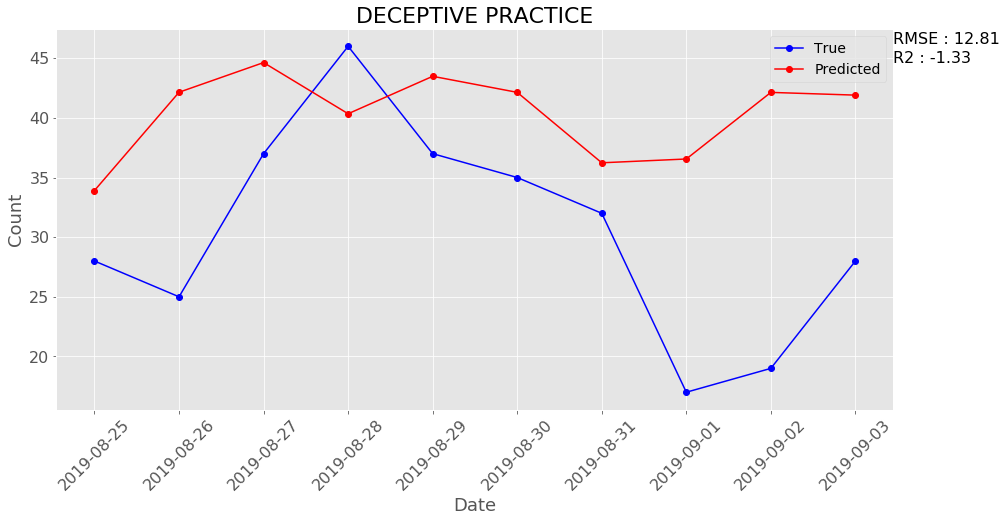

In [91]:
true_values = arima_df_day["DECEPTIVE PRACTICE"][-10:]
dates = arima_df_day["Date"][-10:]
custom_functions.plot_true_vs_predicted(true_values, forecast_dp, dates, title = "DECEPTIVE PRACTICE")

ARIMA(14,0,0) can predict DECEPTIVE PRACTICE with the R2 value of -1.33 which means model is worse than fitting the mean to the data. RMSE is 12.81.

### First order difference of the DECEPTIVE PRACTICE

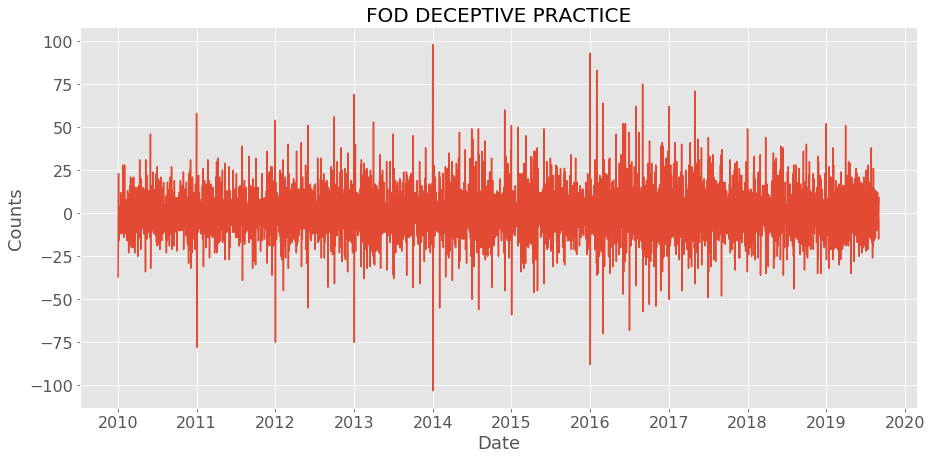

In [92]:
differenced_dp = custom_functions.difference(arima_df_day["DECEPTIVE PRACTICE"], interval = 1)
custom_functions.sequence_plot(differenced_dp, arima_df_day["Date"][1:], title = "FOD DECEPTIVE PRACTICE")

In [93]:
# Tried fitting ARIMA(14,1,0) but AR14 term was insignificant
forecast_dp1 = custom_functions.fit_ARIMA(series, series.index, order = (13, 1, 0), trend = "nc", 
                                           title = "FOD DECEPTIVE PRACTICE", print_summary = True)

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi


                              ARIMA Model Results                               
Dep. Variable:     D.DECEPTIVE PRACTICE   No. Observations:                 3522
Model:                  ARIMA(13, 1, 0)   Log Likelihood              -13486.632
Method:                         css-mle   S.D. of innovations             11.132
Date:                  Sun, 03 Nov 2019   AIC                          27001.264
Time:                          21:23:31   BIC                          27087.599
Sample:                      01-01-1970   HQIC                         27032.066
                           - 01-01-1970                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
ar.L1.D.DECEPTIVE PRACTICE     -0.8572      0.016    -53.294      0.000      -0.889      -0.826
ar.L2.D.DECEPTIVE PRACTICE     -0.8023      0.021    -38.673    

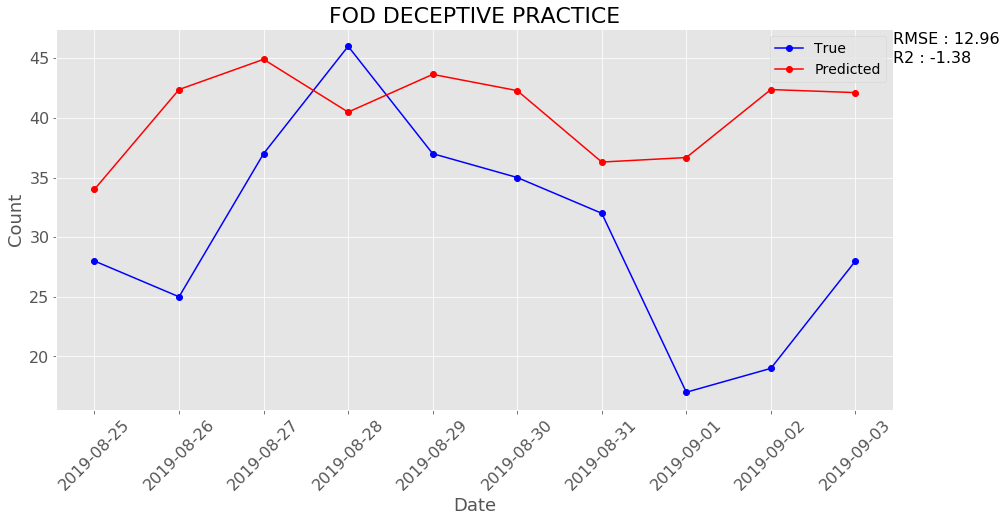

In [94]:
custom_functions.plot_true_vs_predicted(true_values, forecast_dp1, dates, title = "FOD DECEPTIVE PRACTICE")

Both models fitted above are useless.

## NARCOTICS

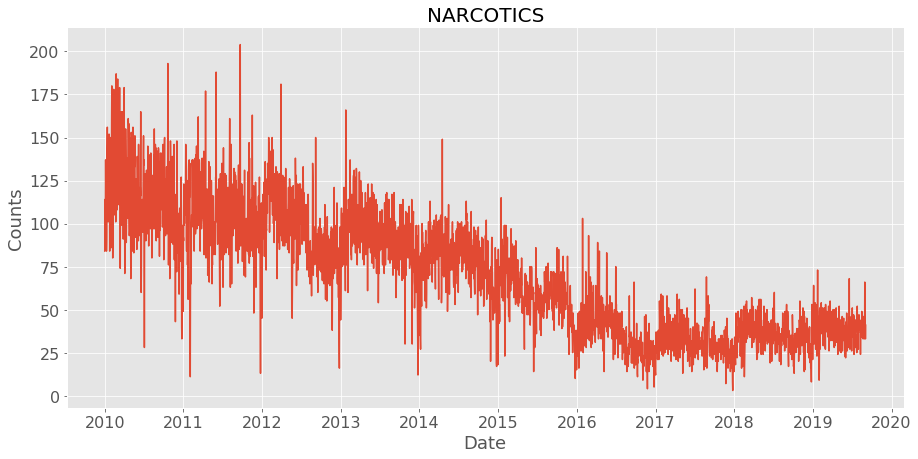

In [95]:
custom_functions.sequence_plot(arima_df_day["NARCOTICS"], arima_df_day["Date"], "NARCOTICS")

### Plotting ACF and PACF to decide the model

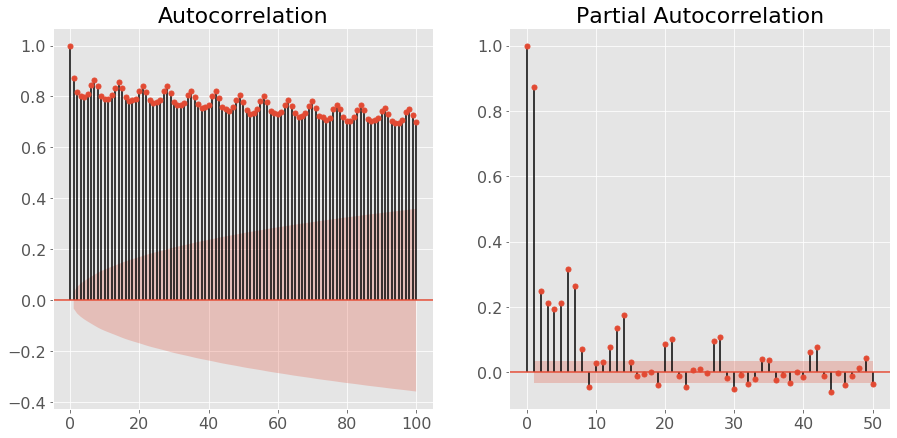

In [96]:
custom_functions.plot_ACF_PACF(arima_df_day["NARCOTICS"])

Choosing ARIMA(15, 0, 0) Model as 15 lags are popping out in PACF plot and there is a gradual decrease in the ACF plot which suggests taking AR terms.

### Fitting ARIMA(15, 0, 0) to NARCOTICS

In [97]:
series = arima_df_day["NARCOTICS"][:-10]
series.index = arima_df_day.index[:-10]
forecast_nar = custom_functions.fit_ARIMA(series, series.index, order = (15, 0, 0), title = "NARCOTICS", 
                                          print_summary = True)

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi


                              ARMA Model Results                              
Dep. Variable:              NARCOTICS   No. Observations:                 3523
Model:                    ARMA(15, 0)   Log Likelihood              -14335.979
Method:                       css-mle   S.D. of innovations             14.150
Date:                Sun, 03 Nov 2019   AIC                          28705.958
Time:                        21:24:26   BIC                          28810.798
Sample:                    01-01-1970   HQIC                         28743.362
                         - 01-01-1970                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               71.2960     15.501      4.600      0.000      40.916     101.676
ar.L1.NARCOTICS      0.3061      0.017     18.168      0.000       0.273       0.339
ar.L2.NARCOTICS      0.0185 

### Evaluating the model

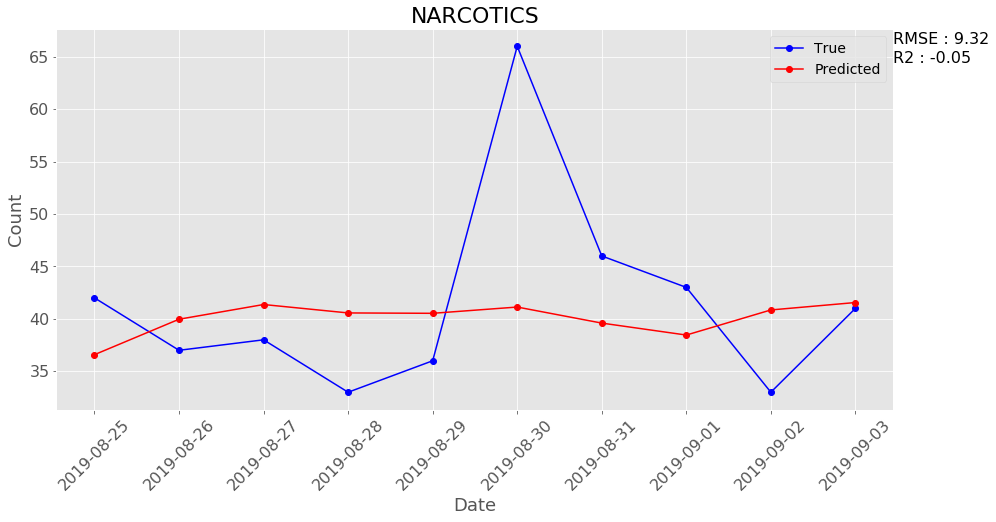

In [98]:
true_values = arima_df_day["NARCOTICS"][-10:]
dates = arima_df_day["Date"][-10:]
custom_functions.plot_true_vs_predicted(true_values, forecast_nar, dates, title = "NARCOTICS")

ARIMA(15,0,0) can predict NARCOTICS with the R2 value of -0.05 which means model is worse than fitting the mean to the data. RMSE is 9.32.

### First order difference of the NARCOTICS

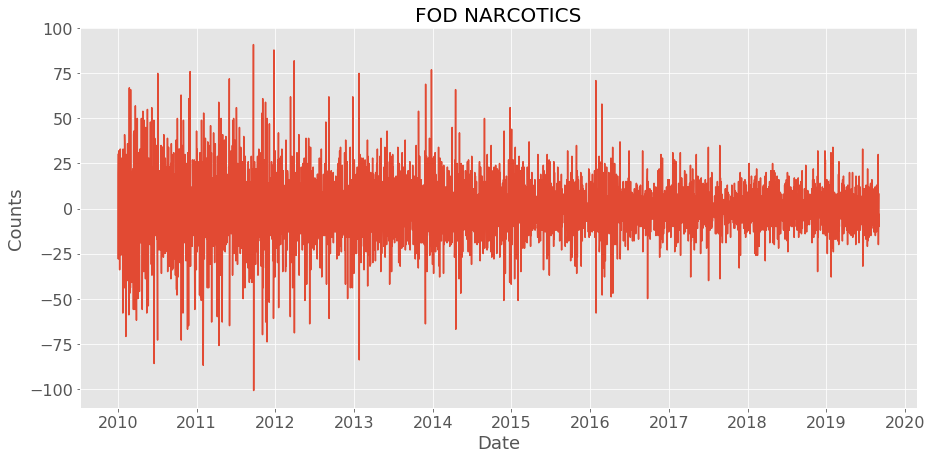

In [99]:
differenced_nar = custom_functions.difference(arima_df_day["NARCOTICS"], interval = 1)
custom_functions.sequence_plot(differenced_nar, arima_df_day["Date"][1:], title = "FOD NARCOTICS")

In [100]:
forecast_nar1 = custom_functions.fit_ARIMA(series, series.index, order = (14, 1, 0), trend = "nc", 
                                           title = "FOD NARCOTICS", print_summary = True)

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi


                             ARIMA Model Results                              
Dep. Variable:            D.NARCOTICS   No. Observations:                 3522
Model:                ARIMA(14, 1, 0)   Log Likelihood              -14332.823
Method:                       css-mle   S.D. of innovations             14.157
Date:                Sun, 03 Nov 2019   AIC                          28695.646
Time:                        21:25:20   BIC                          28788.147
Sample:                    01-01-1970   HQIC                         28728.648
                         - 01-01-1970                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
ar.L1.D.NARCOTICS     -0.6929      0.017    -41.111      0.000      -0.726      -0.660
ar.L2.D.NARCOTICS     -0.6735      0.020    -33.337      0.000      -0.713      -0.634
ar.L3.D.NARCOTICS   

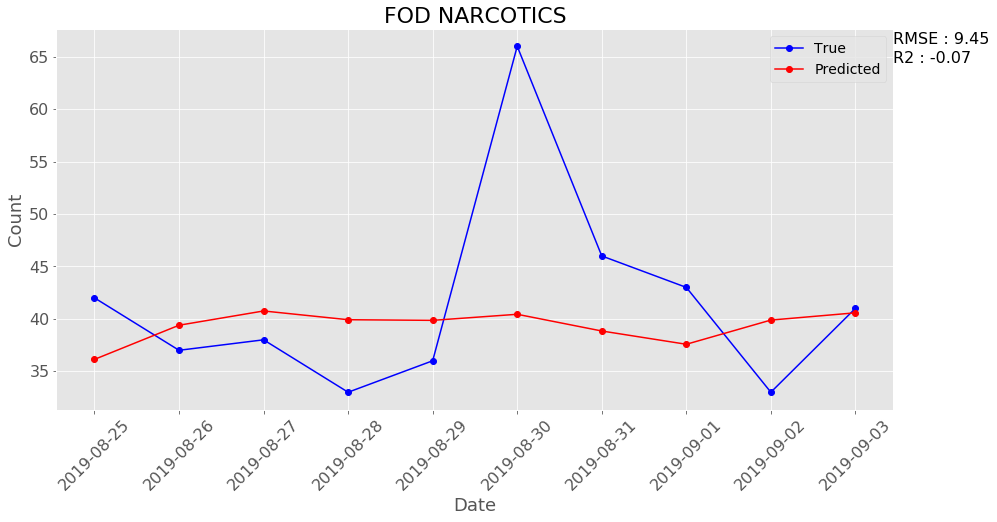

In [101]:
custom_functions.plot_true_vs_predicted(true_values, forecast_nar1, dates, title = "FOD NARCOTICS")

Both models fitted above are useless.

## PUBLIC PEACE VIOLATION

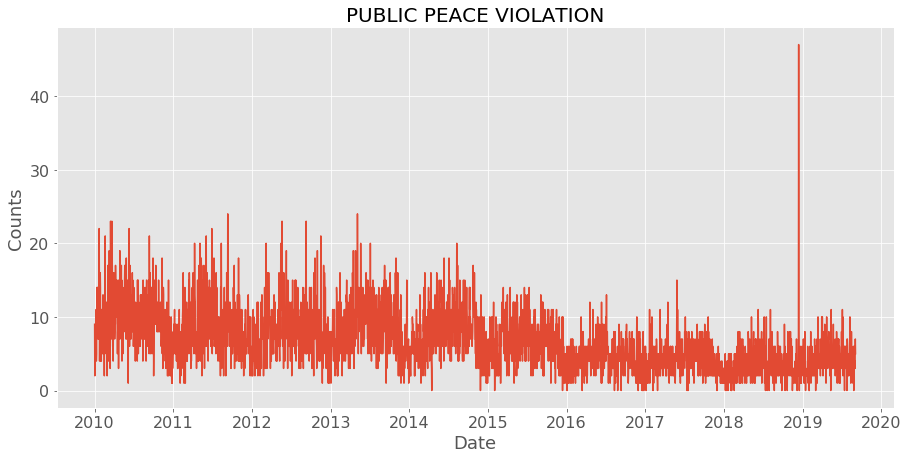

In [102]:
custom_functions.sequence_plot(arima_df_day["PUBLIC PEACE VIOLATION"], arima_df_day["Date"], "PUBLIC PEACE VIOLATION")

### Plotting ACF and PACF to decide the model

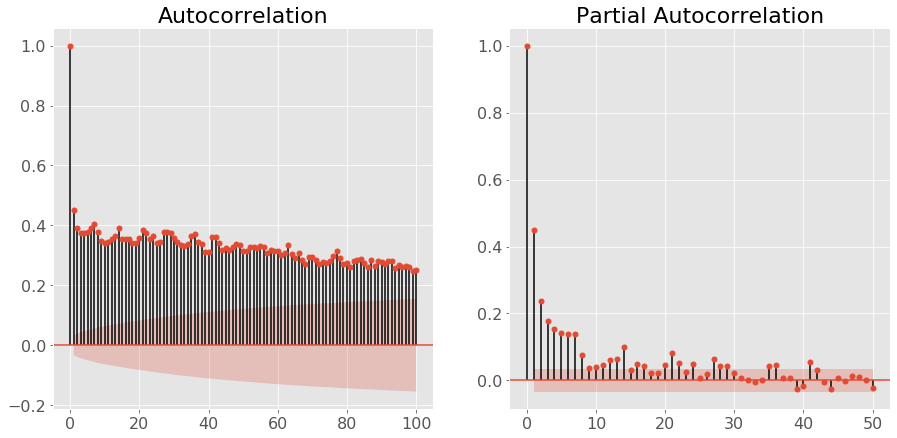

In [103]:
custom_functions.plot_ACF_PACF(arima_df_day["PUBLIC PEACE VIOLATION"])

Choosing ARIMA(15, 0, 0) Model as 15 lags are popping out in PACF plot and there is a gradual decrease in the ACF plot which suggests taking AR terms. AR15 was insignificant so fitting AR14.

### Fitting ARIMA(14, 0, 0) to PUBLIC PEACE VIOLATION

In [104]:
series = arima_df_day["PUBLIC PEACE VIOLATION"][:-10]
series.index = arima_df_day.index[:-10]
forecast_ppv = custom_functions.fit_ARIMA(series, series.index, order = (14, 0, 0), title = "PUBLIC PEACE VIOLATION", 
                                          print_summary = True)

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi


                                ARMA Model Results                                
Dep. Variable:     PUBLIC PEACE VIOLATION   No. Observations:                 3523
Model:                        ARMA(14, 0)   Log Likelihood               -9083.241
Method:                           css-mle   S.D. of innovations              3.187
Date:                    Sun, 03 Nov 2019   AIC                          18198.483
Time:                            21:25:57   BIC                          18297.156
Sample:                        01-01-1970   HQIC                         18233.686
                             - 01-01-1970                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             6.6361      0.440     15.097      0.000       5.775       7.498
ar.L1.PUBLIC PEACE VIOLATION      0.1838  

### Evaluating the model

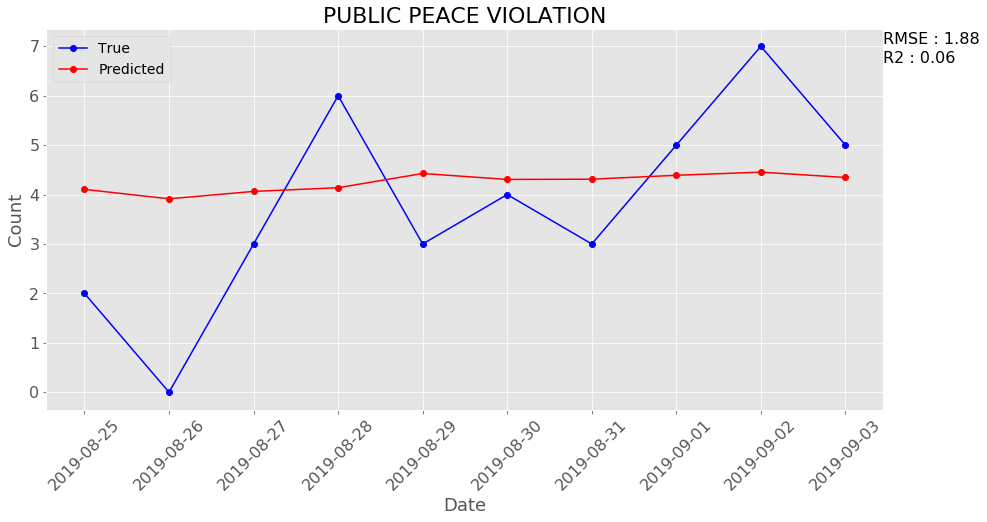

In [105]:
true_values = arima_df_day["PUBLIC PEACE VIOLATION"][-10:]
dates = arima_df_day["Date"][-10:]
custom_functions.plot_true_vs_predicted(true_values, forecast_ppv, dates, title = "PUBLIC PEACE VIOLATION")

ARIMA(15,0,0) can predict PUBLIC PEACE VIOLATION with the R2 value of 0.06 which means model is just good as fitting the mean to the data. RMSE is 1.88.

### First order difference of the PUBLIC PEACE VIOLATION

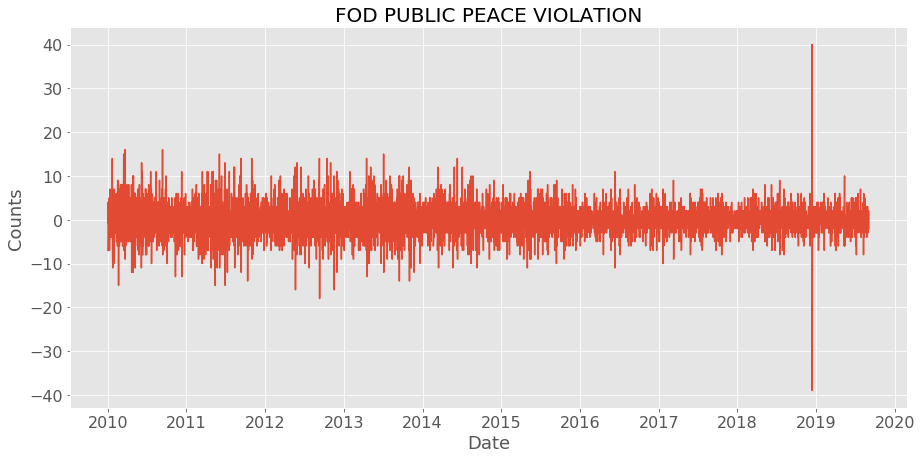

In [106]:
differenced_ppv = custom_functions.difference(arima_df_day["PUBLIC PEACE VIOLATION"], interval = 1)
custom_functions.sequence_plot(differenced_ppv, arima_df_day["Date"][1:], title = "FOD PUBLIC PEACE VIOLATION")

In [107]:
forecast_ppv1 = custom_functions.fit_ARIMA(series, series.index, order = (14, 1, 0), trend = "nc", 
                                           title = "FOD PUBLIC PEACE VIOLATION", print_summary = True)

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi


                                ARIMA Model Results                                 
Dep. Variable:     D.PUBLIC PEACE VIOLATION   No. Observations:                 3522
Model:                      ARIMA(14, 1, 0)   Log Likelihood               -9094.751
Method:                             css-mle   S.D. of innovations              3.200
Date:                      Sun, 03 Nov 2019   AIC                          18219.501
Time:                              21:26:43   BIC                          18312.003
Sample:                          01-01-1970   HQIC                         18252.504
                               - 01-01-1970                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
ar.L1.D.PUBLIC PEACE VIOLATION     -0.8101      0.017    -48.114      0.000      -0.843      -0.777
ar.L2.D.PUBLIC PEACE

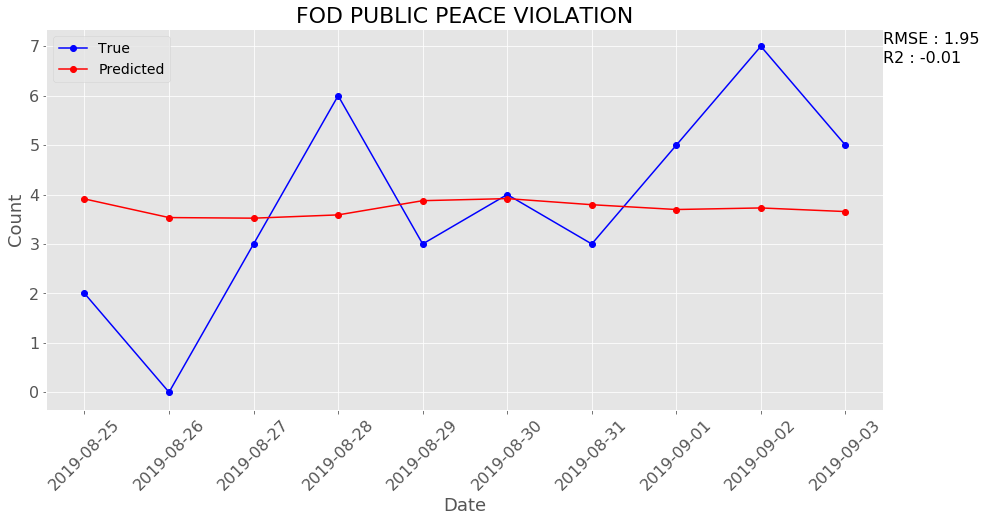

In [108]:
custom_functions.plot_true_vs_predicted(true_values, forecast_ppv1, dates, title = "FOD PUBLIC PEACE VIOLATION")

ARIMA model on FOD data gives negative R2. This model is useless.

### After Fitting ARIMA model and evaluating model performances, and seeing that there is a seasonal component in the data we will try to fit the SARIMA which is Seasonal ARIMA.

## What is SARIMA?

Autoregressive Integrated Moving Average, or ARIMA, is one of the most widely used forecasting methods for univariate time series data forecasting.

Although the method can handle data with a trend, it does not support time series with a seasonal component.

An extension to ARIMA that supports the direct modeling of the seasonal component of the series is called SARIMA.

Seasonality in a time series is a regular pattern of changes that repeats over S time periods, where S defines the number of time periods until the pattern repeats again.

For example, there is seasonality in monthly data for which high values tend always to occur in some particular months and low values tend always to occur in other particular months. In this case, S = 12 (months per year) is the span of the periodic seasonal behavior. For quarterly data, S = 4 time periods per year. For weekly data, S = 7.

In a seasonal ARIMA model, seasonal AR and MA terms predict using data values and errors at times with lags that are multiples of S (the span of the seasonality).

Source 1 - https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/
Source 2 - https://newonlinecourses.science.psu.edu/stat510/lesson/4/4.1

## Crimes<a id = 'crimes_SARIMA'></a>

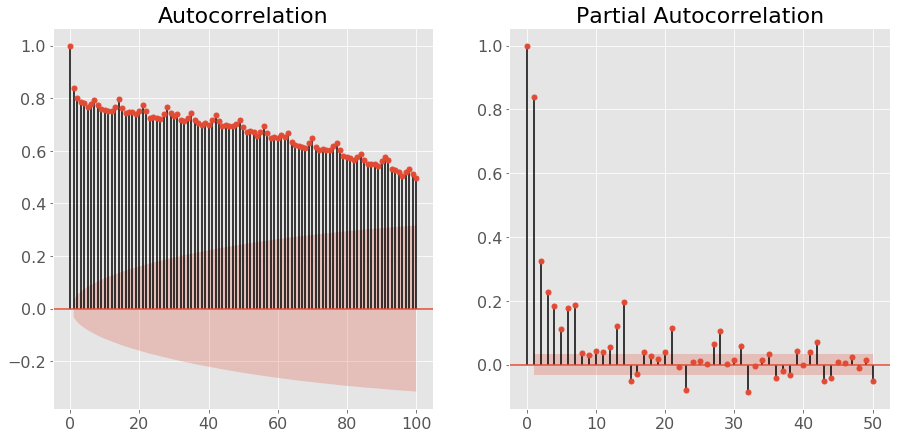

In [109]:
custom_functions.plot_ACF_PACF(arima_df_day["Crimes"])

To decide model parameters, We need to look at ACF and PACF plots. 
There are three classic cases.

1. CASE1 - Gradual decrease in ACF and Definite cut off in PACF plot. That suggests SAR(Seasonal AR) terms. To decide how many SAR terms we need to look at PACF plot and see how many bars are significantly out of confindence interval(red zone).

2. CASE2 - Gradual decrease in PACF and Definite cut off in ACF plot. That suggests SMA(Seasonal MA) terms. To decide how many SMA terms we need to look at ACF plot and see how many bars are significantly out of confindence interval(red zone).

3. CASE3 - Definite cut off in both ACF and PACF plots. That suggests both SAR and SMA terms. To decide how many SAR terms we need to look at PACF plot and to decide how many SMA terms we need to look at ACF plot and see how many bars are significantly out of confindence interval(red zone).


**Here we can see CASE1 in the above plots.**

Why we chose seasonl order of (AR = 0, D = 1, MA = 0, S = 7). We can see the bar in PACF plots poking out at every 7 day interval that's why we chose week as a season. And seasonal difference of 1 to make sure that data comes from a stationary process.

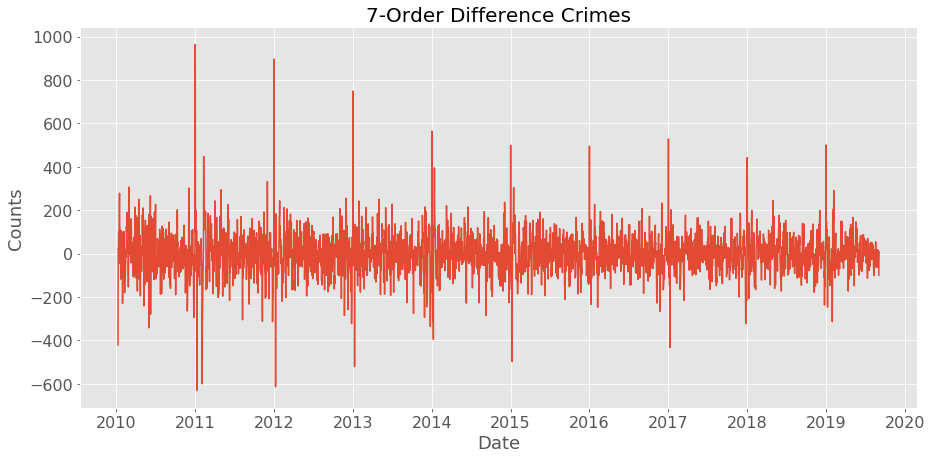

In [110]:
differenced = custom_functions.difference(arima_df_day["Crimes"],7)
custom_functions.sequence_plot(differenced, arima_df_day["Date"][7:], title = "7-Order Difference Crimes")

Before applying Time series model SARIMA we need to check stationarity of the data which can be assessed by assessing following two things.

1. Data should fluctuate around the constant mean/value.
2. Variation of the data must be within a constant band.

If both conditions are true that means data comes from a **stationary process**(that means we can use it to predict and forecast) then only we can fit the SARIMA model to it. For the above graph both conditions are true so we will go ahead and fit SARIMA to the data.

In [111]:
series = arima_df_day["Crimes"][:-10]
series.index = arima_df_day["Date"][:-10]
forecast_crimes = custom_functions.fit_SARIMA(series, series.index, trend = "n", order = (15, 1, 0), sorder = (0, 1, 0, 7), 
                                              title = "Crimes")

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


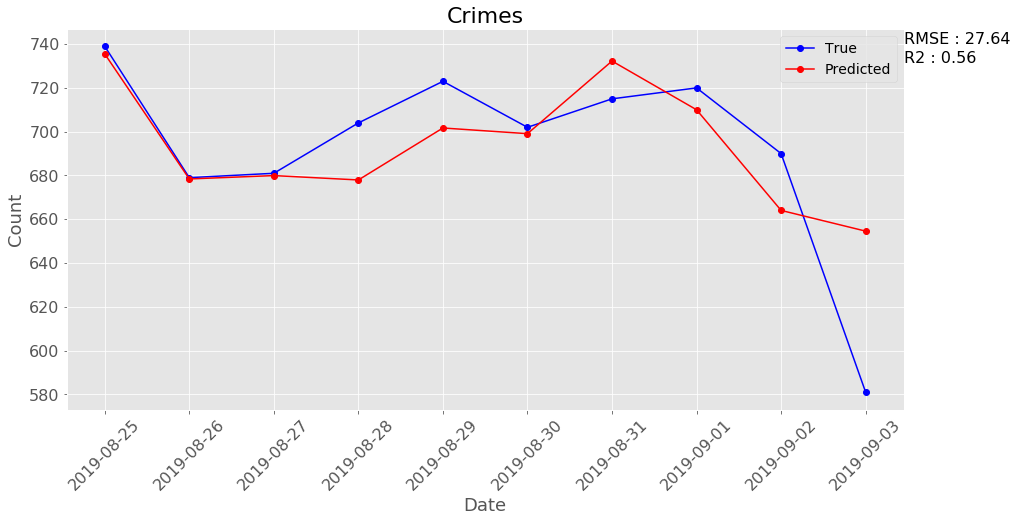

In [112]:
true_values = arima_df_day["Crimes"][-10:]
dates = arima_df_day["Date"][-10:]
custom_functions.plot_true_vs_predicted(true_values, forecast_crimes, dates, title = "Crimes")

Model can explain 56% of the variation in the data with the RMSE value of 27.64

## BATTERY<a id='battery_SARIMA'></a>

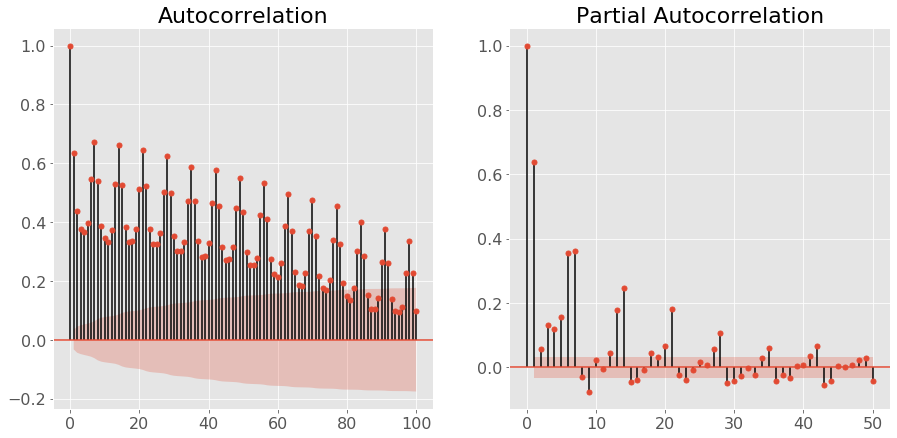

In [113]:
custom_functions.plot_ACF_PACF(arima_df_day["BATTERY"])

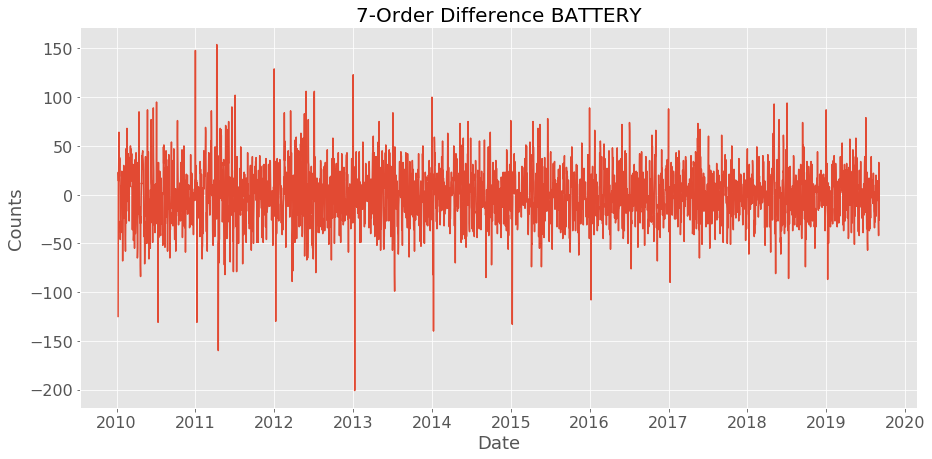

In [114]:
differenced = custom_functions.difference(arima_df_day["BATTERY"],7)
custom_functions.sequence_plot(differenced, arima_df_day["Date"][7:], title = "7-Order Difference BATTERY")

In [115]:
series = arima_df_day["BATTERY"][:-10]
series.index = arima_df_day["Date"][:-10]
forecast_battery = custom_functions.fit_SARIMA(series, series.index, trend = "n", order = (15, 1, 0), sorder = (0, 1, 1, 7), 
                                              title = "BATTERY")

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


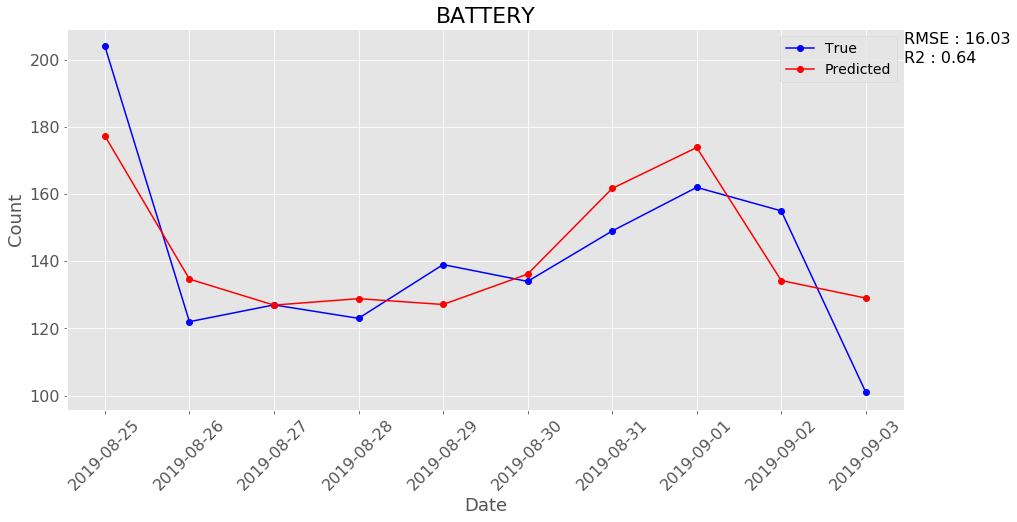

In [116]:
true_values = arima_df_day["BATTERY"][-10:]
dates = arima_df_day["Date"][-10:]
custom_functions.plot_true_vs_predicted(true_values, forecast_battery, dates, title = "BATTERY")

Model can explain 64% of the variation in the data with the RMSE value of 16.03.

## MOTOR VEHICLE THEFT

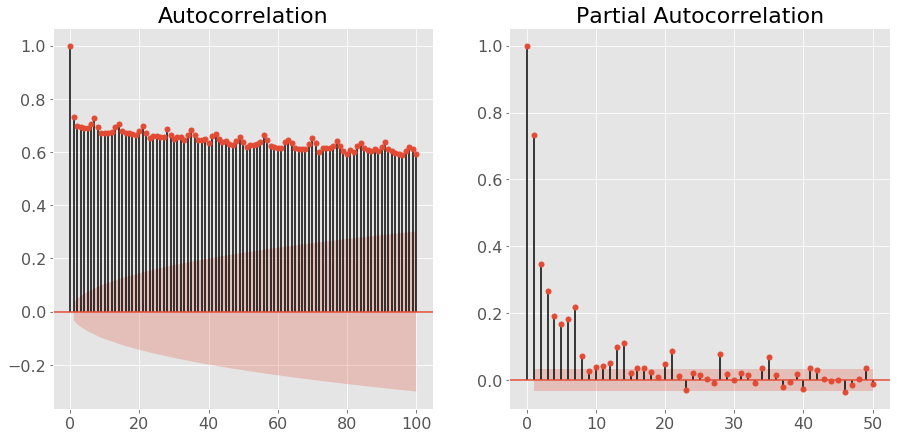

In [117]:
custom_functions.plot_ACF_PACF(arima_df_day["MOTOR VEHICLE THEFT"])

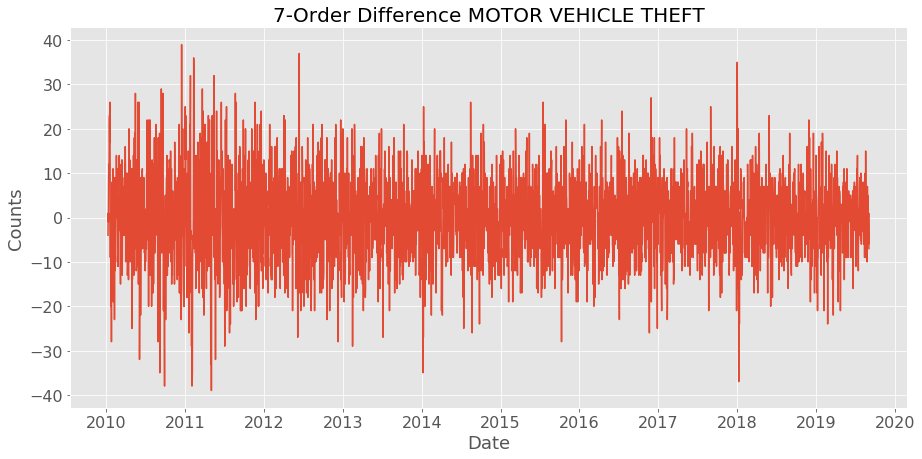

In [118]:
differenced = custom_functions.difference(arima_df_day["MOTOR VEHICLE THEFT"],7)
custom_functions.sequence_plot(differenced, arima_df_day["Date"][7:], title = "7-Order Difference MOTOR VEHICLE THEFT")

In [119]:
series = arima_df_day["MOTOR VEHICLE THEFT"][:-10]
series.index = arima_df_day["Date"][:-10]
forecast_motor = custom_functions.fit_SARIMA(series, series.index, trend = "n", order = (15, 1, 0), sorder = (0, 1, 0, 7), 
                                              title = "MOTOR VEHICLE THEFT")

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


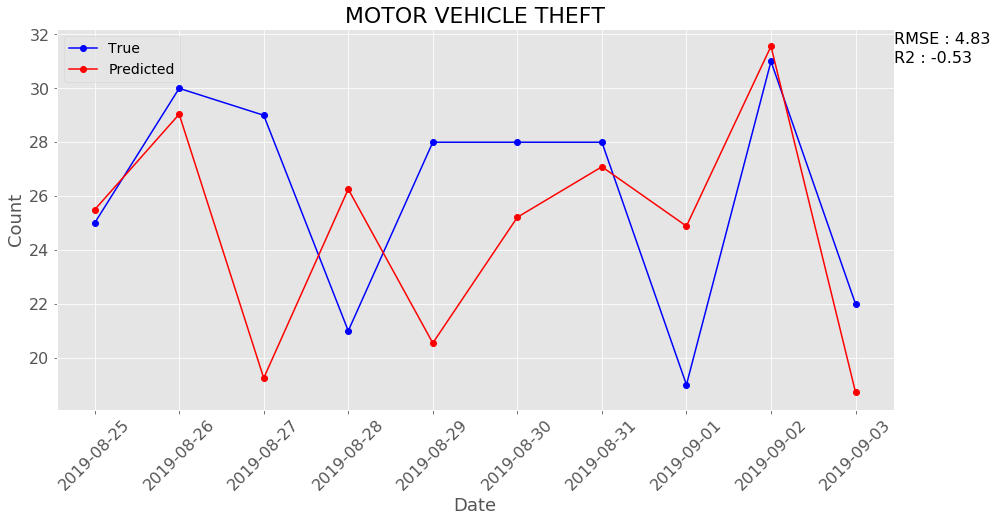

In [120]:
true_values = arima_df_day["MOTOR VEHICLE THEFT"][-10:]
dates = arima_df_day["Date"][-10:]
custom_functions.plot_true_vs_predicted(true_values, forecast_motor, dates, title = "MOTOR VEHICLE THEFT")

Model is useless.

## CRIMINAL DAMAGE

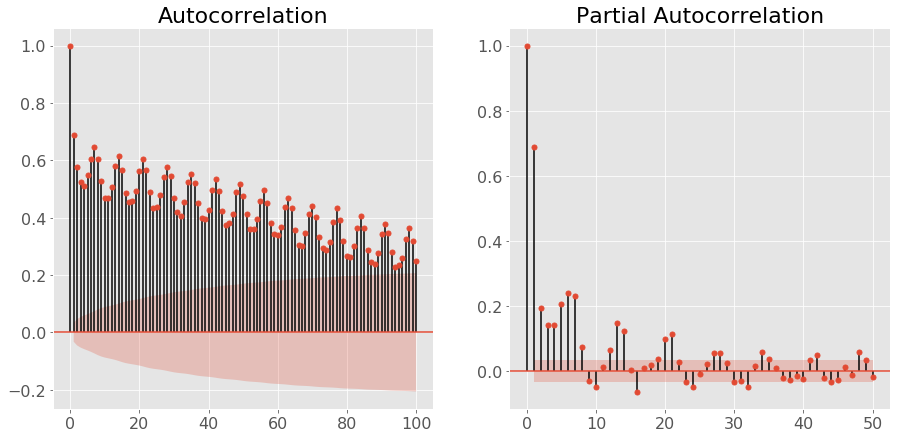

In [121]:
custom_functions.plot_ACF_PACF(arima_df_day["CRIMINAL DAMAGE"])

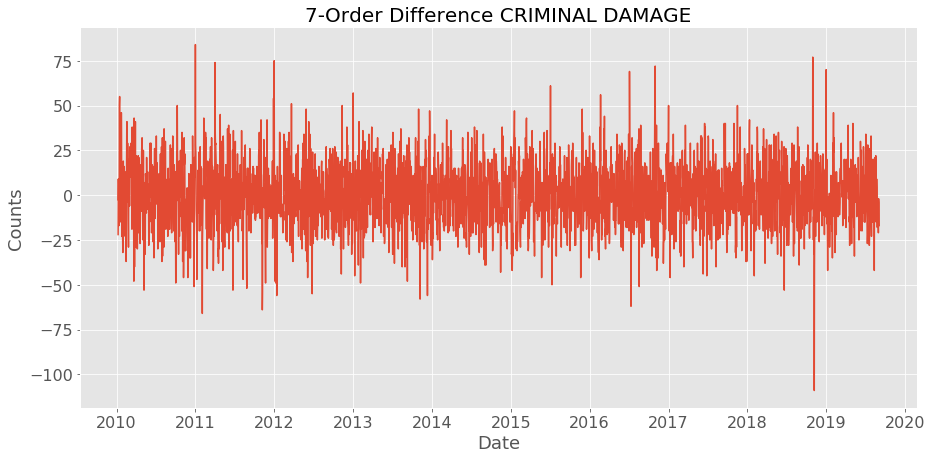

In [122]:
differenced = custom_functions.difference(arima_df_day["CRIMINAL DAMAGE"],7)
custom_functions.sequence_plot(differenced, arima_df_day["Date"][7:], title = "7-Order Difference CRIMINAL DAMAGE")

In [123]:
series = arima_df_day["CRIMINAL DAMAGE"][:-10]
series.index = arima_df_day["Date"][:-10]
forecast_cd = custom_functions.fit_SARIMA(series, series.index, trend = "n", order = (15, 1, 0), sorder = (0, 1, 0, 7), 
                                              title = "CRIMINAL DAMAGE", print_summary=True)

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


                                 Statespace Model Results                                 
Dep. Variable:                    CRIMINAL DAMAGE   No. Observations:                 3523
Model:             SARIMAX(15, 1, 0)x(0, 1, 0, 7)   Log Likelihood              -14502.142
Date:                            Sun, 03 Nov 2019   AIC                          29036.284
Time:                                    21:28:38   BIC                          29134.921
Sample:                                01-01-2010   HQIC                         29071.479
                                     - 08-24-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6429      0.016    -39.978      0.000      -0.674      -0.611
ar.L2         -0.4596      0.019   

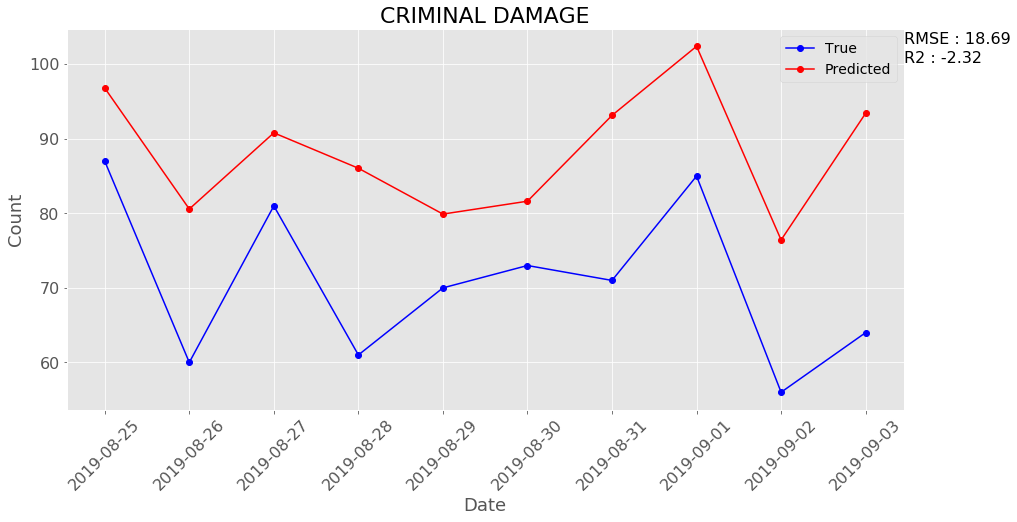

In [124]:
true_values = arima_df_day["CRIMINAL DAMAGE"][-10:]
dates = arima_df_day["Date"][-10:]
custom_functions.plot_true_vs_predicted(true_values, forecast_cd, dates, title = "CRIMINAL DAMAGE")

Model is useless.

## ASSAULT

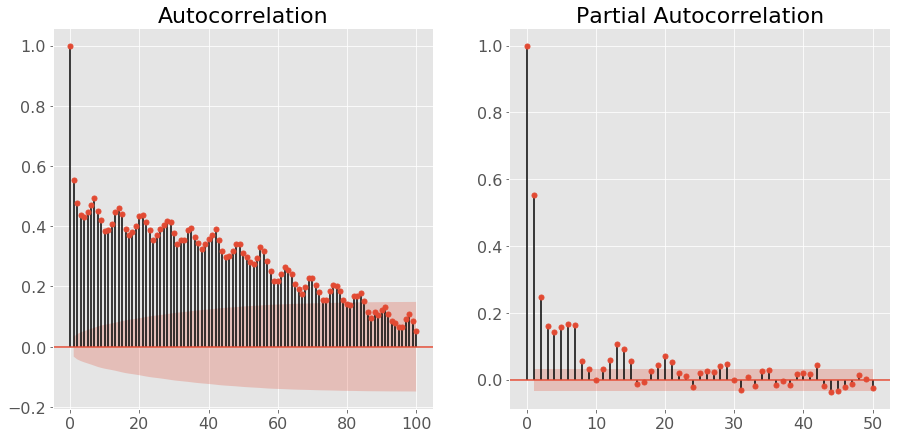

In [125]:
custom_functions.plot_ACF_PACF(arima_df_day["ASSAULT"])

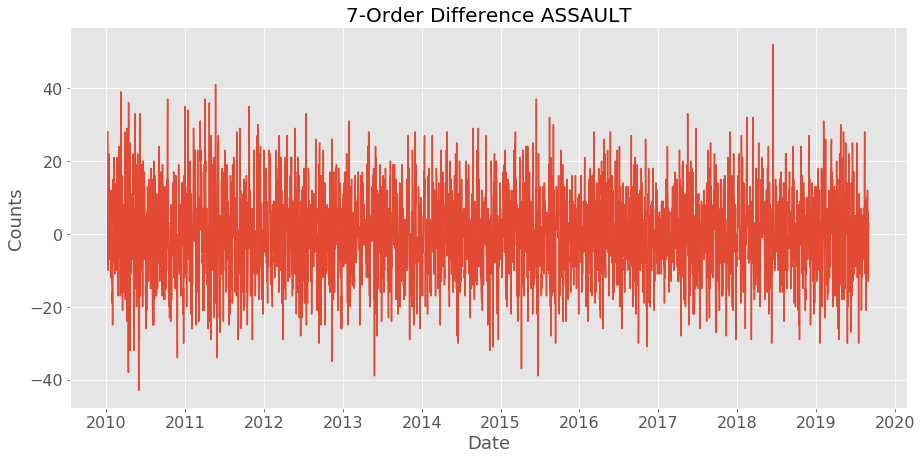

In [126]:
differenced = custom_functions.difference(arima_df_day["ASSAULT"],7)
custom_functions.sequence_plot(differenced, arima_df_day["Date"][7:], title = "7-Order Difference ASSAULT")

In [127]:
series = arima_df_day["ASSAULT"][:-10]
series.index = arima_df_day["Date"][:-10]
forecast_ass = custom_functions.fit_SARIMA(series, series.index, trend = "n", order = (15, 1, 0), sorder = (0, 1, 0, 7), 
                                              title = "ASSAULT")

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


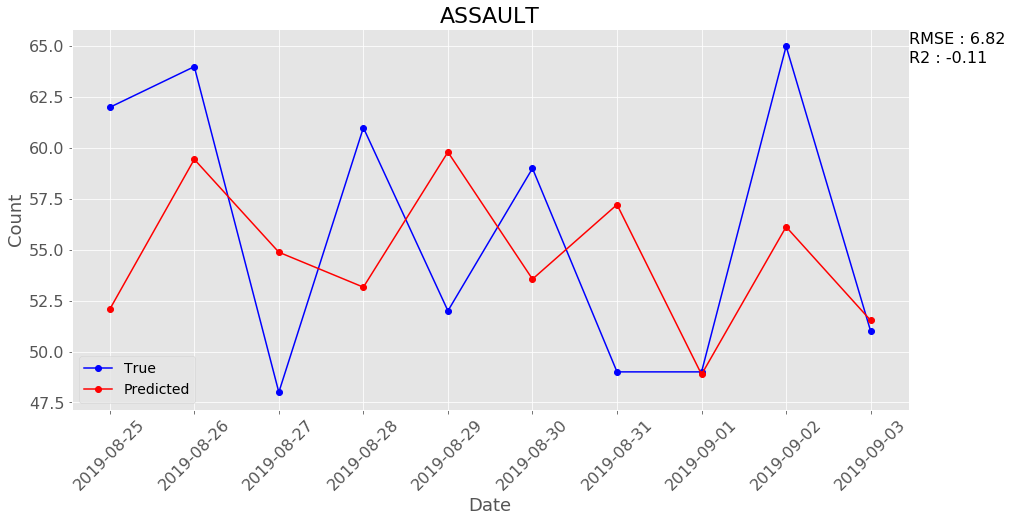

In [128]:
true_values = arima_df_day["ASSAULT"][-10:]
dates = arima_df_day["Date"][-10:]
custom_functions.plot_true_vs_predicted(true_values, forecast_ass, dates, title = "ASSAULT")

Model is useless.

## ROBBERY

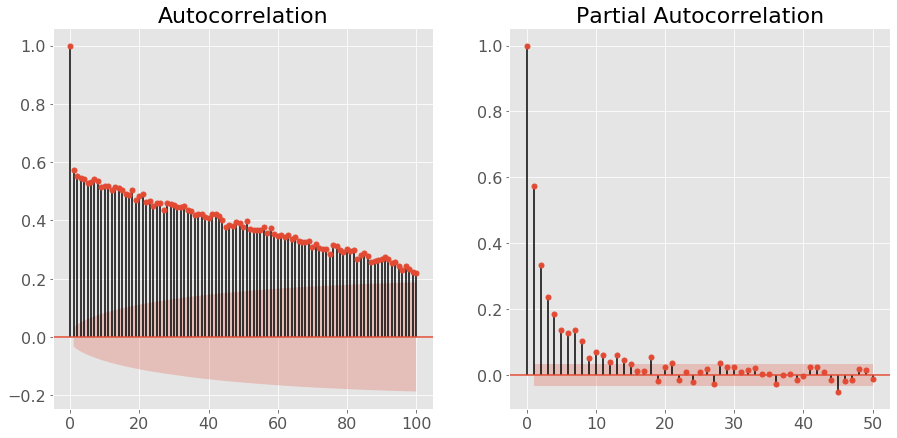

In [129]:
custom_functions.plot_ACF_PACF(arima_df_day["ROBBERY"])

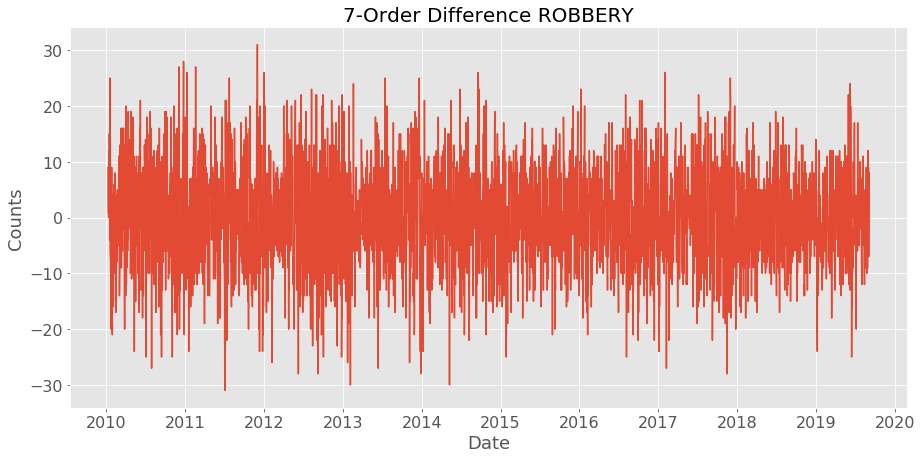

In [130]:
differenced = custom_functions.difference(arima_df_day["ROBBERY"],7)
custom_functions.sequence_plot(differenced, arima_df_day["Date"][7:], title = "7-Order Difference ROBBERY")

In [131]:
series = arima_df_day["ROBBERY"][:-10]
series.index = arima_df_day["Date"][:-10]
forecast_rob = custom_functions.fit_SARIMA(series, series.index, trend = "n", order = (15, 1, 0), sorder = (0, 1, 1, 7), 
                                              title = "ROBBERY")

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


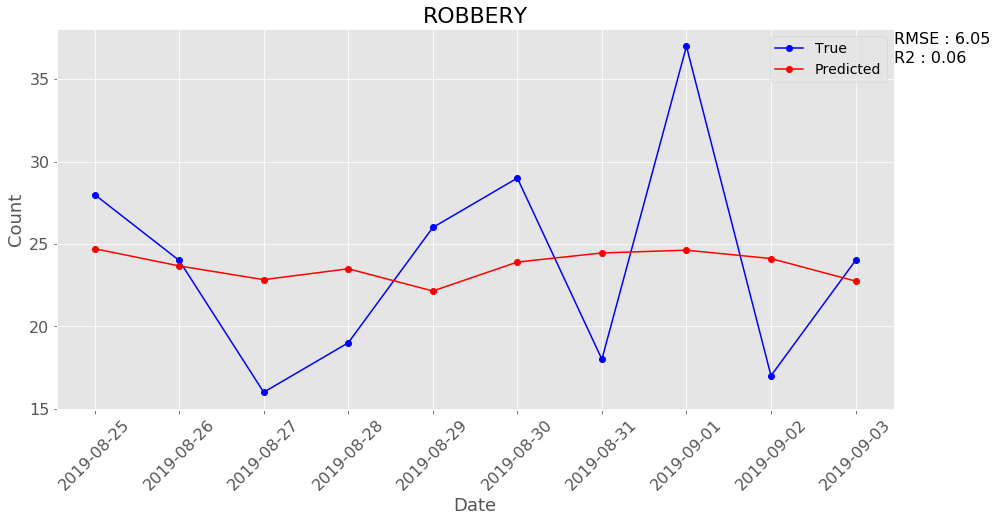

In [132]:
true_values = arima_df_day["ROBBERY"][-10:]
dates = arima_df_day["Date"][-10:]
custom_functions.plot_true_vs_predicted(true_values, forecast_rob, dates, title = "ROBBERY")

Model is as good as fitting the mean to the data.

## WEAPONS VIOLATION<a id = 'wp_SARIMA'></a>

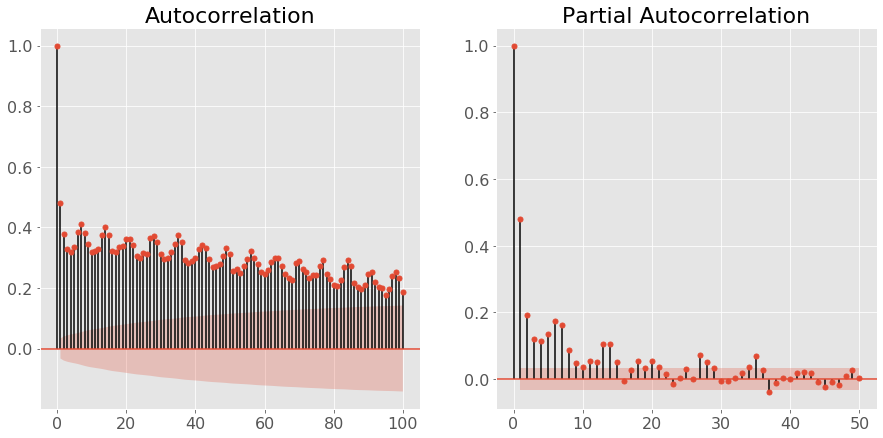

In [133]:
custom_functions.plot_ACF_PACF(arima_df_day["WEAPONS VIOLATION"])

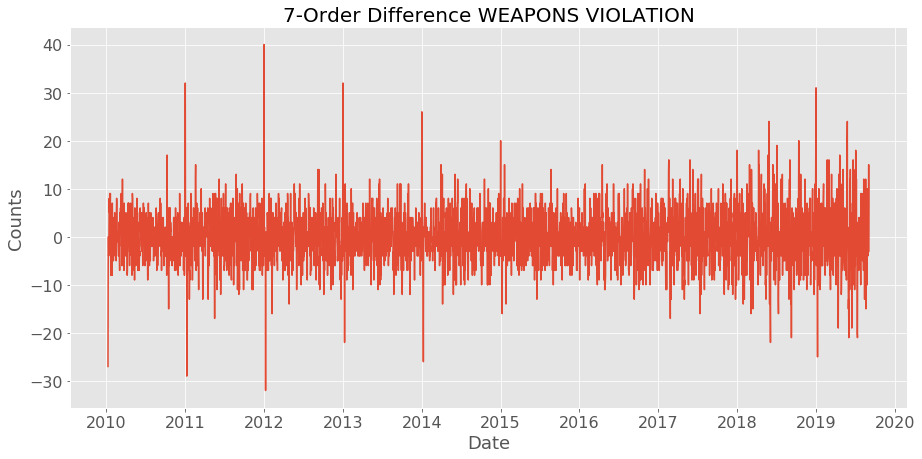

In [134]:
differenced = custom_functions.difference(arima_df_day["WEAPONS VIOLATION"],7)
custom_functions.sequence_plot(differenced, arima_df_day["Date"][7:], title = "7-Order Difference WEAPONS VIOLATION")

In [135]:
series = arima_df_day["WEAPONS VIOLATION"][:-10]
series.index = arima_df_day["Date"][:-10]
forecast_wp = custom_functions.fit_SARIMA(series, series.index, trend = "n", order = (15, 0, 0), sorder = (0, 1, 0, 7), 
                                              title = "WEAPONS VIOLATION")

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


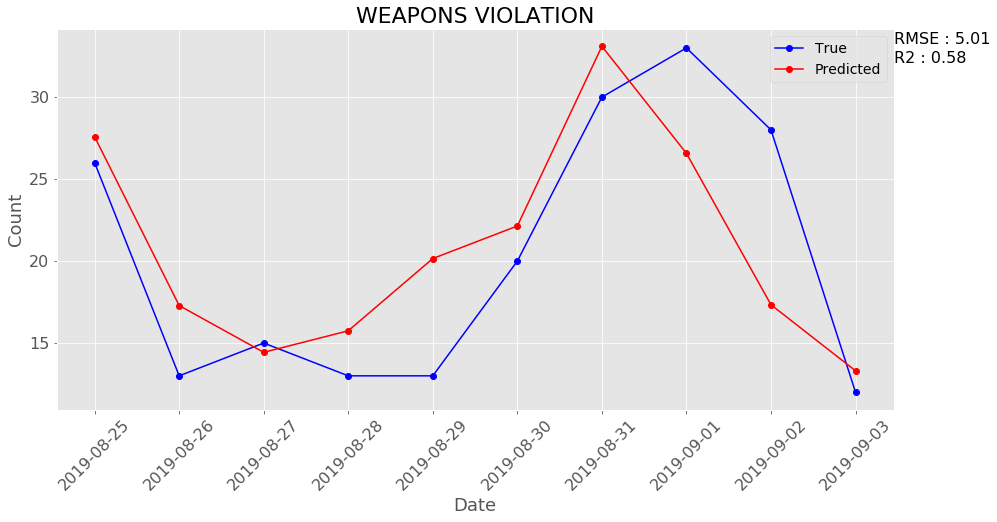

In [136]:
true_values = arima_df_day["WEAPONS VIOLATION"][-10:]
dates = arima_df_day["Date"][-10:]
custom_functions.plot_true_vs_predicted(true_values, forecast_wp, dates, title = "WEAPONS VIOLATION")

Model can explain 58% of the variation in the data with the RMSE value of 5.01.

## OTHER OFFENSE

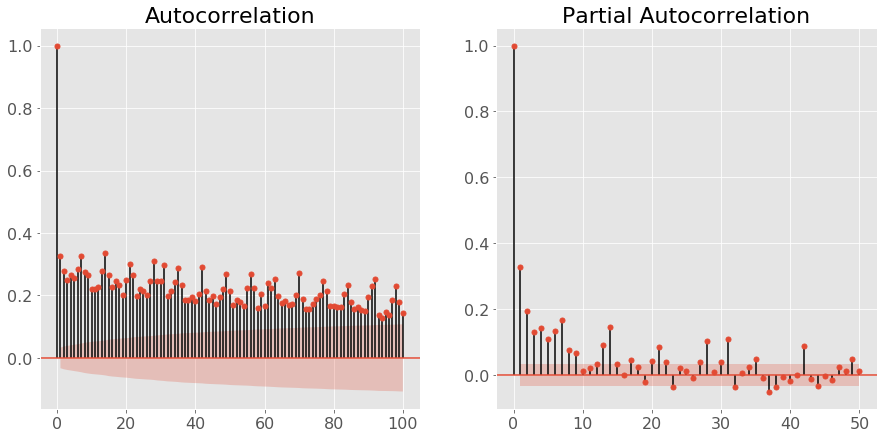

In [137]:
custom_functions.plot_ACF_PACF(arima_df_day["OTHER OFFENSE"])

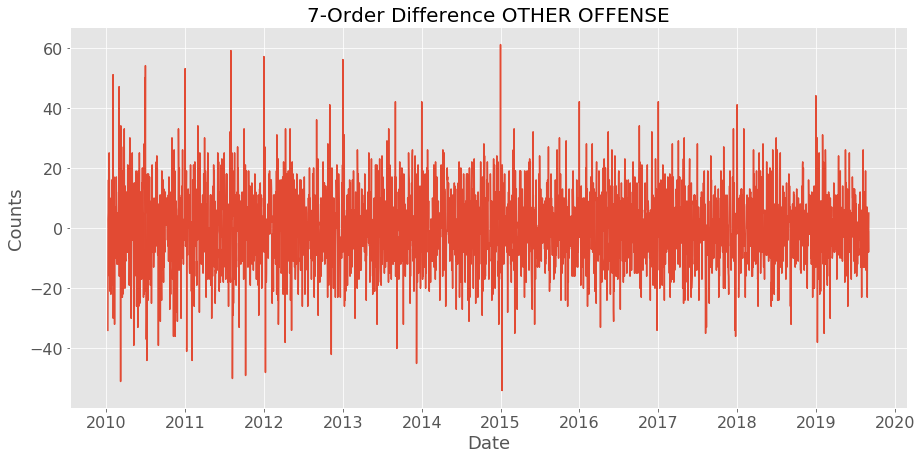

In [138]:
differenced = custom_functions.difference(arima_df_day["OTHER OFFENSE"],7)
custom_functions.sequence_plot(differenced, arima_df_day["Date"][7:], title = "7-Order Difference OTHER OFFENSE")

In [139]:
series = arima_df_day["OTHER OFFENSE"][:-10]
series.index = arima_df_day["Date"][:-10]
forecast_oo = custom_functions.fit_SARIMA(series, series.index, trend = "n", order = (15, 1, 0), sorder = (0, 1, 1, 7), 
                                              title = "OTHER OFFENSE")

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


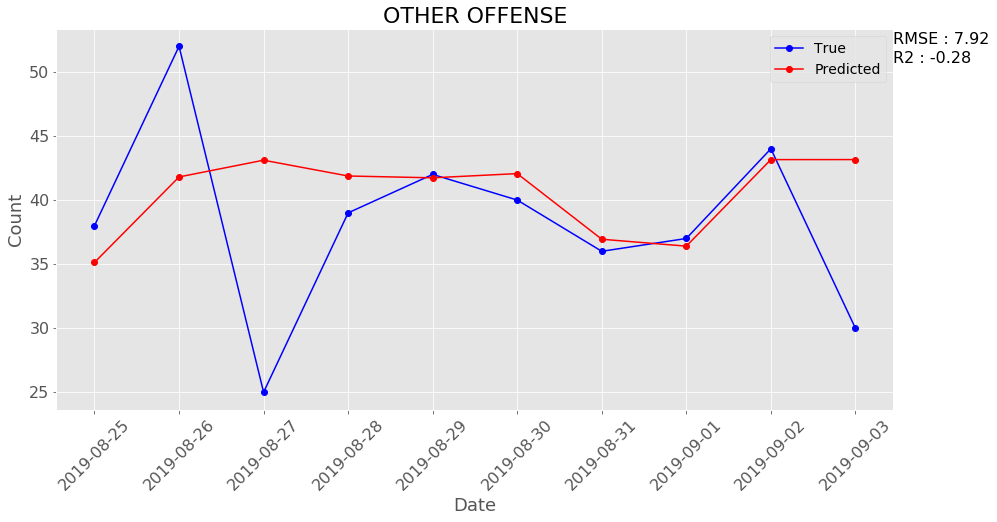

In [140]:
true_values = arima_df_day["OTHER OFFENSE"][-10:]
dates = arima_df_day["Date"][-10:]
custom_functions.plot_true_vs_predicted(true_values, forecast_oo, dates, title = "OTHER OFFENSE")

Model is useless.

## BURGLARY

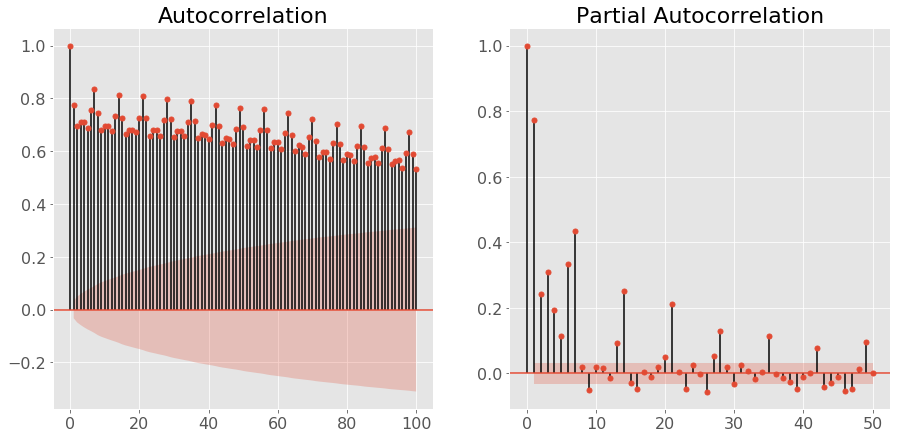

In [141]:
custom_functions.plot_ACF_PACF(arima_df_day["BURGLARY"])

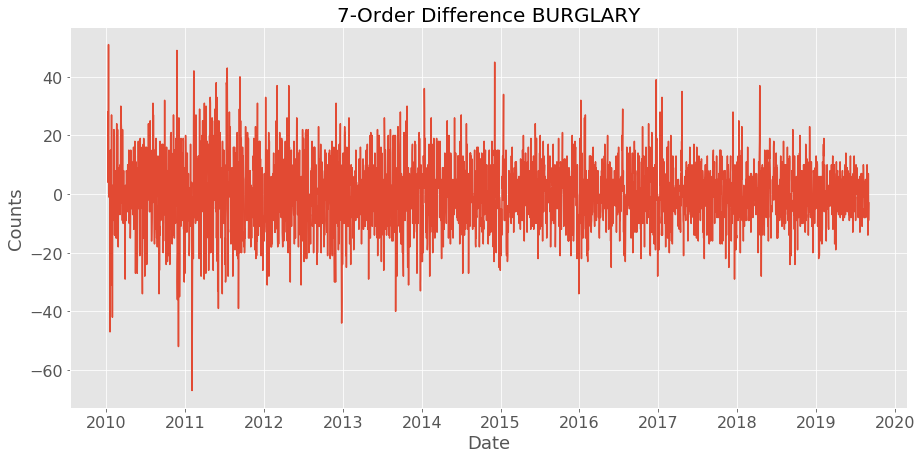

In [142]:
differenced = custom_functions.difference(arima_df_day["BURGLARY"],7)
custom_functions.sequence_plot(differenced, arima_df_day["Date"][7:], title = "7-Order Difference BURGLARY")

In [143]:
series = arima_df_day["BURGLARY"][:-10]
series.index = arima_df_day["Date"][:-10]
forecast_bur = custom_functions.fit_SARIMA(series, series.index, trend = "n", order = (15, 1, 0), sorder = (0, 1, 1, 7), 
                                              title = "BURGLARY")

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


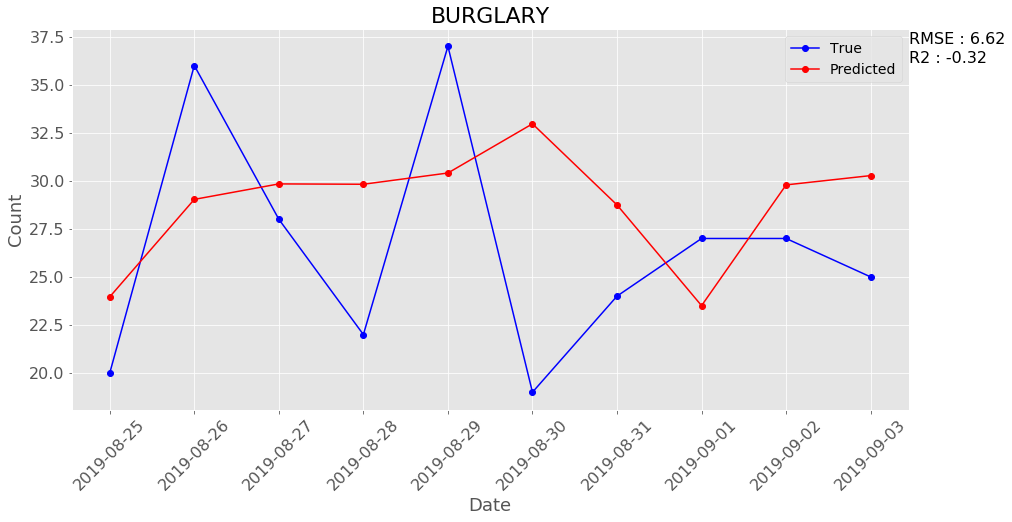

In [144]:
true_values = arima_df_day["BURGLARY"][-10:]
dates = arima_df_day["Date"][-10:]
custom_functions.plot_true_vs_predicted(true_values, forecast_bur, dates, title = "BURGLARY")

Model is useless.

## THEFT

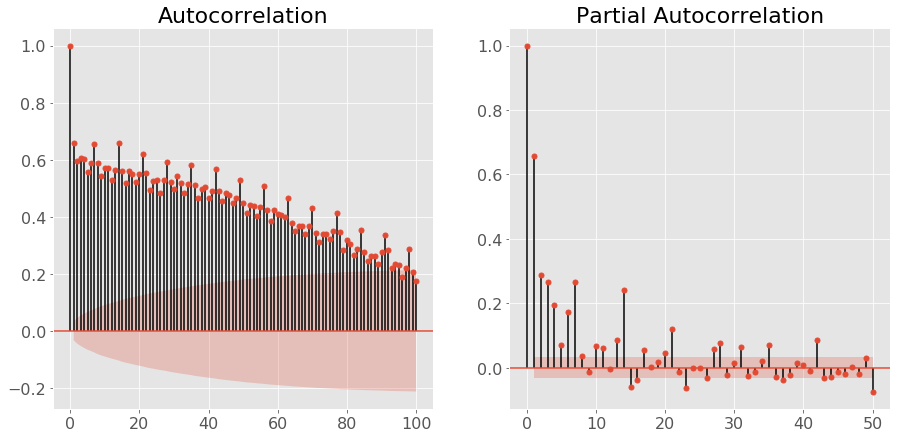

In [145]:
custom_functions.plot_ACF_PACF(arima_df_day["THEFT"])

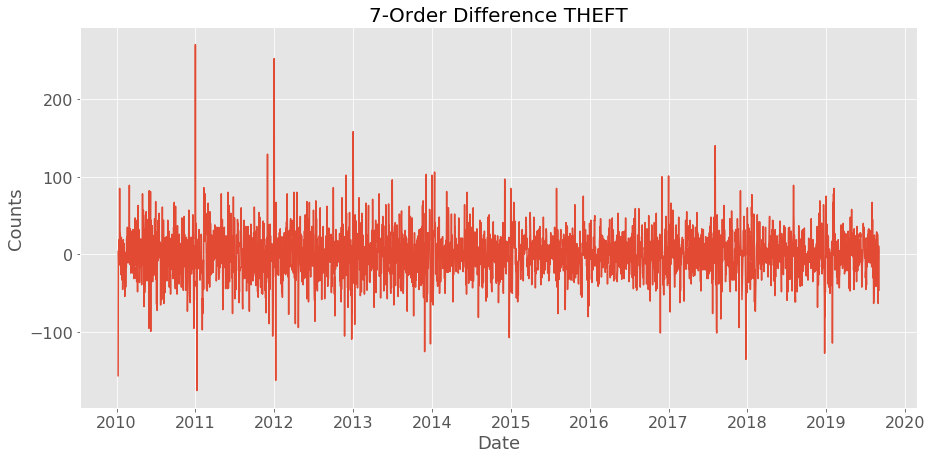

In [146]:
differenced = custom_functions.difference(arima_df_day["THEFT"],7)
custom_functions.sequence_plot(differenced, arima_df_day["Date"][7:], title = "7-Order Difference THEFT")

In [147]:
series = arima_df_day["THEFT"][:-10]
series.index = arima_df_day["Date"][:-10]
forecast_the = custom_functions.fit_SARIMA(series, series.index, trend = "n", order = (15, 1, 0), sorder = (0, 1, 0, 7), 
                                              title = "THEFT")

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


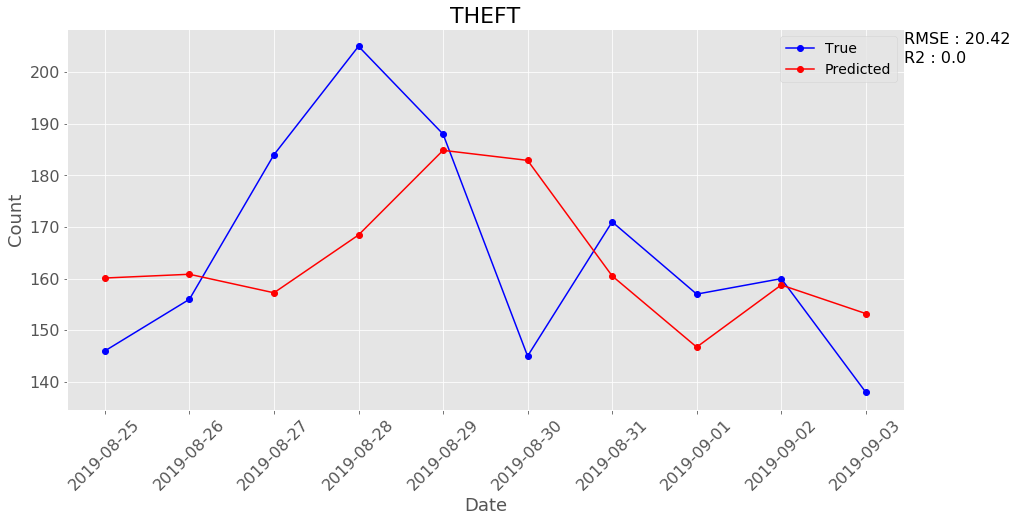

In [148]:
true_values = arima_df_day["THEFT"][-10:]
dates = arima_df_day["Date"][-10:]
custom_functions.plot_true_vs_predicted(true_values, forecast_the, dates, title = "THEFT")

Model is exactly equivalent to fitting the mean to the data.

## CRIMINAL TRESPASS

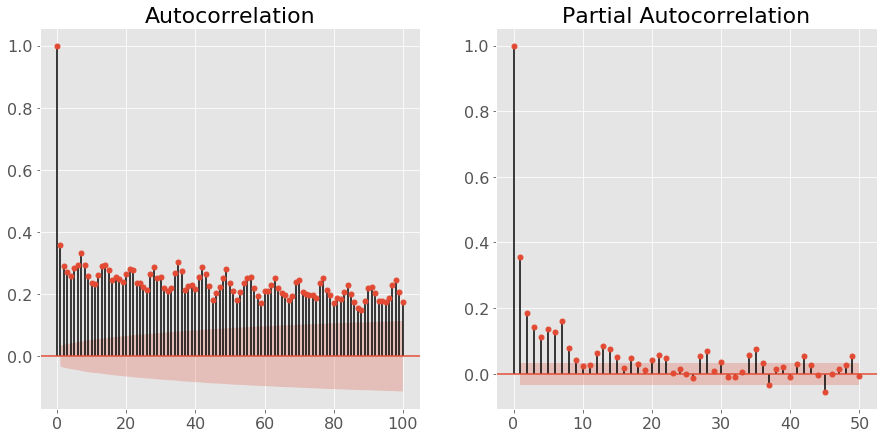

In [149]:
custom_functions.plot_ACF_PACF(arima_df_day["CRIMINAL TRESPASS"])

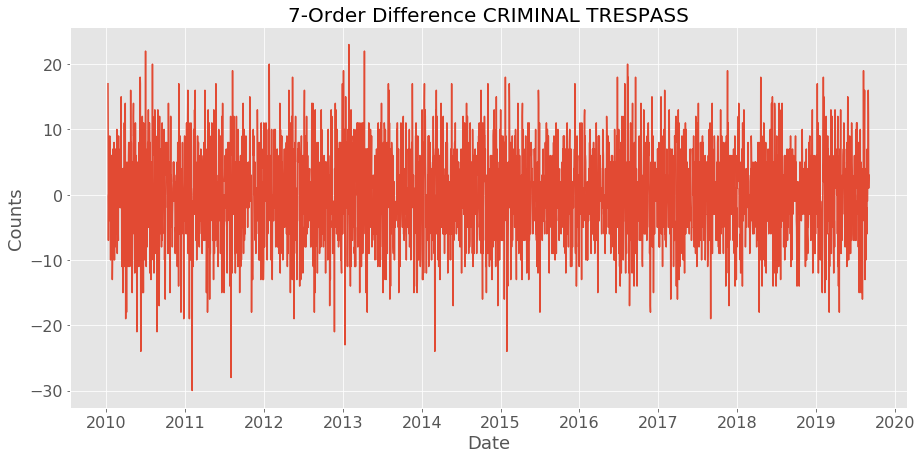

In [150]:
differenced = custom_functions.difference(arima_df_day["CRIMINAL TRESPASS"],7)
custom_functions.sequence_plot(differenced, arima_df_day["Date"][7:], title = "7-Order Difference CRIMINAL TRESPASS")

In [151]:
series = arima_df_day["CRIMINAL TRESPASS"][:-10]
series.index = arima_df_day["Date"][:-10]
forecast_ct = custom_functions.fit_SARIMA(series, series.index, trend = "n", order = (15, 1, 0), sorder = (0, 1, 1, 7), 
                                              title = "CRIMINAL TRESPASS")

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


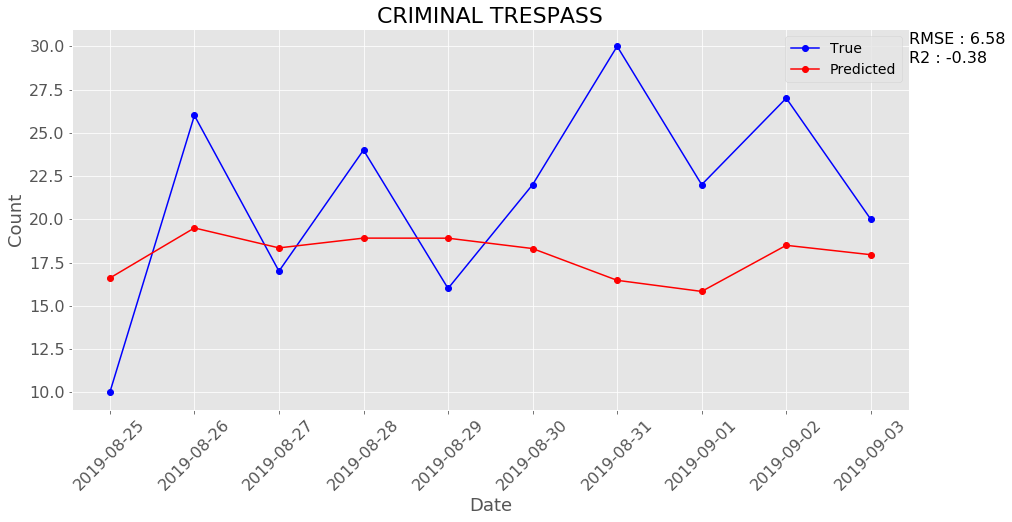

In [152]:
true_values = arima_df_day["CRIMINAL TRESPASS"][-10:]
dates = arima_df_day["Date"][-10:]
custom_functions.plot_true_vs_predicted(true_values, forecast_ct, dates, title = "CRIMINAL TRESPASS")

Model is useless.

## DECEPTIVE PRACTICE

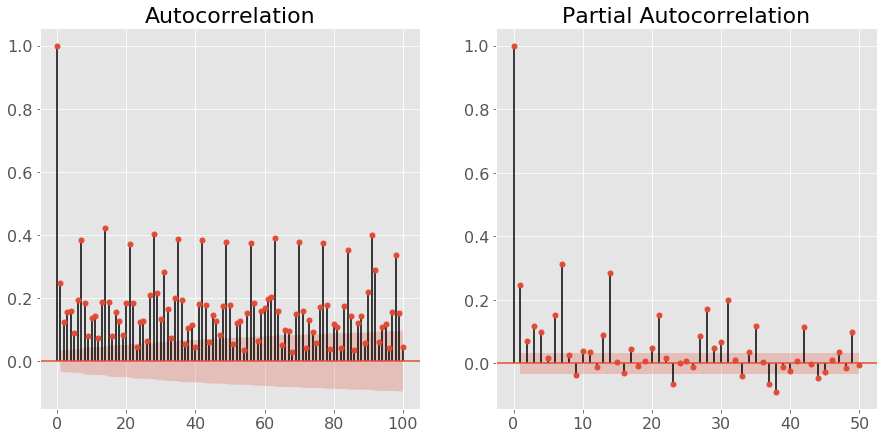

In [153]:
custom_functions.plot_ACF_PACF(arima_df_day["DECEPTIVE PRACTICE"])

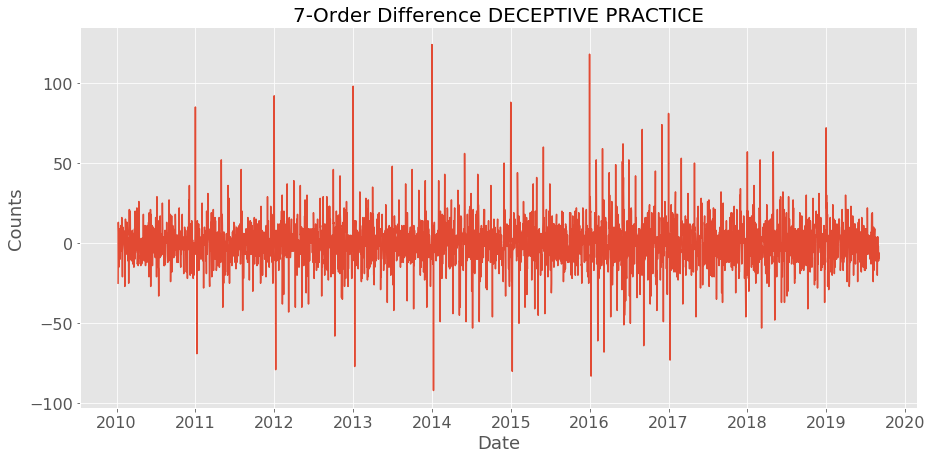

In [154]:
differenced = custom_functions.difference(arima_df_day["DECEPTIVE PRACTICE"],7)
custom_functions.sequence_plot(differenced, arima_df_day["Date"][7:], title = "7-Order Difference DECEPTIVE PRACTICE")

In [155]:
series = arima_df_day["DECEPTIVE PRACTICE"][:-10]
series.index = arima_df_day["Date"][:-10]
forecast_dp = custom_functions.fit_SARIMA(series, series.index, trend = "n", order = (15, 1, 0), sorder = (0, 1, 0, 7), 
                                              title = "DECEPTIVE PRACTICE")

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


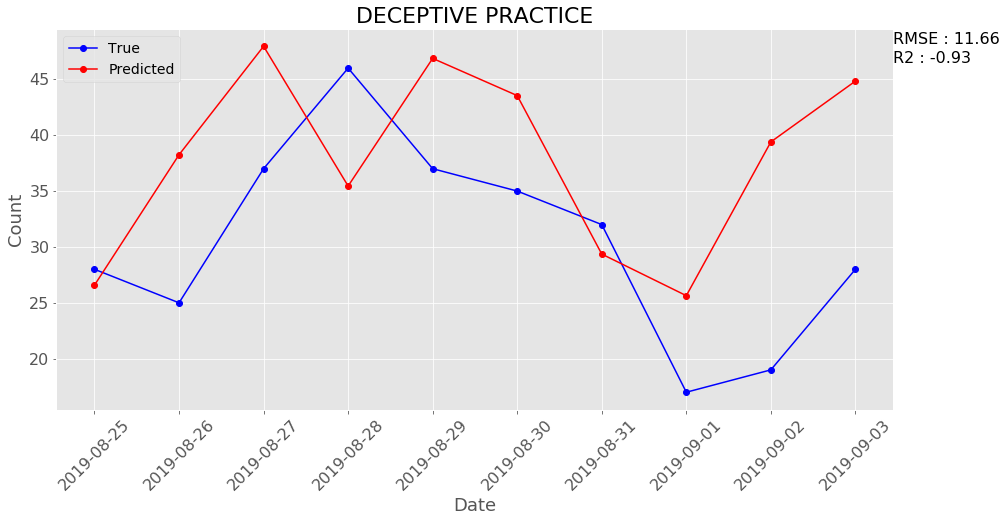

In [156]:
true_values = arima_df_day["DECEPTIVE PRACTICE"][-10:]
dates = arima_df_day["Date"][-10:]
custom_functions.plot_true_vs_predicted(true_values, forecast_dp, dates, title = "DECEPTIVE PRACTICE")

Model is useless.

## NARCOTICS<a id = 'nar_SARIMA'></a>

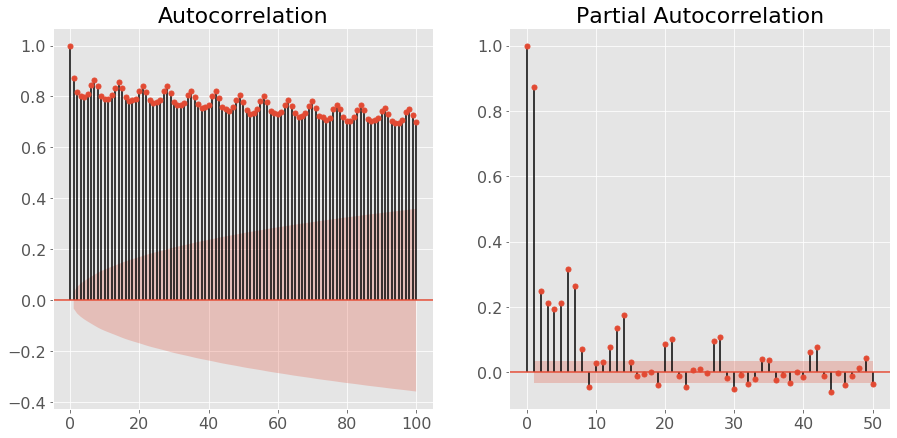

In [157]:
custom_functions.plot_ACF_PACF(arima_df_day["NARCOTICS"])

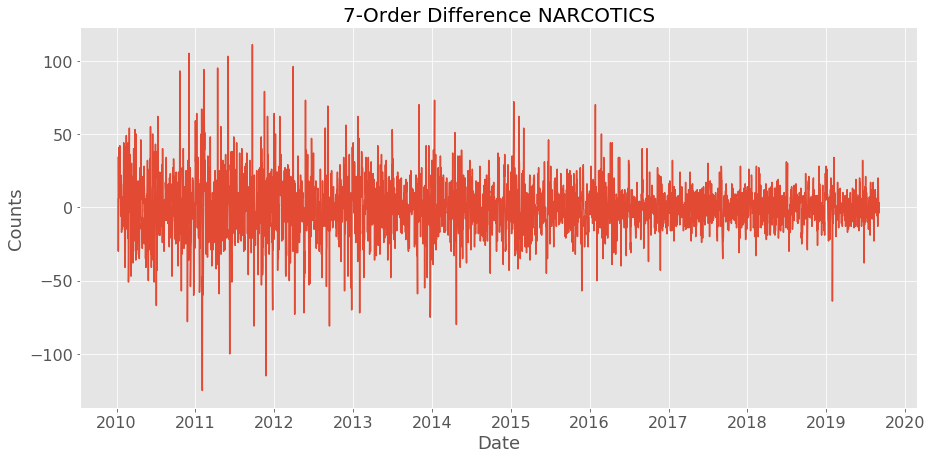

In [158]:
differenced = custom_functions.difference(arima_df_day["NARCOTICS"],7)
custom_functions.sequence_plot(differenced, arima_df_day["Date"][7:], title = "7-Order Difference NARCOTICS")

In [159]:
series = arima_df_day["NARCOTICS"][:-10]
series.index = arima_df_day["Date"][:-10]

# Sometimes Seasonal terms dominate non seasonal terms, that's why we have taken order = 6, 1, 0 and seasonal order = 5, 1, 0, 7
forecast_nar = custom_functions.fit_SARIMA(series, series.index, trend = "n", order = (6, 1, 0), sorder = (5, 1, 0, 7), 
                                              title = "NARCOTICS")

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


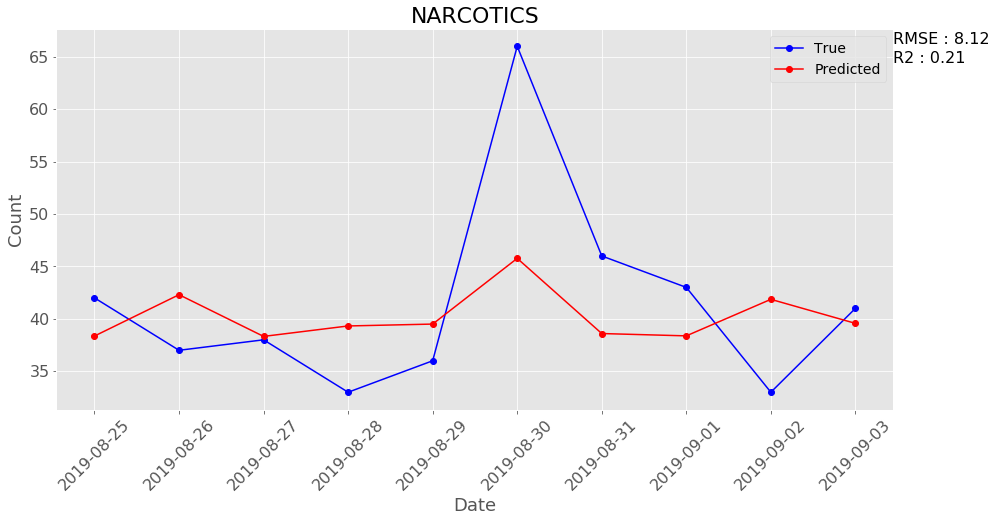

In [160]:
true_values = arima_df_day["NARCOTICS"][-10:]
dates = arima_df_day["Date"][-10:]
custom_functions.plot_true_vs_predicted(true_values, forecast_nar, dates, title = "NARCOTICS")

Model can explain 21% of the variation in the data with the RMSE value of 8.12.

## PUBLIC PEACE VIOLATION

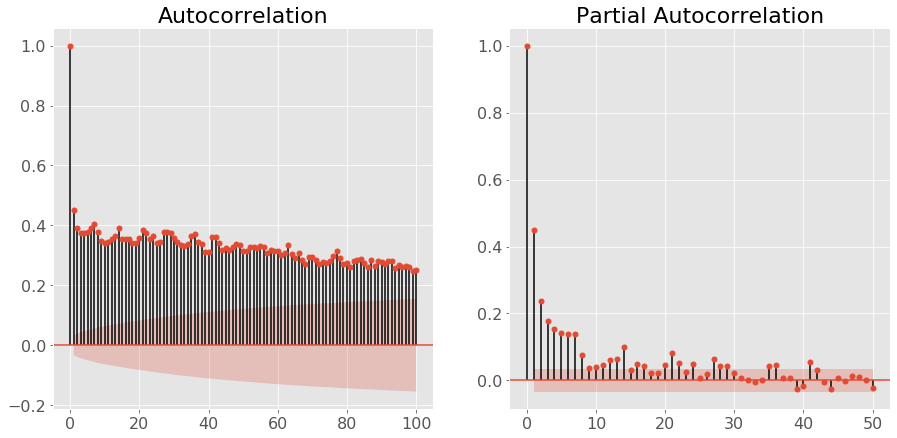

In [161]:
custom_functions.plot_ACF_PACF(arima_df_day["PUBLIC PEACE VIOLATION"])

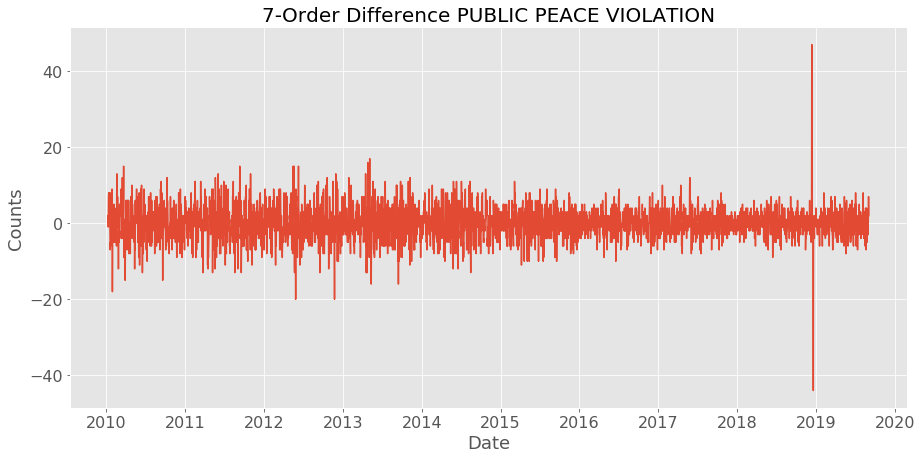

In [162]:
differenced = custom_functions.difference(arima_df_day["PUBLIC PEACE VIOLATION"],7)
custom_functions.sequence_plot(differenced, arima_df_day["Date"][7:], title = "7-Order Difference PUBLIC PEACE VIOLATION")

In [163]:
series = arima_df_day["PUBLIC PEACE VIOLATION"][:-10]
series.index = arima_df_day["Date"][:-10]
forecast_ppv = custom_functions.fit_SARIMA(series, series.index, trend = "n", order = (15, 1, 0), sorder = (0, 1, 1, 7), 
                                              title = "PUBLIC PEACE VIOLATION")

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


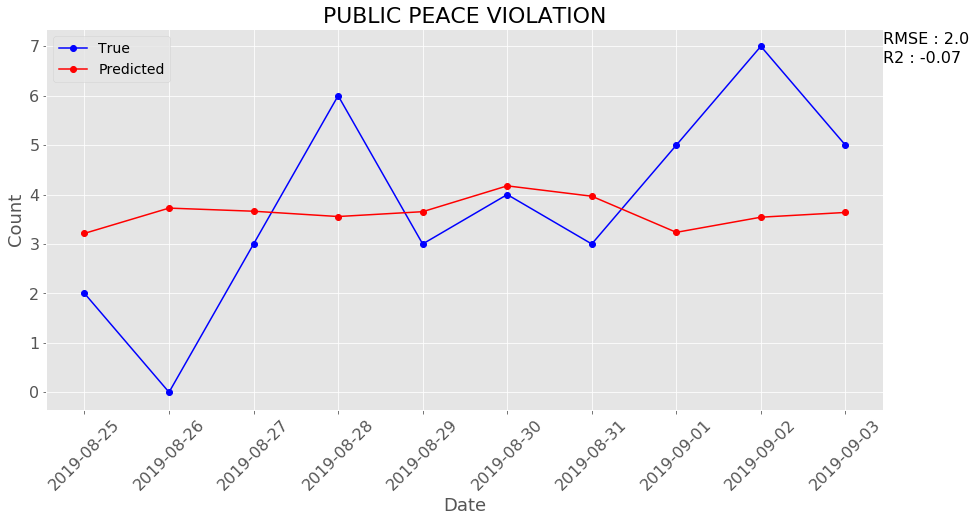

In [164]:
true_values = arima_df_day["PUBLIC PEACE VIOLATION"][-10:]
dates = arima_df_day["Date"][-10:]
custom_functions.plot_true_vs_predicted(true_values, forecast_ppv, dates, title = "PUBLIC PEACE VIOLATION")

Model is useless.

# Conclusion

I was not able to forecast all the variable using ARIMA and SARIMA models. Some of the models perform worse than fitting the mean to the data and some of the models perfomed very well.

Final models are as following:

1. Variable - Crime Type - BATTERY
    
    [MODEL 1](#battery_ARIMA)
       Model - ARIMA(15, 1, 0) - R2 = 63% - RMSE = 16.26
    
    [MODEL 2](#battery_SARIMA)
       Model - ARIMA(15, 1, 0)(0, 1, 1, 7) --> SARIMA - R2 = 64% - RMSE = 16.03

2. Variable - Crime Type - WEAPONS VIOLATION
    
    [MODEL 1](#wp_ARIMA)
       Model - ARIMA(14, 1, 0) - R2 = 34% - RMSE = 6.32
       
    [MODEL 2](#wp_SARIMA)
       Model - ARIMA(15, 0, 0)(0, 1, 0, 7) --> SARIMA - R2 = 58% - RMSE = 5.01

3. Variable - Crime Type - NARCOTICS
    
    [MODEL 1](#nar_SARIMA)
       Model - ARIMA(6, 1, 0)(5, 1, 0, 7) --> SARIMA - R2 = 21% - RMSE = 8.12

4. Variable - Crime Type - Total Crimes
    
    [MODEL 1](#crimes_SARIMA)
       Model - ARIMA(15, 1, 0)(0, 1, 0, 7) --> SARIMA - R2 = 56% - RMSE = 27.64